# Impacto de PCA y QPCA

En este notebook se prueban tanto PCA como QPCA en varios casos al igual que se hacia en notebooks anteriores y se testea su impacto en el rendimiento de modelos clásicos (en este caso se considera un árbol de decisión) y cuánticos (se vuelve a probar con un VQC con COBYLA para ver si mejora los resultados del notebook anterior).

In [1]:
!pip install pennylane qiskit==0.44.0 qiskit-machine-learning qiskit-aer==0.12.0

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of qiskit-machine-learning to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install scikit-learn numpy

## Preparación de los datos

In [3]:
import pandas as pd

data = pd.read_csv("data.csv")

data.head()

category     amt     state      lat      long  is_fraud  hora  dia  mes  \
0  0.002404   91.82  0.005391  41.6060 -109.2300         0    12    5    8   
1  0.001621   38.60  0.005991  37.0581  -86.1938         0    12    5    8   
2  0.013720  104.39  0.006025  44.8232  -89.1665         0     7    5    8   
3  0.013989    3.68  0.005193  46.5901 -117.1692         0    10    5    8   
4  0.013989    1.61  0.006197  42.1939  -76.7361         0     8    5    8   

   edad  card_type  previous_fraud_client  previous_fraud_merchant  gender_M  \
0    36   0.005559                    1.0                      1.0     False   
1    21   0.005652                    1.0                      1.0     False   
2    66   0.005652                    1.0                      1.0      True   
3    77   0.005652                    1.0                      1.0     False   
4    29   0.004766                    1.0                      1.0     False   

   periodo_dia_noche  periodo_dia_tarde  
0              False              False  
1              False              False  
2              False              False  
3              False              False  
4              False              False

In [4]:
data_2 = data.drop(['state', 'lat', 'long', 'hora', 'dia', 'mes', 'gender_M', 'periodo_dia_tarde'], axis=1)

data_2.columns

Index(['category', 'amt', 'is_fraud', 'edad', 'card_type',
       'previous_fraud_client', 'previous_fraud_merchant',
       'periodo_dia_noche'],
      dtype='object')

## Estudio Comparativo (Desbalanceo 75-25, 2D)

In [5]:
import matplotlib.pyplot as plt

def crear_submuestra_balanceada(df, label_col, total_muestra, proporcion_clase_mayor=0.75):
    # Contar clases
    clases = df['is_fraud'].unique()
    if len(clases) != 2:
        raise ValueError("Este método está pensado para problemas binarios (dos clases).")

    # Determinar cuántas instancias tomar de cada clase
    n_mayor = int(total_muestra * proporcion_clase_mayor)
    n_menor = total_muestra - n_mayor

    # Detectar qué clase es la mayor
    conteos = df['is_fraud'].value_counts()
    clase_mayor = conteos.idxmax()
    clase_menor = conteos.idxmin()

    # Tomar muestras aleatorias
    df_mayor = df[df['is_fraud'] == clase_mayor].sample(n=n_mayor, random_state=42)
    df_menor = df[df['is_fraud'] == clase_menor].sample(n=n_menor, random_state=42)

    # Combinar y mezclar
    df_final = pd.concat([df_mayor, df_menor]).sample(frac=1, random_state=42).reset_index(drop=True)
    return df_final

# Crear muestras
df1 = crear_submuestra_balanceada(data_2, label_col='label', total_muestra=200)
df2 = crear_submuestra_balanceada(data_2, label_col='label', total_muestra=500)

### 200 datos

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np

x1 = df1.drop(columns='is_fraud')
y1 = df1['is_fraud']

x1 = np.array(x1, dtype=np.float32)
y1 = np.array(y1, dtype=np.float32)

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(
    x1, y1, test_size=0.3, stratify=y1, random_state=42
)

#### PCA

In [7]:
from sklearn.decomposition import PCA

# Creamos instancia de PCA para reducir a 2D.
pca = PCA(n_components=2)

# Transformamos los datos.
x_train_pca_1 = pca.fit_transform(x_train_1)
x_test_pca_1 = pca.transform(x_test_1)

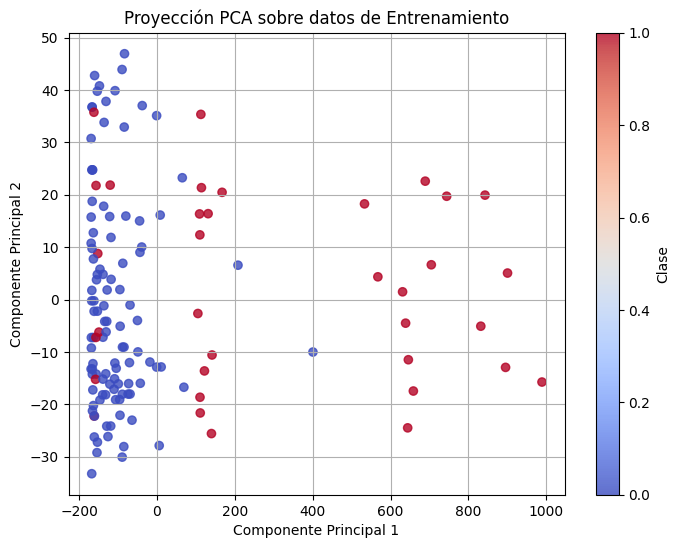

In [8]:
# Visualizamos los resultados.
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_train_pca_1[:, 0], x_train_pca_1[:, 1], c=y_train_1, cmap='coolwarm', alpha=0.8)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Proyección PCA sobre datos de Entrenamiento")
plt.colorbar(scatter, label='Clase')
plt.grid(True)
plt.show()

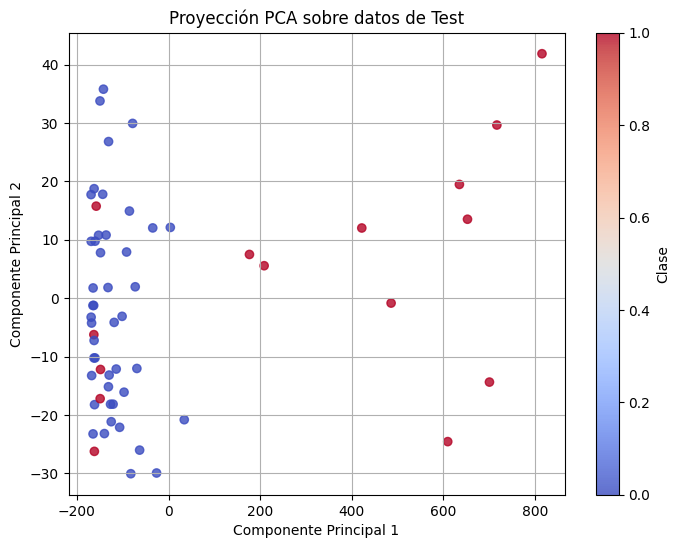

In [9]:
# Visualizamos los resultados.
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_test_pca_1[:, 0], x_test_pca_1[:, 1], c=y_test_1, cmap='coolwarm', alpha=0.8)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Proyección PCA sobre datos de Test")
plt.colorbar(scatter, label='Clase')
plt.grid(True)
plt.show()

#### QPCA

In [10]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

# Esta función asegura que cada vector tenga longitud igual a 2^n_qubits (8 en este caso)
def pad_vector(x, target_len):
    if len(x) >= target_len:
        return x[:target_len]
    return np.pad(x, (0, target_len - len(x)), 'constant')

# Elegimos 3 qubits -> necesitamos vectores de dimensión 2^3 = 8
n_qubits = 3
state_dim = 2**n_qubits

# Padding de los datos de entrenamiento y test
x_train_1_padded = np.array([pad_vector(x, state_dim) for x in x_train_1])
x_test_1_padded = np.array([pad_vector(x, state_dim) for x in x_test_1])

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [11]:
# Creamos un dispositivo simulado de 3 qubits
dev = qml.device("default.qubit", wires=n_qubits, shots=5000)

# Codificamos el vector en el estado del sistema cuántico usando Amplitude Embedding
def state_preparation(x, n_qubits=3):
    qml.AmplitudeEmbedding(x, wires=range(n_qubits), normalize=True, pad_with=3)

# Definimos el circuito cuántico que mide PauliZ en cada qubit
@qml.qnode(dev)
def density_matrix_measurement(x):
    state_preparation(x)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [12]:
# Obtenemos la "proyección" de cada dato en el espacio cuántico
# Cada vector resulta en una medida de 3 dimensiones (una por qubit)
train_meas = np.array([density_matrix_measurement(x) for x in x_train_1_padded])
test_meas = np.array([density_matrix_measurement(x) for x in x_test_1_padded])

In [13]:
# Calculamos la matriz de covarianza de las medidas cuánticas
cov_qpca = np.cov(train_meas.T)

# Obtenemos autovalores y autovectores (componentes principales)
eigenvalues, eigenvectors = np.linalg.eigh(cov_qpca)

# Ordenamos los vectores propios en orden descendente de autovalor
idx = np.argsort(-eigenvalues)
principal_components = eigenvectors[:, idx[:2]]

In [14]:
# Proyectamos las medidas cuánticas en las dos componentes principales
projections_train = train_meas @ principal_components
projections_test = test_meas @ principal_components

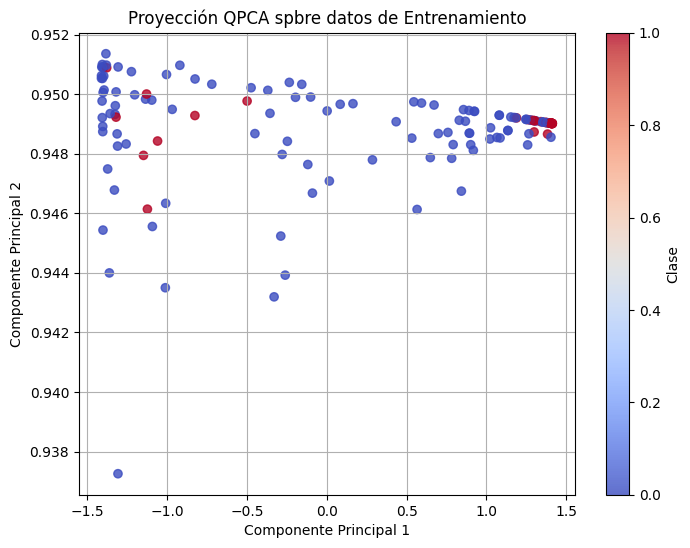

In [15]:
# Visualización de los resultados.
plt.figure(figsize=(8, 6))
scatter = plt.scatter(projections_train[:, 0], projections_train[:, 1], c=y_train_1, cmap='coolwarm', alpha=0.8)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Proyección QPCA spbre datos de Entrenamiento")
plt.colorbar(scatter, label='Clase')
plt.grid(True)
plt.show()

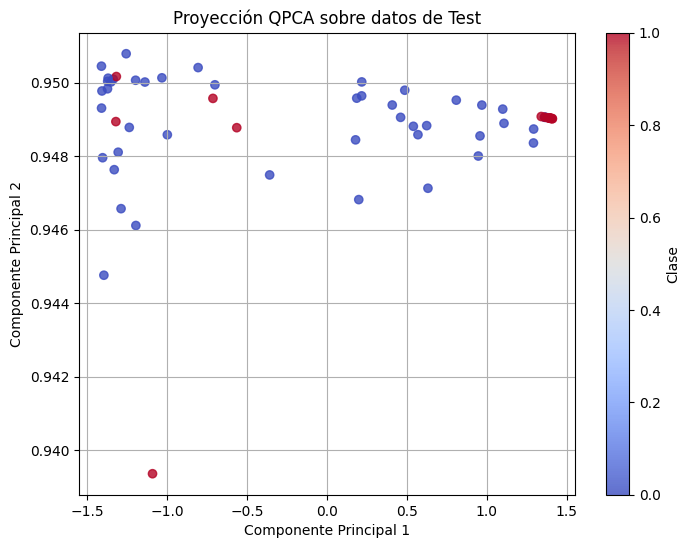

In [16]:
# Visualización de los resultados.
plt.figure(figsize=(8, 6))
scatter = plt.scatter(projections_test[:, 0], projections_test[:, 1], c=y_test_1, cmap='coolwarm', alpha=0.8)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Proyección QPCA sobre datos de Test")
plt.colorbar(scatter, label='Clase')
plt.grid(True)
plt.show()

#### Decision Tree (PCA)

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report

# Entrenamos y evaluamos datos con PCA.
dt = DecisionTreeClassifier(random_state=17, max_depth=3)
dt.fit(x_train_pca_1, y_train_1)

y_pred_dtpca_1 = dt.predict(x_test_pca_1)

accuracy_dtpca_200_1 = accuracy_score(y_test_1, y_pred_dtpca_1)
precision_dtpca_200_1 = precision_score(y_test_1, y_pred_dtpca_1)
recall_dtpca_200_1 = recall_score(y_test_1, y_pred_dtpca_1)
f1_dtpca_200_1 = f1_score(y_test_1, y_pred_dtpca_1)

print(f"Accuracy Decision Tree con PCA: {accuracy_dtpca_200_1}")
print(f"Precisión Decision Tree con PCA: {precision_dtpca_200_1}")
print(f"Recall Decision Tree con PCA: {recall_dtpca_200_1}")
print(f"F1 Score Decision Tree con PCA: {f1_dtpca_200_1}")
print(classification_report(y_test_1, y_pred_dtpca_1))

Accuracy Decision Tree con PCA: 0.8833333333333333
Precisión Decision Tree con PCA: 0.8333333333333334
Recall Decision Tree con PCA: 0.6666666666666666
F1 Score Decision Tree con PCA: 0.7407407407407407
              precision    recall  f1-score   support

         0.0       0.90      0.96      0.92        45
         1.0       0.83      0.67      0.74        15

    accuracy                           0.88        60
   macro avg       0.86      0.81      0.83        60
weighted avg       0.88      0.88      0.88        60



#### Decision Tree (QPCA)

In [18]:
# Ahora lo mismo para la versión con QPCA.
qdt = DecisionTreeClassifier(random_state=17, max_depth=3)
qdt.fit(projections_train, y_train_1)

y_pred_qdtpca_1 = qdt.predict(projections_test)

accuracy_qdtpca_200_1 = accuracy_score(y_test_1, y_pred_qdtpca_1)
precision_qdtpca_200_1 = precision_score(y_test_1, y_pred_qdtpca_1)
recall_qdtpca_200_1 = recall_score(y_test_1, y_pred_qdtpca_1)
f1_qdtpca_200_1 = f1_score(y_test_1, y_pred_qdtpca_1)

print(f"Accuracy Decision Tree con QPCA: {accuracy_qdtpca_200_1}")
print(f"Precisión Decision Tree con QPCA: {precision_qdtpca_200_1}")
print(f"Recall Decision Tree con QPCA: {recall_qdtpca_200_1}")
print(f"F1 Score Decision Tree con QPCA: {f1_qdtpca_200_1}")
print(classification_report(y_test_1, y_pred_qdtpca_1))

Accuracy Decision Tree con QPCA: 0.85
Precisión Decision Tree con QPCA: 0.875
Recall Decision Tree con QPCA: 0.4666666666666667
F1 Score Decision Tree con QPCA: 0.6086956521739131
              precision    recall  f1-score   support

         0.0       0.85      0.98      0.91        45
         1.0       0.88      0.47      0.61        15

    accuracy                           0.85        60
   macro avg       0.86      0.72      0.76        60
weighted avg       0.85      0.85      0.83        60



#### VQC con COBYLA (PCA)

In [19]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal, EfficientSU2
from qiskit_machine_learning.algorithms import VQC
from qiskit.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit.algorithms.optimizers import COBYLA
from qiskit_aer import Aer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

# Escalamos los datos entre 0 y 2 * pi por estar utilizando ángulos.
scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))
x_train_scaled = scaler.fit_transform(x_train_pca_1)
x_test_scaled = scaler.transform(x_test_pca_1)

# Definimos el mapa de características.
feature_map = ZZFeatureMap(feature_dimension=x_train_scaled.shape[1], reps=3)

# Y el ansatz.
ansatz = TwoLocal(num_qubits=x_train_scaled.shape[1], reps=3, rotation_blocks='ry', entanglement_blocks='cz')

# Usamos un sampler para el backend.
sampler = AerSampler()

# Definimos callback para guardar losses y plotear al final.
def callback(weights, loss):
    losses.append(loss)
    print(f"Loss: {loss:.4f}")

losses = []

# Creamos el modelo VQC con COBYLA.
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=500),
    sampler=sampler,
    initial_point=np.random.rand(ansatz.num_parameters),
    callback=callback,
)

# Y entrenamos.
vqc.fit(x_train_scaled, y_train_1)

<ipython-input-19-1c1a635d4f7e>:6: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA


Loss: 1.2036
Loss: 1.6869
Loss: 0.9168
Loss: 0.8316
Loss: 0.8372
Loss: 0.9217
Loss: 0.7838
Loss: 0.9034
Loss: 0.7881
Loss: 0.9307
Loss: 0.8119
Loss: 0.8078
Loss: 0.9078
Loss: 0.7876
Loss: 0.8289
Loss: 0.8020
Loss: 0.7930
Loss: 0.7789
Loss: 0.7909
Loss: 0.7821
Loss: 0.7928
Loss: 0.8064
Loss: 0.7947
Loss: 0.7873
Loss: 0.7760
Loss: 0.7766
Loss: 0.7836
Loss: 0.7857
Loss: 0.7859
Loss: 0.7860
Loss: 0.7857
Loss: 0.7875
Loss: 0.7840
Loss: 0.7780
Loss: 0.7861
Loss: 0.7838
Loss: 0.7825
Loss: 0.7785
Loss: 0.7824
Loss: 0.7770
Loss: 0.7835
Loss: 0.7798
Loss: 0.7883
Loss: 0.7729
Loss: 0.7871
Loss: 0.7864
Loss: 0.7860
Loss: 0.7867
Loss: 0.7842
Loss: 0.7839
Loss: 0.7875
Loss: 0.7825
Loss: 0.7891
Loss: 0.7842
Loss: 0.7871
Loss: 0.7845
Loss: 0.7905
Loss: 0.7857
Loss: 0.7845
Loss: 0.7880
Loss: 0.7894
Loss: 0.7797
Loss: 0.7898
Loss: 0.7839
Loss: 0.7855
Loss: 0.7904
Loss: 0.7873
Loss: 0.7939
Loss: 0.7856
Loss: 0.7791
Loss: 0.7828
Loss: 0.7856
Loss: 0.7850
Loss: 0.7833
Loss: 0.7897
Loss: 0.7878
Loss: 0.7844

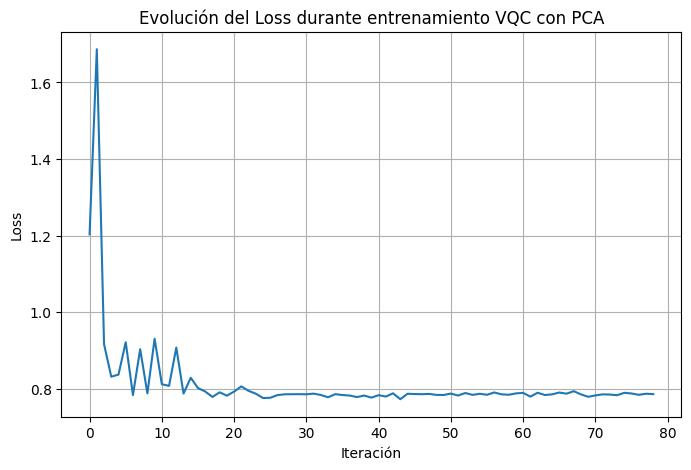

In [20]:
# Graficamos la evolución del loss
plt.figure(figsize=(8,5))
plt.plot(losses, linestyle='-')
plt.title('Evolución del Loss durante entrenamiento VQC con PCA')
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [21]:
# Mostramos ahora los resultados.
y_pred = vqc.predict(x_test_scaled)

accuracy_vqc_pca_200_1 = accuracy_score(y_test_1, y_pred)
precision_vqc_pca_200_1 = precision_score(y_test_1, y_pred)
recall_vqc_pca_200_1 = recall_score(y_test_1, y_pred)
f1_vqc_pca_200_1 = f1_score(y_test_1, y_pred)

print("Accuracy:", accuracy_vqc_pca_200_1)
print("Precisión:", precision_vqc_pca_200_1)
print("Recall:", recall_vqc_pca_200_1)
print("F1 score:", f1_vqc_pca_200_1)
print(classification_report(y_test_1, y_pred))

Accuracy: 0.7166666666666667
Precisión: 0.4166666666666667
Recall: 0.3333333333333333
F1 score: 0.37037037037037035
              precision    recall  f1-score   support

         0.0       0.79      0.84      0.82        45
         1.0       0.42      0.33      0.37        15

    accuracy                           0.72        60
   macro avg       0.60      0.59      0.59        60
weighted avg       0.70      0.72      0.71        60



#### VQC con COBYLA (QPCA)

In [22]:
# Escalamos los datos entre 0 y 2 * pi por estar utilizando ángulos.
scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))
x_train_scaled = scaler.fit_transform(projections_train)
x_test_scaled = scaler.transform(projections_test)

# Definimos el mapa de características.
feature_map = ZZFeatureMap(feature_dimension=x_train_scaled.shape[1], reps=3)

# Y el ansatz.
ansatz = TwoLocal(num_qubits=x_train_scaled.shape[1], reps=3, rotation_blocks='ry', entanglement_blocks='cz')

# Usamos un sampler para el backend.
sampler = AerSampler()

losses = []

# Creamos el modelo VQC con COBYLA.
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=500),
    sampler=sampler,
    initial_point=np.random.rand(ansatz.num_parameters),
    callback=callback,
)

# Y entrenamos.
vqc.fit(x_train_scaled, y_train_1)

Loss: 1.5211
Loss: 1.5279
Loss: 1.3666
Loss: 0.9770
Loss: 0.8566
Loss: 1.1125
Loss: 0.8444
Loss: 0.9321
Loss: 0.8434
Loss: 0.9638
Loss: 0.8520
Loss: 0.8489
Loss: 1.0115
Loss: 0.8573
Loss: 0.8506
Loss: 0.9557
Loss: 0.8502
Loss: 0.8558
Loss: 0.8455
Loss: 0.8241
Loss: 0.8447
Loss: 0.8445
Loss: 0.8313
Loss: 0.8333
Loss: 0.7988
Loss: 0.7802
Loss: 0.7812
Loss: 0.7880
Loss: 0.8000
Loss: 0.7809
Loss: 0.7870
Loss: 0.7950
Loss: 0.7863
Loss: 0.7823
Loss: 0.7881
Loss: 0.7827
Loss: 0.7834
Loss: 0.7852
Loss: 0.7871
Loss: 0.7908
Loss: 0.7801
Loss: 0.7860
Loss: 0.7889
Loss: 0.7866
Loss: 0.7914
Loss: 0.7784
Loss: 0.7886
Loss: 0.7828
Loss: 0.7798
Loss: 0.7862
Loss: 0.7873
Loss: 0.7738
Loss: 0.7881
Loss: 0.7869
Loss: 0.7935
Loss: 0.7837
Loss: 0.7852
Loss: 0.7825
Loss: 0.7856
Loss: 0.7839
Loss: 0.7840
Loss: 0.7829
Loss: 0.7856
Loss: 0.7834
Loss: 0.7800
Loss: 0.7863
Loss: 0.7859
Loss: 0.7806
Loss: 0.7835
Loss: 0.7815
Loss: 0.7856
Loss: 0.7810
Loss: 0.7806
Loss: 0.7911
Loss: 0.7807
Loss: 0.7805
Loss: 0.7820

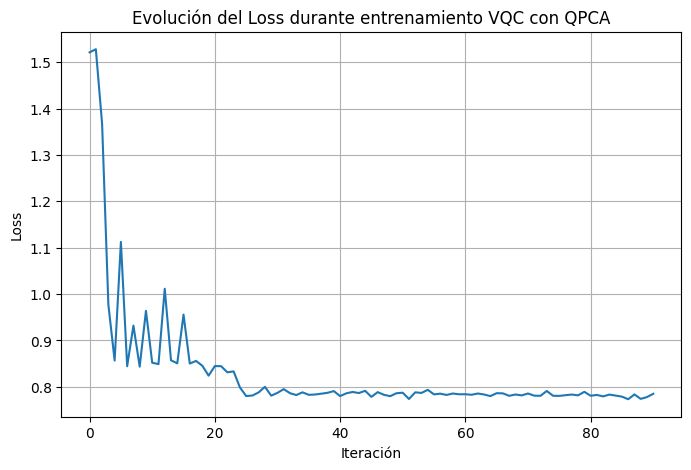

In [23]:
# Graficamos la evolución del loss
plt.figure(figsize=(8,5))
plt.plot(losses, linestyle='-')
plt.title('Evolución del Loss durante entrenamiento VQC con QPCA')
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [24]:
# Mostramos ahora los resultados.
y_pred = vqc.predict(x_test_scaled)

accuracy_vqc_qpca_200_1 = accuracy_score(y_test_1, y_pred)
precision_vqc_qpca_200_1 = precision_score(y_test_1, y_pred)
recall_vqc_qpca_200_1 = recall_score(y_test_1, y_pred)
f1_vqc_qpca_200_1 = f1_score(y_test_1, y_pred)

print("Accuracy:", accuracy_vqc_qpca_200_1)
print("Precisión:", precision_vqc_qpca_200_1)
print("Recall:", recall_vqc_qpca_200_1)
print("F1 score:", f1_vqc_qpca_200_1)
print(classification_report(y_test_1, y_pred))

Accuracy: 0.5833333333333334
Precisión: 0.08333333333333333
Recall: 0.06666666666666667
F1 score: 0.07407407407407407
              precision    recall  f1-score   support

         0.0       0.71      0.76      0.73        45
         1.0       0.08      0.07      0.07        15

    accuracy                           0.58        60
   macro avg       0.40      0.41      0.40        60
weighted avg       0.55      0.58      0.57        60



### 500 datos

In [25]:
x1 = df2.drop(columns='is_fraud')
y1 = df2['is_fraud']

x1 = np.array(x1, dtype=np.float32)
y1 = np.array(y1, dtype=np.float32)

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(
    x1, y1, test_size=0.3, stratify=y1, random_state=42
)

#### PCA

In [26]:
# Creamos instancia de PCA para reducir a 2D.
pca = PCA(n_components=2)

# Transformamos los datos.
x_train_pca_1 = pca.fit_transform(x_train_1)
x_test_pca_1 = pca.transform(x_test_1)

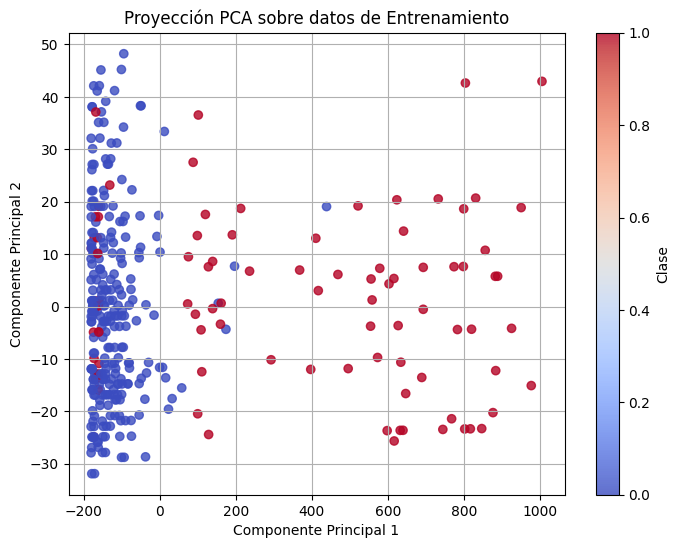

In [27]:
# Visualizamos los resultados.
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_train_pca_1[:, 0], x_train_pca_1[:, 1], c=y_train_1, cmap='coolwarm', alpha=0.8)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Proyección PCA sobre datos de Entrenamiento")
plt.colorbar(scatter, label='Clase')
plt.grid(True)
plt.show()

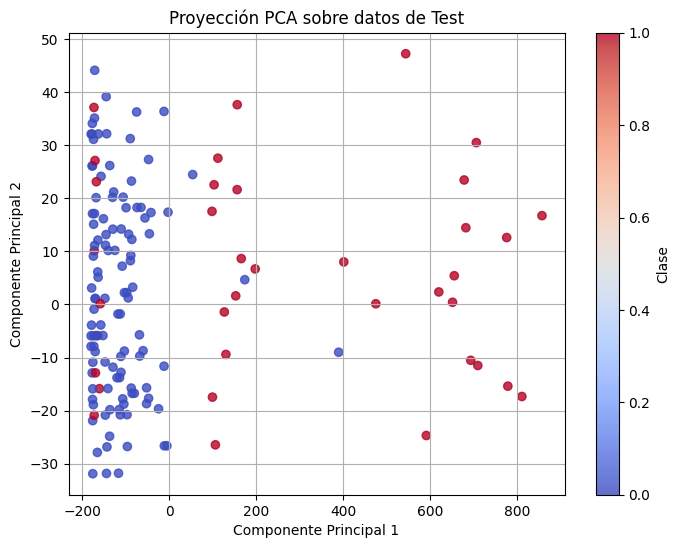

In [28]:
# Visualizamos los resultados.
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_test_pca_1[:, 0], x_test_pca_1[:, 1], c=y_test_1, cmap='coolwarm', alpha=0.8)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Proyección PCA sobre datos de Test")
plt.colorbar(scatter, label='Clase')
plt.grid(True)
plt.show()

#### QPCA

In [29]:
# Elegimos 3 qubits -> necesitamos vectores de dimensión 2^3 = 8
n_qubits = 3
state_dim = 2**n_qubits

# Padding de los datos de entrenamiento y test
x_train_1_padded = np.array([pad_vector(x, state_dim) for x in x_train_1])
x_test_1_padded = np.array([pad_vector(x, state_dim) for x in x_test_1])

# Creamos un dispositivo simulado de 3 qubits
dev = qml.device("default.qubit", wires=n_qubits, shots=5000)

# Definimos el circuito cuántico que mide PauliZ en cada qubit
@qml.qnode(dev)
def density_matrix_measurement(x):
    state_preparation(x)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Obtenemos la "proyección" de cada dato en el espacio cuántico
# Cada vector viene de una medida de 3 dimensiones (una por qubit)
train_meas = np.array([density_matrix_measurement(x) for x in x_train_1])
test_meas = np.array([density_matrix_measurement(x) for x in x_test_1])

# Calculamos la matriz de covarianza de las medidas cuánticas
cov_qpca = np.cov(train_meas.T)

# Obtenemos autovalores y autovectores (componentes principales)
eigenvalues, eigenvectors = np.linalg.eigh(cov_qpca)

# Ordenamos los vectores propios en orden descendente de autovalor
idx = np.argsort(-eigenvalues)
principal_components = eigenvectors[:, idx[:2]]

# Proyectamos las medidas cuánticas en las dos componentes principales
projections_train = train_meas @ principal_components
projections_test = test_meas @ principal_components

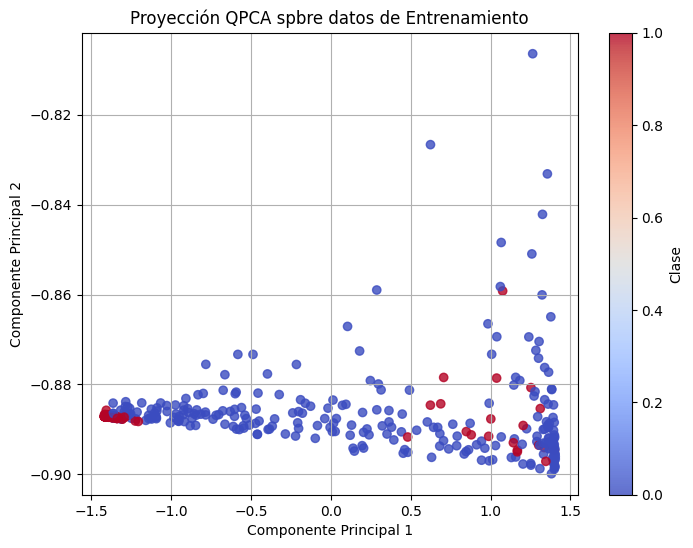

In [30]:
# Visualización de los resultados.
plt.figure(figsize=(8, 6))
scatter = plt.scatter(projections_train[:, 0], projections_train[:, 1], c=y_train_1, cmap='coolwarm', alpha=0.8)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Proyección QPCA spbre datos de Entrenamiento")
plt.colorbar(scatter, label='Clase')
plt.grid(True)
plt.show()

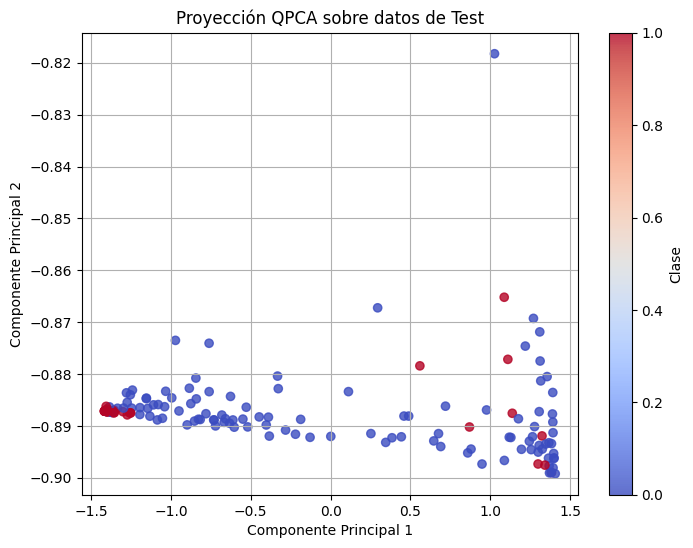

In [31]:
# Visualización de los resultados.
plt.figure(figsize=(8, 6))
scatter = plt.scatter(projections_test[:, 0], projections_test[:, 1], c=y_test_1, cmap='coolwarm', alpha=0.8)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Proyección QPCA sobre datos de Test")
plt.colorbar(scatter, label='Clase')
plt.grid(True)
plt.show()

#### Decision Tree (PCA)

In [32]:
# Entrenamos y evaluamos datos con PCA.
dt = DecisionTreeClassifier(random_state=17, max_depth=3)
dt.fit(x_train_pca_1, y_train_1)

y_pred_dtpca_1 = dt.predict(x_test_pca_1)

accuracy_dtpca_500_1 = accuracy_score(y_test_1, y_pred_dtpca_1)
precision_dtpca_500_1 = precision_score(y_test_1, y_pred_dtpca_1)
recall_dtpca_500_1 = recall_score(y_test_1, y_pred_dtpca_1)
f1_dtpca_500_1 = f1_score(y_test_1, y_pred_dtpca_1)

print(f"Accuracy Decision Tree con PCA: {accuracy_dtpca_500_1}")
print(f"Precisión Decision Tree con PCA: {precision_dtpca_500_1}")
print(f"Recall Decision Tree con PCA: {recall_dtpca_500_1}")
print(f"F1 Score Decision Tree con PCA: {f1_dtpca_500_1}")
print(classification_report(y_test_1, y_pred_dtpca_1))

Accuracy Decision Tree con PCA: 0.9266666666666666
Precisión Decision Tree con PCA: 0.90625
Recall Decision Tree con PCA: 0.7837837837837838
F1 Score Decision Tree con PCA: 0.8405797101449275
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95       113
         1.0       0.91      0.78      0.84        37

    accuracy                           0.93       150
   macro avg       0.92      0.88      0.90       150
weighted avg       0.93      0.93      0.92       150



#### Decision Tree (QPCA)

In [33]:
# Ahora lo mismo para la versión con QPCA.
qdt = DecisionTreeClassifier(random_state=17, max_depth=3)
qdt.fit(projections_train, y_train_1)

y_pred_qdtpca_1 = qdt.predict(projections_test)

accuracy_qdtpca_500_1 = accuracy_score(y_test_1, y_pred_qdtpca_1)
precision_qdtpca_500_1 = precision_score(y_test_1, y_pred_qdtpca_1)
recall_qdtpca_500_1 = recall_score(y_test_1, y_pred_qdtpca_1)
f1_qdtpca_500_1 = f1_score(y_test_1, y_pred_qdtpca_1)

print(f"Accuracy Decision Tree con QPCA: {accuracy_qdtpca_500_1}")
print(f"Precisión Decision Tree con QPCA: {precision_qdtpca_500_1}")
print(f"Recall Decision Tree con QPCA: {recall_qdtpca_500_1}")
print(f"F1 Score Decision Tree con QPCA: {f1_qdtpca_500_1}")
print(classification_report(y_test_1, y_pred_qdtpca_1))

Accuracy Decision Tree con QPCA: 0.8866666666666667
Precisión Decision Tree con QPCA: 0.8571428571428571
Recall Decision Tree con QPCA: 0.6486486486486487
F1 Score Decision Tree con QPCA: 0.7384615384615385
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.93       113
         1.0       0.86      0.65      0.74        37

    accuracy                           0.89       150
   macro avg       0.88      0.81      0.83       150
weighted avg       0.88      0.89      0.88       150



#### VQC con COBYLA (PCA)

In [34]:
# Escalamos los datos entre 0 y 2 * pi por estar utilizando ángulos.
scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))
x_train_scaled = scaler.fit_transform(x_train_pca_1)
x_test_scaled = scaler.transform(x_test_pca_1)

# Definimos el mapa de características.
feature_map = ZZFeatureMap(feature_dimension=x_train_scaled.shape[1], reps=3)

# Y el ansatz.
ansatz = TwoLocal(num_qubits=x_train_scaled.shape[1], reps=3, rotation_blocks='ry', entanglement_blocks='cz')

# Usamos un sampler para el backend.
sampler = AerSampler()

losses = []

# Creamos el modelo VQC con COBYLA.
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=500),
    sampler=sampler,
    initial_point=np.random.rand(ansatz.num_parameters),
    callback=callback,
)

# Y entrenamos.
vqc.fit(x_train_scaled, y_train_1)

Loss: 0.9289
Loss: 1.1095
Loss: 0.8969
Loss: 0.8847
Loss: 0.8832
Loss: 1.2572
Loss: 0.9183
Loss: 1.2109
Loss: 0.8778
Loss: 0.8812
Loss: 0.8622
Loss: 0.8986
Loss: 0.8456
Loss: 0.8247
Loss: 0.8321
Loss: 0.8314
Loss: 0.8246
Loss: 0.8308
Loss: 0.8265
Loss: 0.8235
Loss: 0.8402
Loss: 0.8322
Loss: 0.8749
Loss: 0.8110
Loss: 0.8204
Loss: 0.8129
Loss: 0.8122
Loss: 0.8075
Loss: 0.8042
Loss: 0.8059
Loss: 0.8155
Loss: 0.8024
Loss: 0.8048
Loss: 0.8047
Loss: 0.8053
Loss: 0.8033
Loss: 0.8033
Loss: 0.8084
Loss: 0.8045
Loss: 0.8030
Loss: 0.8035
Loss: 0.8041
Loss: 0.8016
Loss: 0.8013
Loss: 0.7976
Loss: 0.8035
Loss: 0.8049
Loss: 0.8014
Loss: 0.8029
Loss: 0.8060
Loss: 0.8015
Loss: 0.8081
Loss: 0.8041
Loss: 0.8016
Loss: 0.8014
Loss: 0.8038
Loss: 0.7975
Loss: 0.8006
Loss: 0.8030
Loss: 0.7996
Loss: 0.8033
Loss: 0.7978
Loss: 0.7993
Loss: 0.7963
Loss: 0.7956
Loss: 0.7992
Loss: 0.8006
Loss: 0.7985
Loss: 0.7999
Loss: 0.8020
Loss: 0.8043
Loss: 0.7978
Loss: 0.8013
Loss: 0.8059
Loss: 0.8039
Loss: 0.8027
Loss: 0.8018

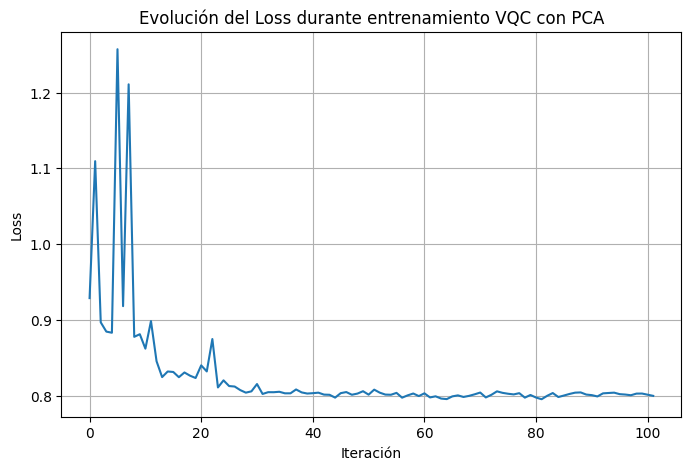

In [35]:
# Graficamos la evolución del loss
plt.figure(figsize=(8,5))
plt.plot(losses, linestyle='-')
plt.title('Evolución del Loss durante entrenamiento VQC con PCA')
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [36]:
# Mostramos ahora los resultados.
y_pred = vqc.predict(x_test_scaled)

accuracy_vqc_pca_500_1 = accuracy_score(y_test_1, y_pred)
precision_vqc_pca_500_1 = precision_score(y_test_1, y_pred)
recall_vqc_pca_500_1 = recall_score(y_test_1, y_pred)
f1_vqc_pca_500_1 = f1_score(y_test_1, y_pred)

print("Accuracy:", accuracy_vqc_pca_500_1)
print("Precisión:", precision_vqc_pca_500_1)
print("Recall:", recall_vqc_pca_500_1)
print("F1 score:", f1_vqc_pca_500_1)
print(classification_report(y_test_1, y_pred))

Accuracy: 0.7466666666666667
Precisión: 0.4666666666666667
Recall: 0.1891891891891892
F1 score: 0.2692307692307692
              precision    recall  f1-score   support

         0.0       0.78      0.93      0.85       113
         1.0       0.47      0.19      0.27        37

    accuracy                           0.75       150
   macro avg       0.62      0.56      0.56       150
weighted avg       0.70      0.75      0.70       150



#### VQC con COBYLA (QPCA)

In [37]:
# Escalamos los datos entre 0 y 2 * pi por estar utilizando ángulos.
scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))
x_train_scaled = scaler.fit_transform(projections_train)
x_test_scaled = scaler.transform(projections_test)

# Definimos el mapa de características.
feature_map = ZZFeatureMap(feature_dimension=x_train_scaled.shape[1], reps=3)

# Y el ansatz.
ansatz = TwoLocal(num_qubits=x_train_scaled.shape[1], reps=3, rotation_blocks='ry', entanglement_blocks='cz')

# Usamos un sampler para el backend.
sampler = AerSampler()

losses = []

# Creamos el modelo VQC con COBYLA.
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=500),
    sampler=sampler,
    initial_point=np.random.rand(ansatz.num_parameters),
    callback=callback,
)

# Y entrenamos.
vqc.fit(x_train_scaled, y_train_1)

Loss: 1.4507
Loss: 1.2189
Loss: 1.3581
Loss: 0.8954
Loss: 0.8941
Loss: 0.7608
Loss: 0.7374
Loss: 0.9296
Loss: 0.7358
Loss: 1.0332
Loss: 0.7263
Loss: 0.7657
Loss: 0.8086
Loss: 0.9215
Loss: 0.7489
Loss: 0.7805
Loss: 0.7447
Loss: 0.6750
Loss: 0.6336
Loss: 0.6299
Loss: 0.6500
Loss: 0.6870
Loss: 0.6157
Loss: 0.6144
Loss: 0.6131
Loss: 0.6409
Loss: 0.6174
Loss: 0.6230
Loss: 0.6146
Loss: 0.6135
Loss: 0.6152
Loss: 0.6118
Loss: 0.6120
Loss: 0.6143
Loss: 0.6064
Loss: 0.6084
Loss: 0.6087
Loss: 0.6107
Loss: 0.6089
Loss: 0.6101
Loss: 0.6115
Loss: 0.6093
Loss: 0.6047
Loss: 0.6099
Loss: 0.6134
Loss: 0.6097
Loss: 0.6095
Loss: 0.6103
Loss: 0.6105
Loss: 0.6109
Loss: 0.6093
Loss: 0.6091
Loss: 0.6115
Loss: 0.6119
Loss: 0.6123
Loss: 0.6088
Loss: 0.6080
Loss: 0.6060
Loss: 0.6092
Loss: 0.6091
Loss: 0.6091
Loss: 0.6087
Loss: 0.6099
Loss: 0.6111
Loss: 0.6143
Loss: 0.6097
Loss: 0.6112
Loss: 0.6110
Loss: 0.6093
Loss: 0.6044
Loss: 0.6090
Loss: 0.6098
Loss: 0.6084
Loss: 0.6086
Loss: 0.6107
Loss: 0.6116
Loss: 0.6096

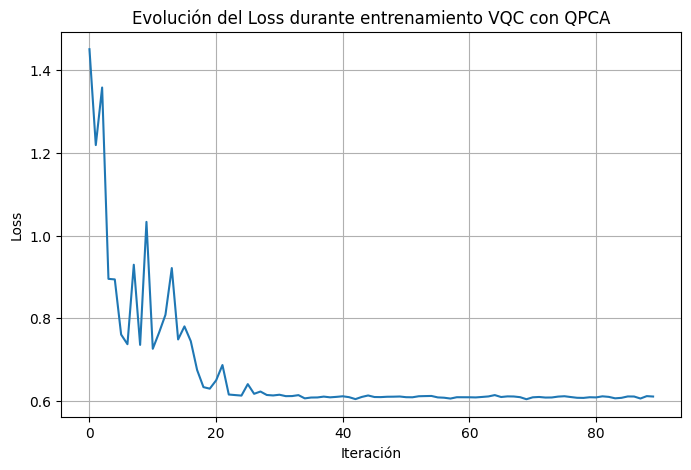

In [38]:
# Graficamos la evolución del loss
plt.figure(figsize=(8,5))
plt.plot(losses, linestyle='-')
plt.title('Evolución del Loss durante entrenamiento VQC con QPCA')
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [39]:
# Mostramos ahora los resultados.
y_pred = vqc.predict(x_test_scaled)

accuracy_vqc_qpca_500_1 = accuracy_score(y_test_1, y_pred)
precision_vqc_qpca_500_1 = precision_score(y_test_1, y_pred)
recall_vqc_qpca_500_1 = recall_score(y_test_1, y_pred)
f1_vqc_qpca_500_1 = f1_score(y_test_1, y_pred)

print("Accuracy:", accuracy_vqc_qpca_500_1)
print("Precisión:", precision_vqc_qpca_500_1)
print("Recall:", recall_vqc_qpca_500_1)
print("F1 score:", f1_vqc_qpca_500_1)
print(classification_report(y_test_1, y_pred))

Accuracy: 0.8066666666666666
Precisión: 0.5952380952380952
Recall: 0.6756756756756757
F1 score: 0.6329113924050633
              precision    recall  f1-score   support

         0.0       0.89      0.85      0.87       113
         1.0       0.60      0.68      0.63        37

    accuracy                           0.81       150
   macro avg       0.74      0.76      0.75       150
weighted avg       0.82      0.81      0.81       150



## Estudio Comparativo (Sin Desbalanceo, 2D)

In [40]:
# Crear muestras
df1 = crear_submuestra_balanceada(data_2, label_col='label', total_muestra=200, proporcion_clase_mayor=0.5)
df2 = crear_submuestra_balanceada(data_2, label_col='label', total_muestra=500, proporcion_clase_mayor=0.5)

### 200 datos

In [41]:
x1 = df1.drop(columns='is_fraud')
y1 = df1['is_fraud']

x1 = np.array(x1, dtype=np.float32)
y1 = np.array(y1, dtype=np.float32)

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(
    x1, y1, test_size=0.3, stratify=y1, random_state=42
)

#### PCA

In [42]:
# Creamos instancia de PCA para reducir a 2D.
pca = PCA(n_components=2)

# Transformamos los datos.
x_train_pca_1 = pca.fit_transform(x_train_1)
x_test_pca_1 = pca.transform(x_test_1)

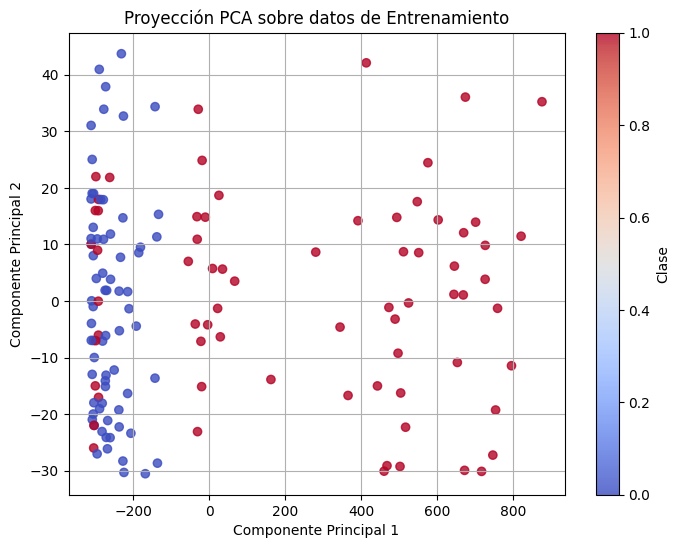

In [43]:
# Visualizamos los resultados.
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_train_pca_1[:, 0], x_train_pca_1[:, 1], c=y_train_1, cmap='coolwarm', alpha=0.8)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Proyección PCA sobre datos de Entrenamiento")
plt.colorbar(scatter, label='Clase')
plt.grid(True)
plt.show()

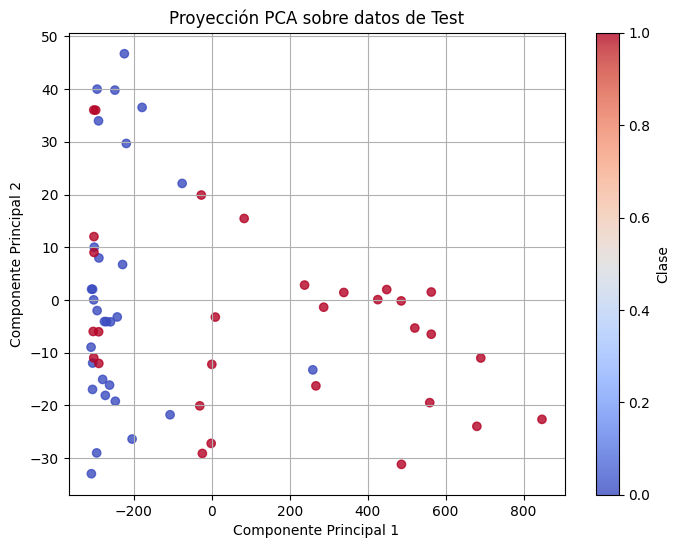

In [44]:
# Visualizamos los resultados.
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_test_pca_1[:, 0], x_test_pca_1[:, 1], c=y_test_1, cmap='coolwarm', alpha=0.8)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Proyección PCA sobre datos de Test")
plt.colorbar(scatter, label='Clase')
plt.grid(True)
plt.show()

#### QPCA

In [45]:
# Elegimos 3 qubits -> necesitamos vectores de dimensión 2^3 = 8
n_qubits = 3
state_dim = 2**n_qubits

# Padding de los datos de entrenamiento y test
x_train_1_padded = np.array([pad_vector(x, state_dim) for x in x_train_1])
x_test_1_padded = np.array([pad_vector(x, state_dim) for x in x_test_1])

# Creamos un dispositivo simulado de 3 qubits
dev = qml.device("default.qubit", wires=n_qubits, shots=5000)

# Definimos el circuito cuántico que mide PauliZ en cada qubit
@qml.qnode(dev)
def density_matrix_measurement(x):
    state_preparation(x)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Obtenemos la "proyección" de cada dato en el espacio cuántico
# Cada vector viene de una medida de 3 dimensiones (una por qubit)
train_meas = np.array([density_matrix_measurement(x) for x in x_train_1])
test_meas = np.array([density_matrix_measurement(x) for x in x_test_1])

# Calculamos la matriz de covarianza de las medidas cuánticas
cov_qpca = np.cov(train_meas.T)

# Obtenemos autovalores y autovectores (componentes principales)
eigenvalues, eigenvectors = np.linalg.eigh(cov_qpca)

# Ordenamos los vectores propios en orden descendente de autovalor
idx = np.argsort(-eigenvalues)
principal_components = eigenvectors[:, idx[:2]]

# Proyectamos las medidas cuánticas en las dos componentes principales
projections_train = train_meas @ principal_components
projections_test = test_meas @ principal_components

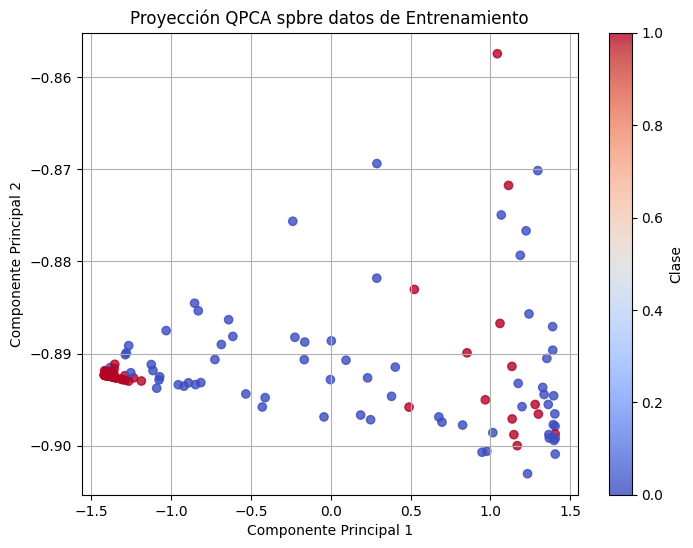

In [46]:
# Visualización de los resultados.
plt.figure(figsize=(8, 6))
scatter = plt.scatter(projections_train[:, 0], projections_train[:, 1], c=y_train_1, cmap='coolwarm', alpha=0.8)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Proyección QPCA spbre datos de Entrenamiento")
plt.colorbar(scatter, label='Clase')
plt.grid(True)
plt.show()

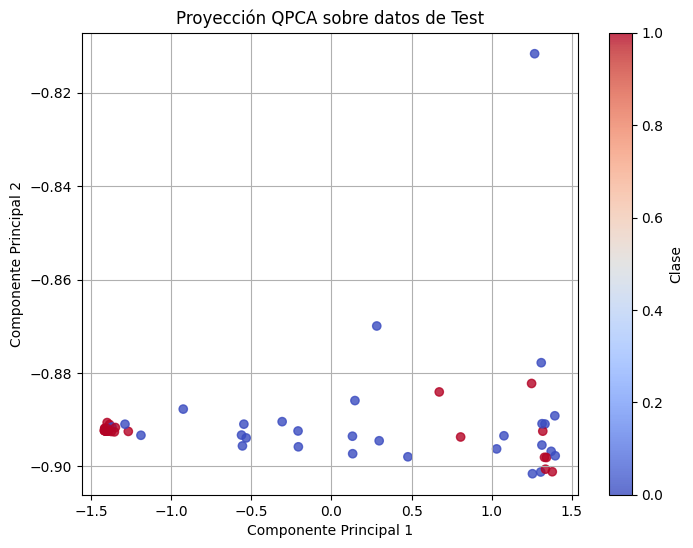

In [47]:
# Visualización de los resultados.
plt.figure(figsize=(8, 6))
scatter = plt.scatter(projections_test[:, 0], projections_test[:, 1], c=y_test_1, cmap='coolwarm', alpha=0.8)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Proyección QPCA sobre datos de Test")
plt.colorbar(scatter, label='Clase')
plt.grid(True)
plt.show()

#### Decision Tree (PCA)

In [48]:
# Entrenamos y evaluamos datos con PCA.
dt = DecisionTreeClassifier(random_state=17, max_depth=3)
dt.fit(x_train_pca_1, y_train_1)

y_pred_dtpca_1 = dt.predict(x_test_pca_1)

accuracy_dtpca_200_2 = accuracy_score(y_test_1, y_pred_dtpca_1)
precision_dtpca_200_2 = precision_score(y_test_1, y_pred_dtpca_1)
recall_dtpca_200_2 = recall_score(y_test_1, y_pred_dtpca_1)
f1_dtpca_200_2 = f1_score(y_test_1, y_pred_dtpca_1)

print(f"Accuracy Decision Tree con PCA: {accuracy_dtpca_200_2}")
print(f"Precisión Decision Tree con PCA: {precision_dtpca_200_2}")
print(f"Recall Decision Tree con PCA: {recall_dtpca_200_2}")
print(f"F1 Score Decision Tree con PCA: {f1_dtpca_200_2}")
print(classification_report(y_test_1, y_pred_dtpca_1))

Accuracy Decision Tree con PCA: 0.8
Precisión Decision Tree con PCA: 0.78125
Recall Decision Tree con PCA: 0.8333333333333334
F1 Score Decision Tree con PCA: 0.8064516129032258
              precision    recall  f1-score   support

         0.0       0.82      0.77      0.79        30
         1.0       0.78      0.83      0.81        30

    accuracy                           0.80        60
   macro avg       0.80      0.80      0.80        60
weighted avg       0.80      0.80      0.80        60



#### Decision Tree (QPCA)

In [49]:
# Ahora lo mismo para la versión con QPCA.
qdt = DecisionTreeClassifier(random_state=17, max_depth=3)
qdt.fit(projections_train, y_train_1)

y_pred_qdtpca_1 = qdt.predict(projections_test)

accuracy_qdtpca_200_2 = accuracy_score(y_test_1, y_pred_qdtpca_1)
precision_qdtpca_200_2 = precision_score(y_test_1, y_pred_qdtpca_1)
recall_qdtpca_200_2 = recall_score(y_test_1, y_pred_qdtpca_1)
f1_qdtpca_200_2 = f1_score(y_test_1, y_pred_qdtpca_1)

print(f"Accuracy Decision Tree con QPCA: {accuracy_qdtpca_200_2}")
print(f"Precisión Decision Tree con QPCA: {precision_qdtpca_200_2}")
print(f"Recall Decision Tree con QPCA: {recall_qdtpca_200_2}")
print(f"F1 Score Decision Tree con QPCA: {f1_qdtpca_200_2}")
print(classification_report(y_test_1, y_pred_qdtpca_1))

Accuracy Decision Tree con QPCA: 0.8
Precisión Decision Tree con QPCA: 0.8214285714285714
Recall Decision Tree con QPCA: 0.7666666666666667
F1 Score Decision Tree con QPCA: 0.7931034482758621
              precision    recall  f1-score   support

         0.0       0.78      0.83      0.81        30
         1.0       0.82      0.77      0.79        30

    accuracy                           0.80        60
   macro avg       0.80      0.80      0.80        60
weighted avg       0.80      0.80      0.80        60



#### VQC con COBYLA (PCA)

In [50]:
# Escalamos los datos entre 0 y 2 * pi por estar utilizando ángulos.
scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))
x_train_scaled = scaler.fit_transform(x_train_pca_1)
x_test_scaled = scaler.transform(x_test_pca_1)

# Definimos el mapa de características.
feature_map = ZZFeatureMap(feature_dimension=x_train_scaled.shape[1], reps=3)

# Y el ansatz.
ansatz = TwoLocal(num_qubits=x_train_scaled.shape[1], reps=3, rotation_blocks='ry', entanglement_blocks='cz')

# Usamos un sampler para el backend.
sampler = AerSampler()

losses = []

# Creamos el modelo VQC con COBYLA.
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=500),
    sampler=sampler,
    initial_point=np.random.rand(ansatz.num_parameters),
    callback=callback,
)

# Y entrenamos.
vqc.fit(x_train_scaled, y_train_1)

Loss: 1.0694
Loss: 1.0509
Loss: 1.2155
Loss: 1.1638
Loss: 1.0400
Loss: 1.2438
Loss: 1.0394
Loss: 1.1615
Loss: 1.0362
Loss: 1.4051
Loss: 1.1040
Loss: 1.0397
Loss: 1.0506
Loss: 1.0565
Loss: 1.0277
Loss: 1.0223
Loss: 1.0986
Loss: 1.0210
Loss: 1.0048
Loss: 1.0319
Loss: 1.0022
Loss: 1.0072
Loss: 1.0279
Loss: 1.0007
Loss: 1.0050
Loss: 1.0115
Loss: 1.0229
Loss: 1.0021
Loss: 1.0025
Loss: 1.0056
Loss: 1.0038
Loss: 1.0156
Loss: 1.0011
Loss: 1.0042
Loss: 1.0025
Loss: 1.0117
Loss: 1.0031
Loss: 1.0080
Loss: 1.0071
Loss: 1.0092
Loss: 1.0085
Loss: 1.0026
Loss: 1.0022
Loss: 1.0059
Loss: 0.9993
Loss: 1.0109
Loss: 1.0076
Loss: 1.0059
Loss: 1.0010
Loss: 1.0038
Loss: 1.0025
Loss: 1.0033
Loss: 1.0041
Loss: 1.0078
Loss: 1.0053
Loss: 1.0129
Loss: 1.0097
Loss: 1.0077
Loss: 0.9997
Loss: 1.0096
Loss: 1.0065
Loss: 1.0075
Loss: 1.0050
Loss: 1.0082
Loss: 1.0047
Loss: 1.0000
Loss: 1.0045
Loss: 1.0043
Loss: 1.0089
Loss: 1.0112
Loss: 1.0117
Loss: 1.0108
Loss: 1.0079
Loss: 1.0082
Loss: 1.0087
Loss: 1.0052
Loss: 1.0036

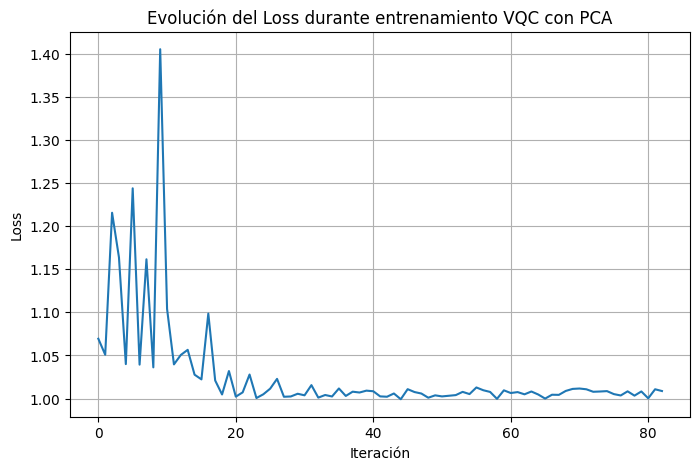

In [51]:
# Graficamos la evolución del loss
plt.figure(figsize=(8,5))
plt.plot(losses, linestyle='-')
plt.title('Evolución del Loss durante entrenamiento VQC con PCA')
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [52]:
# Mostramos ahora los resultados.
y_pred = vqc.predict(x_test_scaled)

accuracy_vqc_pca_200_2 = accuracy_score(y_test_1, y_pred)
precision_vqc_pca_200_2 = precision_score(y_test_1, y_pred)
recall_vqc_pca_200_2 = recall_score(y_test_1, y_pred)
f1_vqc_pca_200_2 = f1_score(y_test_1, y_pred)

print("Accuracy:", accuracy_vqc_pca_200_2)
print("Precisión:", precision_vqc_pca_200_2)
print("Recall:", recall_vqc_pca_200_2)
print("F1 score:", f1_vqc_pca_200_2)
print(classification_report(y_test_1, y_pred))

Accuracy: 0.5166666666666667
Precisión: 0.5151515151515151
Recall: 0.5666666666666667
F1 score: 0.5396825396825397
              precision    recall  f1-score   support

         0.0       0.52      0.47      0.49        30
         1.0       0.52      0.57      0.54        30

    accuracy                           0.52        60
   macro avg       0.52      0.52      0.52        60
weighted avg       0.52      0.52      0.52        60



#### VQC con COBYLA (QPCA)

In [53]:
# Escalamos los datos entre 0 y 2 * pi por estar utilizando ángulos.
scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))
x_train_scaled = scaler.fit_transform(projections_train)
x_test_scaled = scaler.transform(projections_test)

# Definimos el mapa de características.
feature_map = ZZFeatureMap(feature_dimension=x_train_scaled.shape[1], reps=3)

# Y el ansatz.
ansatz = TwoLocal(num_qubits=x_train_scaled.shape[1], reps=3, rotation_blocks='ry', entanglement_blocks='cz')

# Usamos un sampler para el backend.
sampler = AerSampler()

losses = []

# Creamos el modelo VQC con COBYLA.
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=500),
    sampler=sampler,
    initial_point=np.random.rand(ansatz.num_parameters),
    callback=callback,
)

# Y entrenamos.
vqc.fit(x_train_scaled, y_train_1)

Loss: 1.4125
Loss: 1.0430
Loss: 1.0417
Loss: 1.5645
Loss: 1.1109
Loss: 0.9420
Loss: 0.9935
Loss: 1.0162
Loss: 0.9383
Loss: 0.9369
Loss: 0.9755
Loss: 0.9747
Loss: 0.9701
Loss: 0.9459
Loss: 0.9477
Loss: 0.9134
Loss: 0.9046
Loss: 0.8937
Loss: 0.8910
Loss: 0.8952
Loss: 1.0769
Loss: 0.8888
Loss: 0.9509
Loss: 0.8903
Loss: 0.8898
Loss: 0.8932
Loss: 0.8844
Loss: 0.8760
Loss: 0.8735
Loss: 0.9074
Loss: 0.8715
Loss: 0.8681
Loss: 0.8701
Loss: 0.8658
Loss: 0.8662
Loss: 0.8777
Loss: 0.8713
Loss: 0.8733
Loss: 0.8669
Loss: 0.8639
Loss: 0.8629
Loss: 0.8630
Loss: 0.8725
Loss: 0.8623
Loss: 0.8617
Loss: 0.8707
Loss: 0.8640
Loss: 0.8691
Loss: 0.8660
Loss: 0.8684
Loss: 0.8685
Loss: 0.8683
Loss: 0.8715
Loss: 0.8751
Loss: 0.8732
Loss: 0.8678
Loss: 0.8706
Loss: 0.8642
Loss: 0.8628
Loss: 0.8635
Loss: 0.8675
Loss: 0.8648
Loss: 0.8690
Loss: 0.8712
Loss: 0.8695
Loss: 0.8564
Loss: 0.8701
Loss: 0.8680
Loss: 0.8592
Loss: 0.8667
Loss: 0.8634
Loss: 0.8647
Loss: 0.8627
Loss: 0.8708
Loss: 0.8641
Loss: 0.8720
Loss: 0.8688

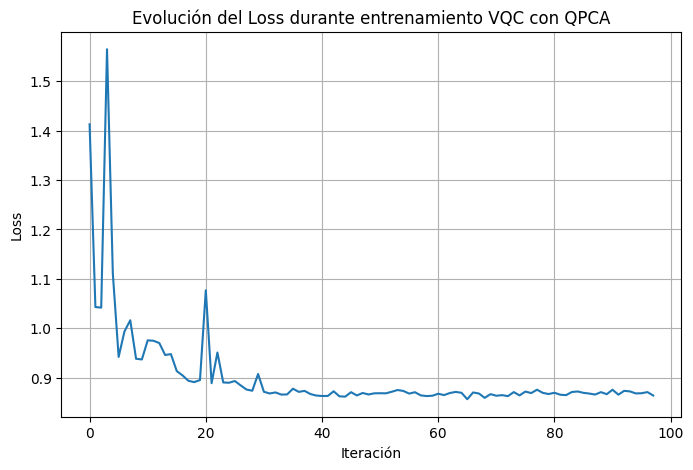

In [54]:
# Graficamos la evolución del loss
plt.figure(figsize=(8,5))
plt.plot(losses, linestyle='-')
plt.title('Evolución del Loss durante entrenamiento VQC con QPCA')
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [55]:
# Mostramos ahora los resultados.
y_pred = vqc.predict(x_test_scaled)

accuracy_vqc_qpca_200_2 = accuracy_score(y_test_1, y_pred)
precision_vqc_qpca_200_2 = precision_score(y_test_1, y_pred)
recall_vqc_qpca_200_2 = recall_score(y_test_1, y_pred)
f1_vqc_qpca_200_2 = f1_score(y_test_1, y_pred)

print("Accuracy:", accuracy_vqc_qpca_200_2)
print("Precisión:", precision_vqc_qpca_200_2)
print("Recall:", recall_vqc_qpca_200_2)
print("F1 score:", f1_vqc_qpca_200_2)
print(classification_report(y_test_1, y_pred))

Accuracy: 0.6
Precisión: 0.56
Recall: 0.9333333333333333
F1 score: 0.7
              precision    recall  f1-score   support

         0.0       0.80      0.27      0.40        30
         1.0       0.56      0.93      0.70        30

    accuracy                           0.60        60
   macro avg       0.68      0.60      0.55        60
weighted avg       0.68      0.60      0.55        60



### 500 datos

In [56]:
x1 = df2.drop(columns='is_fraud')
y1 = df2['is_fraud']

x1 = np.array(x1, dtype=np.float32)
y1 = np.array(y1, dtype=np.float32)

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(
    x1, y1, test_size=0.3, stratify=y1, random_state=42
)

#### PCA

In [57]:
# Creamos instancia de PCA para reducir a 2D.
pca = PCA(n_components=2)

# Transformamos los datos.
x_train_pca_1 = pca.fit_transform(x_train_1)
x_test_pca_1 = pca.transform(x_test_1)

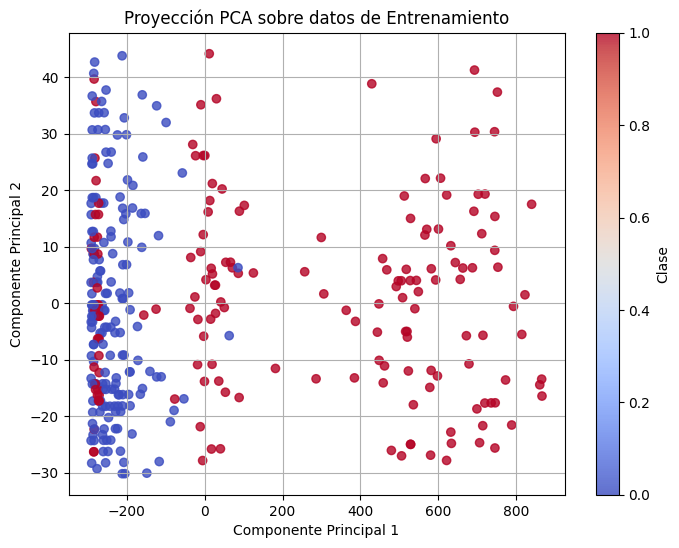

In [58]:
# Visualizamos los resultados.
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_train_pca_1[:, 0], x_train_pca_1[:, 1], c=y_train_1, cmap='coolwarm', alpha=0.8)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Proyección PCA sobre datos de Entrenamiento")
plt.colorbar(scatter, label='Clase')
plt.grid(True)
plt.show()

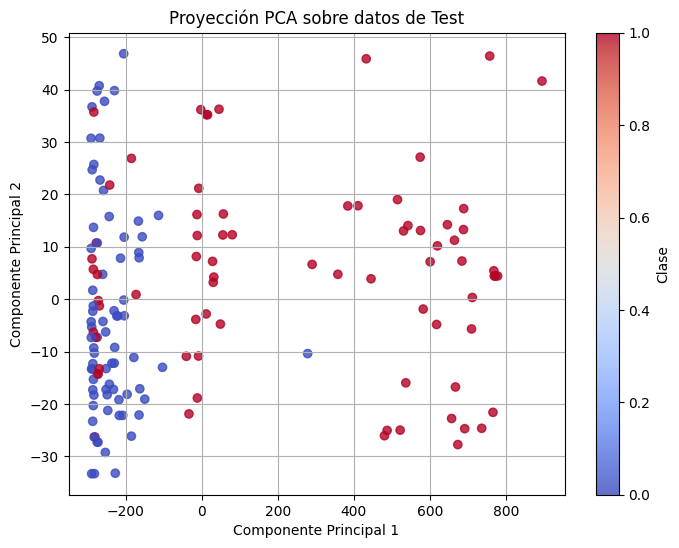

In [59]:
# Visualizamos los resultados.
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_test_pca_1[:, 0], x_test_pca_1[:, 1], c=y_test_1, cmap='coolwarm', alpha=0.8)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Proyección PCA sobre datos de Test")
plt.colorbar(scatter, label='Clase')
plt.grid(True)
plt.show()

#### QPCA

In [60]:
# Elegimos 3 qubits -> necesitamos vectores de dimensión 2^3 = 8
n_qubits = 3
state_dim = 2**n_qubits

# Padding de los datos de entrenamiento y test
x_train_1_padded = np.array([pad_vector(x, state_dim) for x in x_train_1])
x_test_1_padded = np.array([pad_vector(x, state_dim) for x in x_test_1])

# Creamos un dispositivo simulado de 3 qubits
dev = qml.device("default.qubit", wires=n_qubits, shots=5000)

# Definimos el circuito cuántico que mide PauliZ en cada qubit
@qml.qnode(dev)
def density_matrix_measurement(x):
    state_preparation(x)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Obtenemos la "proyección" de cada dato en el espacio cuántico
# Cada vector viene de una medida de 3 dimensiones (una por qubit)
train_meas = np.array([density_matrix_measurement(x) for x in x_train_1])
test_meas = np.array([density_matrix_measurement(x) for x in x_test_1])

# Calculamos la matriz de covarianza de las medidas cuánticas
cov_qpca = np.cov(train_meas.T)

# Obtenemos autovalores y autovectores (componentes principales)
eigenvalues, eigenvectors = np.linalg.eigh(cov_qpca)

# Ordenamos los vectores propios en orden descendente de autovalor
idx = np.argsort(-eigenvalues)
principal_components = eigenvectors[:, idx[:2]]

# Proyectamos las medidas cuánticas en las dos componentes principales
projections_train = train_meas @ principal_components
projections_test = test_meas @ principal_components

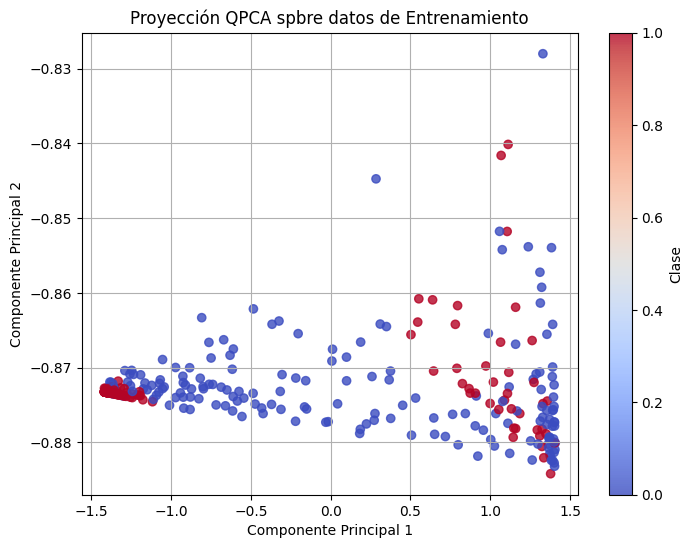

In [61]:
# Visualización de los resultados.
plt.figure(figsize=(8, 6))
scatter = plt.scatter(projections_train[:, 0], projections_train[:, 1], c=y_train_1, cmap='coolwarm', alpha=0.8)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Proyección QPCA spbre datos de Entrenamiento")
plt.colorbar(scatter, label='Clase')
plt.grid(True)
plt.show()

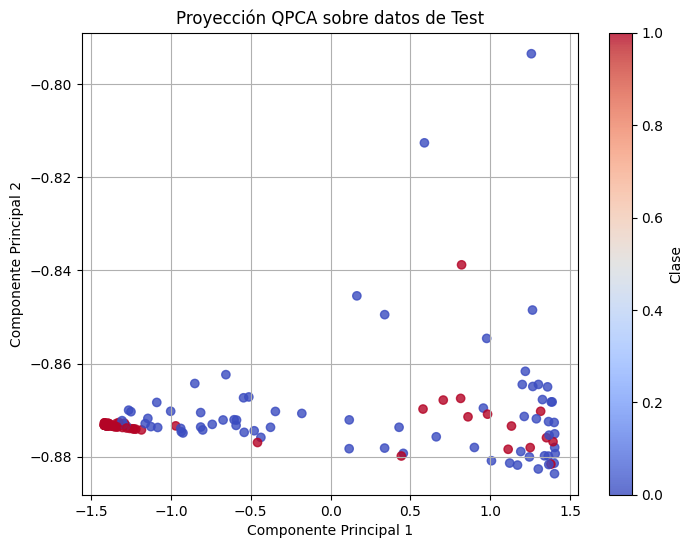

In [62]:
# Visualización de los resultados.
plt.figure(figsize=(8, 6))
scatter = plt.scatter(projections_test[:, 0], projections_test[:, 1], c=y_test_1, cmap='coolwarm', alpha=0.8)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Proyección QPCA sobre datos de Test")
plt.colorbar(scatter, label='Clase')
plt.grid(True)
plt.show()

#### Decision Tree (PCA)

In [63]:
# Entrenamos y evaluamos datos con PCA.
dt = DecisionTreeClassifier(random_state=17, max_depth=3)
dt.fit(x_train_pca_1, y_train_1)

y_pred_dtpca_1 = dt.predict(x_test_pca_1)

accuracy_dtpca_500_2 = accuracy_score(y_test_1, y_pred_dtpca_1)
precision_dtpca_500_2 = precision_score(y_test_1, y_pred_dtpca_1)
recall_dtpca_500_2 = recall_score(y_test_1, y_pred_dtpca_1)
f1_dtpca_500_2 = f1_score(y_test_1, y_pred_dtpca_1)

print(f"Accuracy Decision Tree con PCA: {accuracy_dtpca_500_2}")
print(f"Precisión Decision Tree con PCA: {precision_dtpca_500_2}")
print(f"Recall Decision Tree con PCA: {recall_dtpca_500_2}")
print(f"F1 Score Decision Tree con PCA: {f1_dtpca_500_2}")
print(classification_report(y_test_1, y_pred_dtpca_1))

Accuracy Decision Tree con PCA: 0.86
Precisión Decision Tree con PCA: 0.8214285714285714
Recall Decision Tree con PCA: 0.92
F1 Score Decision Tree con PCA: 0.8679245283018868
              precision    recall  f1-score   support

         0.0       0.91      0.80      0.85        75
         1.0       0.82      0.92      0.87        75

    accuracy                           0.86       150
   macro avg       0.87      0.86      0.86       150
weighted avg       0.87      0.86      0.86       150



#### Decision Tree (QPCA)

In [64]:
# Ahora lo mismo para la versión con QPCA.
qdt = DecisionTreeClassifier(random_state=17, max_depth=3)
qdt.fit(projections_train, y_train_1)

y_pred_qdtpca_1 = qdt.predict(projections_test)

accuracy_qdtpca_500_2 = accuracy_score(y_test_1, y_pred_qdtpca_1)
precision_qdtpca_500_2 = precision_score(y_test_1, y_pred_qdtpca_1)
recall_qdtpca_500_2 = recall_score(y_test_1, y_pred_qdtpca_1)
f1_qdtpca_500_2 = f1_score(y_test_1, y_pred_qdtpca_1)

print(f"Accuracy Decision Tree con QPCA: {accuracy_qdtpca_500_2}")
print(f"Precisión Decision Tree con QPCA: {precision_qdtpca_500_2}")
print(f"Recall Decision Tree con QPCA: {recall_qdtpca_500_2}")
print(f"F1 Score Decision Tree con QPCA: {f1_qdtpca_500_2}")
print(classification_report(y_test_1, y_pred_qdtpca_1))

Accuracy Decision Tree con QPCA: 0.8533333333333334
Precisión Decision Tree con QPCA: 0.9076923076923077
Recall Decision Tree con QPCA: 0.7866666666666666
F1 Score Decision Tree con QPCA: 0.8428571428571429
              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86        75
         1.0       0.91      0.79      0.84        75

    accuracy                           0.85       150
   macro avg       0.86      0.85      0.85       150
weighted avg       0.86      0.85      0.85       150



#### VQC con COBYLA (PCA)

In [65]:
# Escalamos los datos entre 0 y 2 * pi por estar utilizando ángulos.
scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))
x_train_scaled = scaler.fit_transform(x_train_pca_1)
x_test_scaled = scaler.transform(x_test_pca_1)

# Definimos el mapa de características.
feature_map = ZZFeatureMap(feature_dimension=x_train_scaled.shape[1], reps=3)

# Y el ansatz.
ansatz = TwoLocal(num_qubits=x_train_scaled.shape[1], reps=3, rotation_blocks='ry', entanglement_blocks='cz')

# Usamos un sampler para el backend.
sampler = AerSampler()

losses = []

# Creamos el modelo VQC con COBYLA.
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=500),
    sampler=sampler,
    initial_point=np.random.rand(ansatz.num_parameters),
    callback=callback,
)

# Y entrenamos.
vqc.fit(x_train_scaled, y_train_1)

Loss: 1.0588
Loss: 1.1234
Loss: 1.0889
Loss: 1.1574
Loss: 1.0947
Loss: 0.9724
Loss: 1.0450
Loss: 1.1737
Loss: 0.9752
Loss: 1.3749
Loss: 1.0041
Loss: 0.9816
Loss: 0.9951
Loss: 1.0200
Loss: 0.9806
Loss: 0.9785
Loss: 0.9748
Loss: 0.9705
Loss: 1.0023
Loss: 0.9706
Loss: 0.9762
Loss: 0.9714
Loss: 0.9734
Loss: 0.9772
Loss: 0.9747
Loss: 0.9743
Loss: 0.9712
Loss: 0.9749
Loss: 0.9731
Loss: 0.9706
Loss: 0.9735
Loss: 0.9713
Loss: 0.9734
Loss: 0.9755
Loss: 0.9729
Loss: 0.9712
Loss: 0.9706
Loss: 0.9757
Loss: 0.9725
Loss: 0.9718
Loss: 0.9764
Loss: 0.9765
Loss: 0.9695
Loss: 0.9750
Loss: 0.9748
Loss: 0.9722
Loss: 0.9726
Loss: 0.9769
Loss: 0.9698
Loss: 0.9693
Loss: 0.9699
Loss: 0.9684
Loss: 0.9721
Loss: 0.9755
Loss: 0.9747
Loss: 0.9713
Loss: 0.9659
Loss: 0.9725
Loss: 0.9731
Loss: 0.9703
Loss: 0.9691
Loss: 0.9724
Loss: 0.9735
Loss: 0.9700
Loss: 0.9723
Loss: 0.9737
Loss: 0.9766
Loss: 0.9722
Loss: 0.9727
Loss: 0.9740
Loss: 0.9754
Loss: 0.9723
Loss: 0.9732
Loss: 0.9722
Loss: 0.9722
Loss: 0.9714
Loss: 0.9720

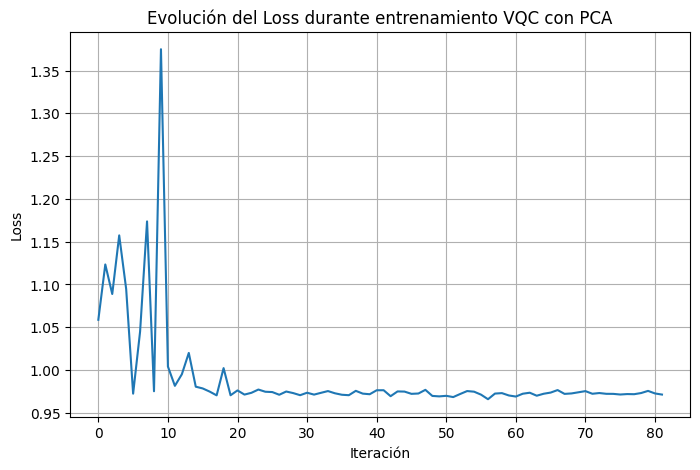

In [66]:
# Graficamos la evolución del loss
plt.figure(figsize=(8,5))
plt.plot(losses, linestyle='-')
plt.title('Evolución del Loss durante entrenamiento VQC con PCA')
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [67]:
# Mostramos ahora los resultados.
y_pred = vqc.predict(x_test_scaled)

accuracy_vqc_pca_500_2 = accuracy_score(y_test_1, y_pred)
precision_vqc_pca_500_2 = precision_score(y_test_1, y_pred)
recall_vqc_pca_500_2 = recall_score(y_test_1, y_pred)
f1_vqc_pca_500_2 = f1_score(y_test_1, y_pred)

print("Accuracy:", accuracy_vqc_pca_500_2)
print("Precisión:", precision_vqc_pca_500_2)
print("Recall:", recall_vqc_pca_500_2)
print("F1 score:", f1_vqc_pca_500_2)
print(classification_report(y_test_1, y_pred))

Accuracy: 0.6066666666666667
Precisión: 0.6025641025641025
Recall: 0.6266666666666667
F1 score: 0.6143790849673203
              precision    recall  f1-score   support

         0.0       0.61      0.59      0.60        75
         1.0       0.60      0.63      0.61        75

    accuracy                           0.61       150
   macro avg       0.61      0.61      0.61       150
weighted avg       0.61      0.61      0.61       150



#### VQC con COBYLA (QPCA)

In [68]:
# Escalamos los datos entre 0 y 2 * pi por estar utilizando ángulos.
scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))
x_train_scaled = scaler.fit_transform(projections_train)
x_test_scaled = scaler.transform(projections_test)

# Definimos el mapa de características.
feature_map = ZZFeatureMap(feature_dimension=x_train_scaled.shape[1], reps=3)

# Y el ansatz.
ansatz = TwoLocal(num_qubits=x_train_scaled.shape[1], reps=3, rotation_blocks='ry', entanglement_blocks='cz')

# Usamos un sampler para el backend.
sampler = AerSampler()

losses = []

# Creamos el modelo VQC con COBYLA.
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=500),
    sampler=sampler,
    initial_point=np.random.rand(ansatz.num_parameters),
    callback=callback,
)

# Y entrenamos.
vqc.fit(x_train_scaled, y_train_1)

Loss: 1.0215
Loss: 1.1000
Loss: 1.0204
Loss: 1.5335
Loss: 1.4101
Loss: 0.9721
Loss: 1.0803
Loss: 1.0537
Loss: 0.9755
Loss: 1.3943
Loss: 0.9371
Loss: 0.9475
Loss: 1.0411
Loss: 0.9310
Loss: 1.0046
Loss: 0.9457
Loss: 0.9455
Loss: 0.9263
Loss: 0.9950
Loss: 0.9470
Loss: 0.9750
Loss: 0.9438
Loss: 0.9300
Loss: 0.9369
Loss: 0.9293
Loss: 0.9298
Loss: 0.9355
Loss: 0.9274
Loss: 0.9296
Loss: 0.9309
Loss: 0.9199
Loss: 0.9234
Loss: 0.9215
Loss: 0.9271
Loss: 0.9301
Loss: 0.9262
Loss: 0.9291
Loss: 0.9265
Loss: 0.9243
Loss: 0.9293
Loss: 0.9249
Loss: 0.9281
Loss: 0.9300
Loss: 0.9291
Loss: 0.9298
Loss: 0.9298
Loss: 0.9263
Loss: 0.9281
Loss: 0.9263
Loss: 0.9259
Loss: 0.9250
Loss: 0.9309
Loss: 0.9242
Loss: 0.9256
Loss: 0.9316
Loss: 0.9259
Loss: 0.9295
Loss: 0.9313
Loss: 0.9309
Loss: 0.9276
Loss: 0.9314
Loss: 0.9233
Loss: 0.9279
Loss: 0.9257
Loss: 0.9275
Loss: 0.9290
Loss: 0.9275
Loss: 0.9224
Loss: 0.9270
Loss: 0.9232
Loss: 0.9278
Loss: 0.9275
Loss: 0.9275
Loss: 0.9284
Loss: 0.9277


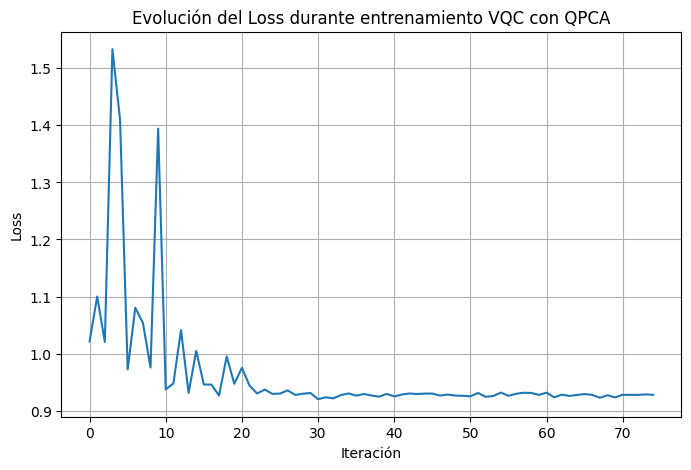

In [69]:
# Graficamos la evolución del loss
plt.figure(figsize=(8,5))
plt.plot(losses, linestyle='-')
plt.title('Evolución del Loss durante entrenamiento VQC con QPCA')
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [70]:
# Mostramos ahora los resultados.
y_pred = vqc.predict(x_test_scaled)

accuracy_vqc_qpca_500_2 = accuracy_score(y_test_1, y_pred)
precision_vqc_qpca_500_2 = precision_score(y_test_1, y_pred)
recall_vqc_qpca_500_2 = recall_score(y_test_1, y_pred)
f1_vqc_qpca_500_2 = f1_score(y_test_1, y_pred)

print("Accuracy:", accuracy_vqc_qpca_500_2)
print("Precisión:", precision_vqc_qpca_500_2)
print("Recall:", recall_vqc_qpca_500_2)
print("F1 score:", f1_vqc_qpca_500_2)
print(classification_report(y_test_1, y_pred))

Accuracy: 0.64
Precisión: 0.5963302752293578
Recall: 0.8666666666666667
F1 score: 0.7065217391304348
              precision    recall  f1-score   support

         0.0       0.76      0.41      0.53        75
         1.0       0.60      0.87      0.71        75

    accuracy                           0.64       150
   macro avg       0.68      0.64      0.62       150
weighted avg       0.68      0.64      0.62       150



## Estudio Comparativo (Desbalanceo 75-25, 3D)

In [71]:
# Crear muestras
df1 = crear_submuestra_balanceada(data_2, label_col='label', total_muestra=200, proporcion_clase_mayor=0.5)
df2 = crear_submuestra_balanceada(data_2, label_col='label', total_muestra=500, proporcion_clase_mayor=0.5)

### 200 datos

In [72]:
x1 = df1.drop(columns='is_fraud')
y1 = df1['is_fraud']

x1 = np.array(x1, dtype=np.float32)
y1 = np.array(y1, dtype=np.float32)

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(
    x1, y1, test_size=0.3, stratify=y1, random_state=42
)

#### PCA

In [73]:
# Creamos instancia de PCA para reducir a 2D.
pca = PCA(n_components=3)

# Transformamos los datos.
x_train_pca_1 = pca.fit_transform(x_train_1)
x_test_pca_1 = pca.transform(x_test_1)

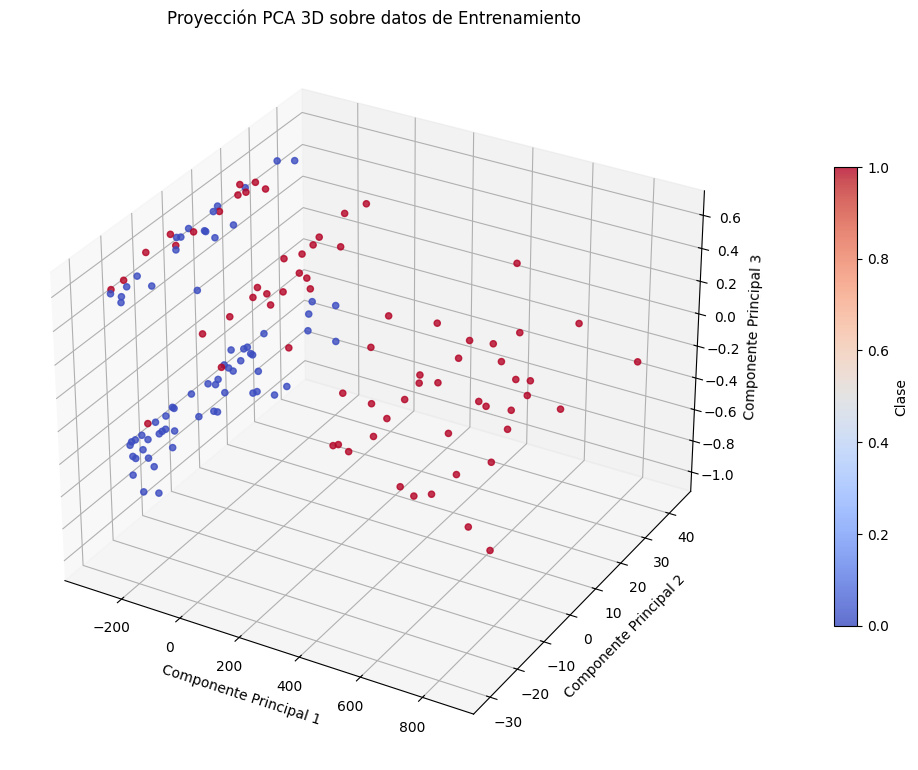

In [74]:
from mpl_toolkits.mplot3d import Axes3D

# Visualización de resultados.
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Gráfico de dispersión en 3D
scatter = ax.scatter(
    x_train_pca_1[:, 0],
    x_train_pca_1[:, 1],
    x_train_pca_1[:, 2],
    c=y_train_1,
    cmap='coolwarm',
    alpha=0.8
)

# Etiquetas de ejes
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
ax.set_title("Proyección PCA 3D sobre datos de Entrenamiento")

# Barra de color
cbar = plt.colorbar(scatter, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label("Clase")

plt.grid(True)
plt.tight_layout()
plt.show()

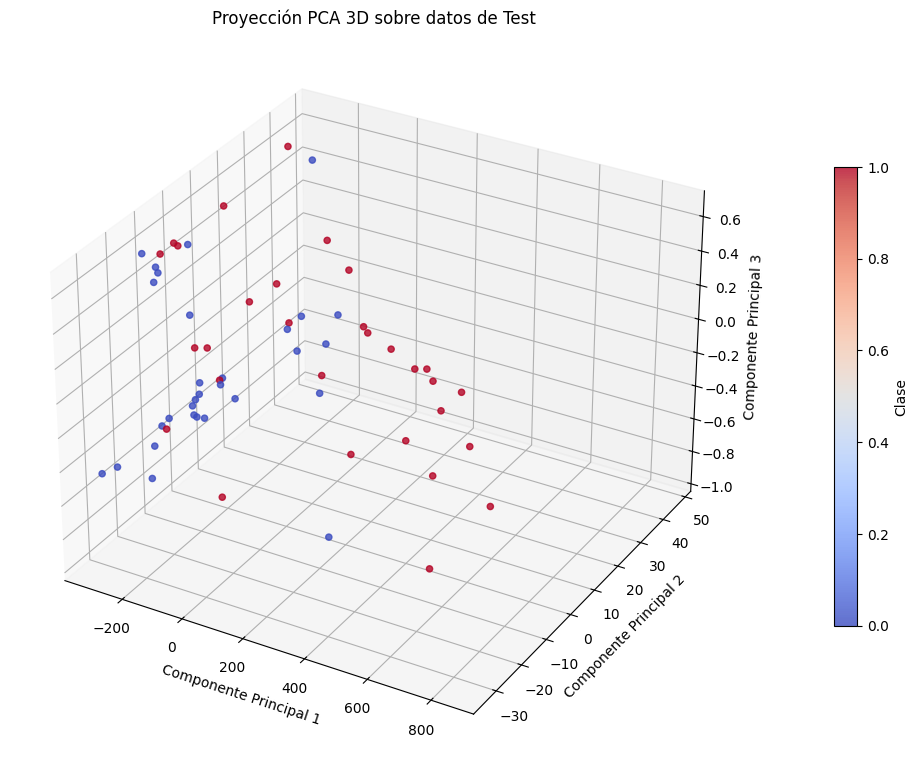

In [75]:
# Visualización de resultados.
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Gráfico de dispersión en 3D
scatter = ax.scatter(
    x_test_pca_1[:, 0],
    x_test_pca_1[:, 1],
    x_test_pca_1[:, 2],
    c=y_test_1,
    cmap='coolwarm',
    alpha=0.8
)

# Etiquetas de ejes
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
ax.set_title("Proyección PCA 3D sobre datos de Test")

# Barra de color
cbar = plt.colorbar(scatter, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label("Clase")

plt.grid(True)
plt.tight_layout()
plt.show()

#### QPCA

In [76]:
# Elegimos 3 qubits -> necesitamos vectores de dimensión 2^3 = 8
n_qubits = 3
state_dim = 2**n_qubits

# Padding de los datos de entrenamiento y test
x_train_1_padded = np.array([pad_vector(x, state_dim) for x in x_train_1])
x_test_1_padded = np.array([pad_vector(x, state_dim) for x in x_test_1])

# Creamos un dispositivo simulado de 3 qubits
dev = qml.device("default.qubit", wires=n_qubits, shots=5000)

# Definimos el circuito cuántico que mide PauliZ en cada qubit
@qml.qnode(dev)
def density_matrix_measurement(x):
    state_preparation(x)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Obtenemos la "proyección" de cada dato en el espacio cuántico
# Cada vector viene de una medida de 3 dimensiones (una por qubit)
train_meas = np.array([density_matrix_measurement(x) for x in x_train_1])
test_meas = np.array([density_matrix_measurement(x) for x in x_test_1])

# Calculamos la matriz de covarianza de las medidas cuánticas
cov_qpca = np.cov(train_meas.T)

# Obtenemos autovalores y autovectores (componentes principales)
eigenvalues, eigenvectors = np.linalg.eigh(cov_qpca)

# Ordenamos los vectores propios en orden descendente de autovalor
idx = np.argsort(-eigenvalues)
principal_components = eigenvectors[:, idx[:3]]

# Proyectamos las medidas cuánticas en las dos componentes principales
projections_train = train_meas @ principal_components
projections_test = test_meas @ principal_components

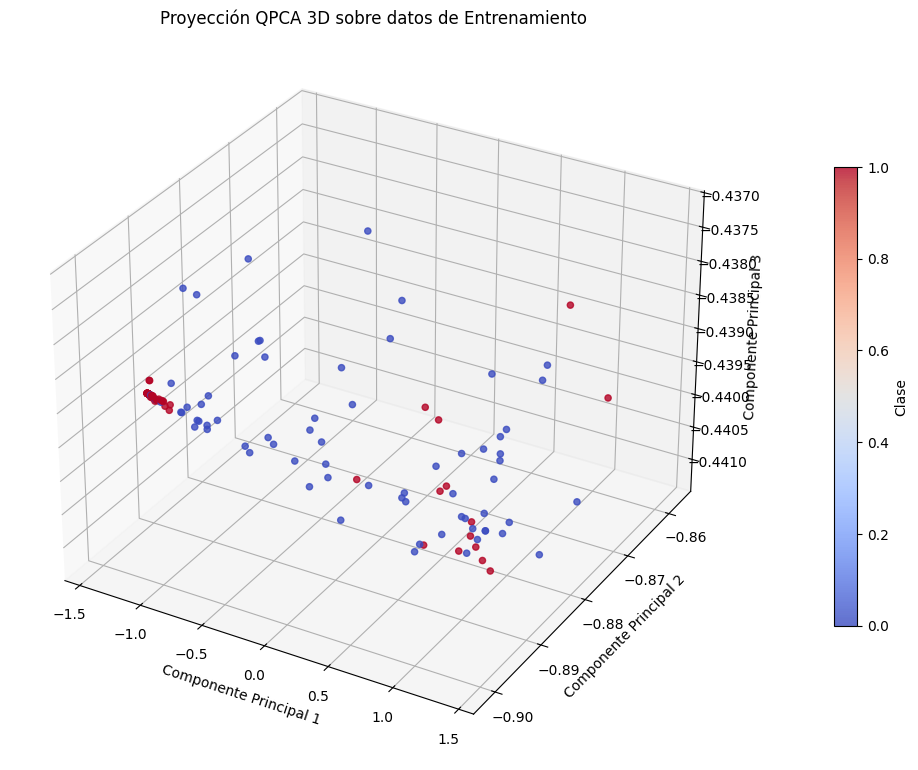

In [77]:
# Visualización de resultados.
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Gráfico de dispersión en 3D
scatter = ax.scatter(
    projections_train[:, 0],
    projections_train[:, 1],
    projections_train[:, 2],
    c=y_train_1,
    cmap='coolwarm',
    alpha=0.8
)

# Etiquetas de ejes
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
ax.set_title("Proyección QPCA 3D sobre datos de Entrenamiento")

# Barra de color
cbar = plt.colorbar(scatter, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label("Clase")

plt.grid(True)
plt.tight_layout()
plt.show()

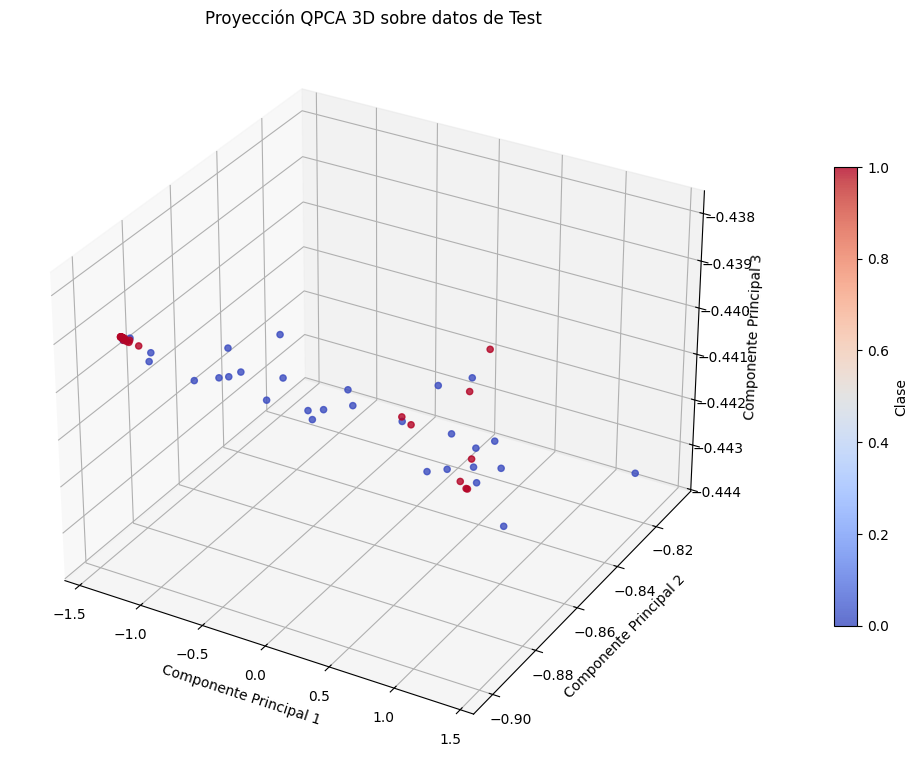

In [78]:
# Visualización de resultados.
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Gráfico de dispersión en 3D
scatter = ax.scatter(
    projections_test[:, 0],
    projections_test[:, 1],
    projections_test[:, 2],
    c=y_test_1,
    cmap='coolwarm',
    alpha=0.8
)

# Etiquetas de ejes
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
ax.set_title("Proyección QPCA 3D sobre datos de Test")

# Barra de color
cbar = plt.colorbar(scatter, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label("Clase")

plt.grid(True)
plt.tight_layout()
plt.show()

#### Decision Tree (PCA)

In [79]:
# Entrenamos y evaluamos datos con PCA.
dt = DecisionTreeClassifier(random_state=17, max_depth=3)
dt.fit(x_train_pca_1, y_train_1)

y_pred_dtpca_1 = dt.predict(x_test_pca_1)

accuracy_dtpca_200_3 = accuracy_score(y_test_1, y_pred_dtpca_1)
precision_dtpca_200_3 = precision_score(y_test_1, y_pred_dtpca_1)
recall_dtpca_200_3 = recall_score(y_test_1, y_pred_dtpca_1)
f1_dtpca_200_3 = f1_score(y_test_1, y_pred_dtpca_1)

print(f"Accuracy Decision Tree con PCA: {accuracy_dtpca_200_3}")
print(f"Precisión Decision Tree con PCA: {precision_dtpca_200_3}")
print(f"Recall Decision Tree con PCA: {recall_dtpca_200_3}")
print(f"F1 Score Decision Tree con PCA: {f1_dtpca_200_3}")
print(classification_report(y_test_1, y_pred_dtpca_1))

Accuracy Decision Tree con PCA: 0.9
Precisión Decision Tree con PCA: 0.9285714285714286
Recall Decision Tree con PCA: 0.8666666666666667
F1 Score Decision Tree con PCA: 0.896551724137931
              precision    recall  f1-score   support

         0.0       0.88      0.93      0.90        30
         1.0       0.93      0.87      0.90        30

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



#### Decision Tree (QPCA)

In [80]:
# Ahora lo mismo para la versión con QPCA.
qdt = DecisionTreeClassifier(random_state=17, max_depth=3)
qdt.fit(projections_train, y_train_1)

y_pred_qdtpca_1 = qdt.predict(projections_test)

accuracy_qdtpca_200_3 = accuracy_score(y_test_1, y_pred_qdtpca_1)
precision_qdtpca_200_3 = precision_score(y_test_1, y_pred_qdtpca_1)
recall_qdtpca_200_3 = recall_score(y_test_1, y_pred_qdtpca_1)
f1_qdtpca_200_3 = f1_score(y_test_1, y_pred_qdtpca_1)

print(f"Accuracy Decision Tree con QPCA: {accuracy_qdtpca_200_3}")
print(f"Precisión Decision Tree con QPCA: {precision_qdtpca_200_3}")
print(f"Recall Decision Tree con QPCA: {recall_qdtpca_200_3}")
print(f"F1 Score Decision Tree con QPCA: {f1_qdtpca_200_3}")
print(classification_report(y_test_1, y_pred_qdtpca_1))

Accuracy Decision Tree con QPCA: 0.8333333333333334
Precisión Decision Tree con QPCA: 0.8846153846153846
Recall Decision Tree con QPCA: 0.7666666666666667
F1 Score Decision Tree con QPCA: 0.8214285714285714
              precision    recall  f1-score   support

         0.0       0.79      0.90      0.84        30
         1.0       0.88      0.77      0.82        30

    accuracy                           0.83        60
   macro avg       0.84      0.83      0.83        60
weighted avg       0.84      0.83      0.83        60



#### VQC con COBYLA (PCA)

In [81]:
# Escalamos los datos entre 0 y 2 * pi por estar utilizando ángulos.
scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))
x_train_scaled = scaler.fit_transform(x_train_pca_1)
x_test_scaled = scaler.transform(x_test_pca_1)

# Definimos el mapa de características.
feature_map = ZZFeatureMap(feature_dimension=x_train_scaled.shape[1], reps=3)

# Y el ansatz.
ansatz = TwoLocal(num_qubits=x_train_scaled.shape[1], reps=3, rotation_blocks='ry', entanglement_blocks='cz')

# Usamos un sampler para el backend.
sampler = AerSampler()

losses = []

# Creamos el modelo VQC con COBYLA.
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=500),
    sampler=sampler,
    initial_point=np.random.rand(ansatz.num_parameters),
    callback=callback,
)

# Y entrenamos.
vqc.fit(x_train_scaled, y_train_1)

Loss: 1.0585
Loss: 1.0719
Loss: 1.0243
Loss: 1.1205
Loss: 0.9972
Loss: 1.0271
Loss: 1.0443
Loss: 1.1858
Loss: 0.9981
Loss: 1.0258
Loss: 1.1052
Loss: 0.9981
Loss: 0.9999
Loss: 0.9569
Loss: 0.9995
Loss: 0.9860
Loss: 0.9794
Loss: 0.9926
Loss: 0.9536
Loss: 0.9834
Loss: 0.9610
Loss: 0.9574
Loss: 0.9515
Loss: 0.9601
Loss: 0.9502
Loss: 0.9593
Loss: 0.9535
Loss: 0.9535
Loss: 0.9514
Loss: 0.9457
Loss: 0.9451
Loss: 0.9519
Loss: 0.9521
Loss: 0.9538
Loss: 0.9527
Loss: 0.9521
Loss: 0.9407
Loss: 0.9471
Loss: 0.9458
Loss: 0.9449
Loss: 0.9528
Loss: 0.9500
Loss: 0.9501
Loss: 0.9376
Loss: 0.9515
Loss: 0.9480
Loss: 0.9487
Loss: 0.9488
Loss: 0.9431
Loss: 0.9421
Loss: 0.9394
Loss: 0.9466
Loss: 0.9483
Loss: 0.9437
Loss: 0.9431
Loss: 0.9424
Loss: 0.9417
Loss: 0.9397
Loss: 0.9432
Loss: 0.9426
Loss: 0.9417
Loss: 0.9544
Loss: 0.9489
Loss: 0.9372
Loss: 0.9501
Loss: 0.9441
Loss: 0.9414
Loss: 0.9441
Loss: 0.9444
Loss: 0.9440
Loss: 0.9401
Loss: 0.9476
Loss: 0.9459
Loss: 0.9379
Loss: 0.9413
Loss: 0.9419
Loss: 0.9391

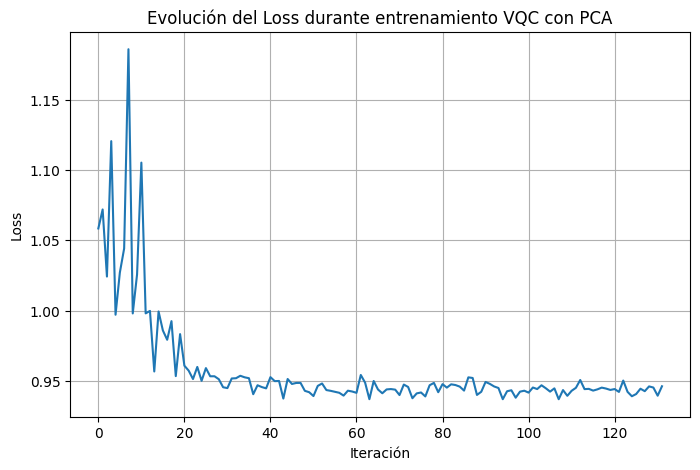

In [82]:
# Graficamos la evolución del loss
plt.figure(figsize=(8,5))
plt.plot(losses, linestyle='-')
plt.title('Evolución del Loss durante entrenamiento VQC con PCA')
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [83]:
# Mostramos ahora los resultados.
y_pred = vqc.predict(x_test_scaled)

accuracy_vqc_pca_200_3 = accuracy_score(y_test_1, y_pred)
precision_vqc_pca_200_3 = precision_score(y_test_1, y_pred)
recall_vqc_pca_200_3 = recall_score(y_test_1, y_pred)
f1_vqc_pca_200_3 = f1_score(y_test_1, y_pred)

print("Accuracy:", accuracy_vqc_pca_200_3)
print("Precisión:", precision_vqc_pca_200_3)
print("Recall:", recall_vqc_pca_200_3)
print("F1 score:", f1_vqc_pca_200_3)
print(classification_report(y_test_1, y_pred))

Accuracy: 0.6166666666666667
Precisión: 0.5945945945945946
Recall: 0.7333333333333333
F1 score: 0.6567164179104478
              precision    recall  f1-score   support

         0.0       0.65      0.50      0.57        30
         1.0       0.59      0.73      0.66        30

    accuracy                           0.62        60
   macro avg       0.62      0.62      0.61        60
weighted avg       0.62      0.62      0.61        60



#### VQC con COBYLA (QPCA)

In [84]:
# Escalamos los datos entre 0 y 2 * pi por estar utilizando ángulos.
scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))
x_train_scaled = scaler.fit_transform(projections_train)
x_test_scaled = scaler.transform(projections_test)

# Definimos el mapa de características.
feature_map = ZZFeatureMap(feature_dimension=x_train_scaled.shape[1], reps=3)

# Y el ansatz.
ansatz = TwoLocal(num_qubits=x_train_scaled.shape[1], reps=3, rotation_blocks='ry', entanglement_blocks='cz')

# Usamos un sampler para el backend.
sampler = AerSampler()

losses = []

# Creamos el modelo VQC con COBYLA.
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=500),
    sampler=sampler,
    initial_point=np.random.rand(ansatz.num_parameters),
    callback=callback,
)

# Y entrenamos.
vqc.fit(x_train_scaled, y_train_1)

Loss: 1.3445
Loss: 1.3215
Loss: 1.4566
Loss: 1.3582
Loss: 1.1165
Loss: 1.1045
Loss: 1.0340
Loss: 1.2012
Loss: 1.0354
Loss: 1.0929
Loss: 0.9019
Loss: 0.9061
Loss: 0.9065
Loss: 0.8822
Loss: 0.8131
Loss: 0.8548
Loss: 0.8078
Loss: 0.8057
Loss: 0.8104
Loss: 0.9534
Loss: 0.8203
Loss: 0.8297
Loss: 0.8736
Loss: 0.8890
Loss: 0.7934
Loss: 0.7875
Loss: 0.8540
Loss: 0.7895
Loss: 0.7847
Loss: 0.8043
Loss: 0.8065
Loss: 0.8078
Loss: 0.7870
Loss: 0.7907
Loss: 0.8079
Loss: 0.7880
Loss: 0.7931
Loss: 0.7828
Loss: 0.7857
Loss: 0.7825
Loss: 0.7826
Loss: 0.7786
Loss: 0.7694
Loss: 0.7630
Loss: 0.7610
Loss: 0.7686
Loss: 0.7665
Loss: 0.7749
Loss: 0.7801
Loss: 0.7595
Loss: 0.7524
Loss: 0.7616
Loss: 0.7537
Loss: 0.7549
Loss: 0.7511
Loss: 0.7524
Loss: 0.7553
Loss: 0.7625
Loss: 0.7546
Loss: 0.7575
Loss: 0.7582
Loss: 0.7518
Loss: 0.7605
Loss: 0.7587
Loss: 0.7578
Loss: 0.7592
Loss: 0.7534
Loss: 0.7572
Loss: 0.7523
Loss: 0.7538
Loss: 0.7473
Loss: 0.7513
Loss: 0.7522
Loss: 0.7577
Loss: 0.7549
Loss: 0.7572
Loss: 0.7532

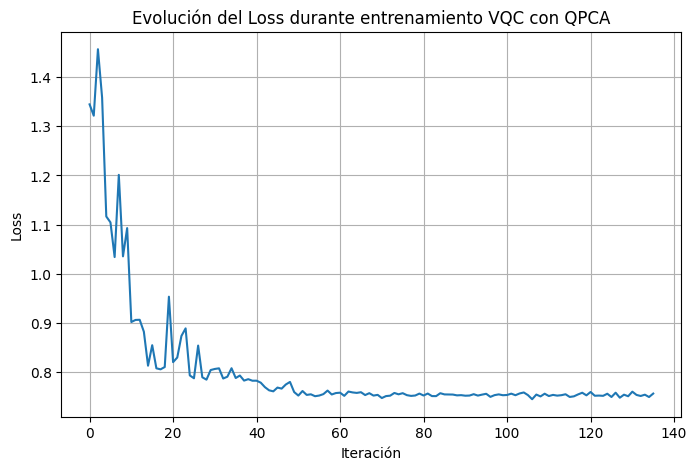

In [85]:
# Graficamos la evolución del loss
plt.figure(figsize=(8,5))
plt.plot(losses, linestyle='-')
plt.title('Evolución del Loss durante entrenamiento VQC con QPCA')
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [86]:
# Mostramos ahora los resultados.
y_pred = vqc.predict(x_test_scaled)

accuracy_vqc_qpca_200_3 = accuracy_score(y_test_1, y_pred)
precision_vqc_qpca_200_3 = precision_score(y_test_1, y_pred)
recall_vqc_qpca_200_3 = recall_score(y_test_1, y_pred)
f1_vqc_qpca_200_3 = f1_score(y_test_1, y_pred)

print("Accuracy:", accuracy_vqc_qpca_200_3)
print("Precisión:", precision_vqc_qpca_200_3)
print("Recall:", recall_vqc_qpca_200_3)
print("F1 score:", f1_vqc_qpca_200_3)
print(classification_report(y_test_1, y_pred))

Accuracy: 0.7333333333333333
Precisión: 0.6944444444444444
Recall: 0.8333333333333334
F1 score: 0.7575757575757576
              precision    recall  f1-score   support

         0.0       0.79      0.63      0.70        30
         1.0       0.69      0.83      0.76        30

    accuracy                           0.73        60
   macro avg       0.74      0.73      0.73        60
weighted avg       0.74      0.73      0.73        60



### 500 datos

In [87]:
x1 = df2.drop(columns='is_fraud')
y1 = df2['is_fraud']

x1 = np.array(x1, dtype=np.float32)
y1 = np.array(y1, dtype=np.float32)

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(
    x1, y1, test_size=0.3, stratify=y1, random_state=42
)

#### PCA

In [88]:
# Creamos instancia de PCA para reducir a 2D.
pca = PCA(n_components=3)

# Transformamos los datos.
x_train_pca_1 = pca.fit_transform(x_train_1)
x_test_pca_1 = pca.transform(x_test_1)

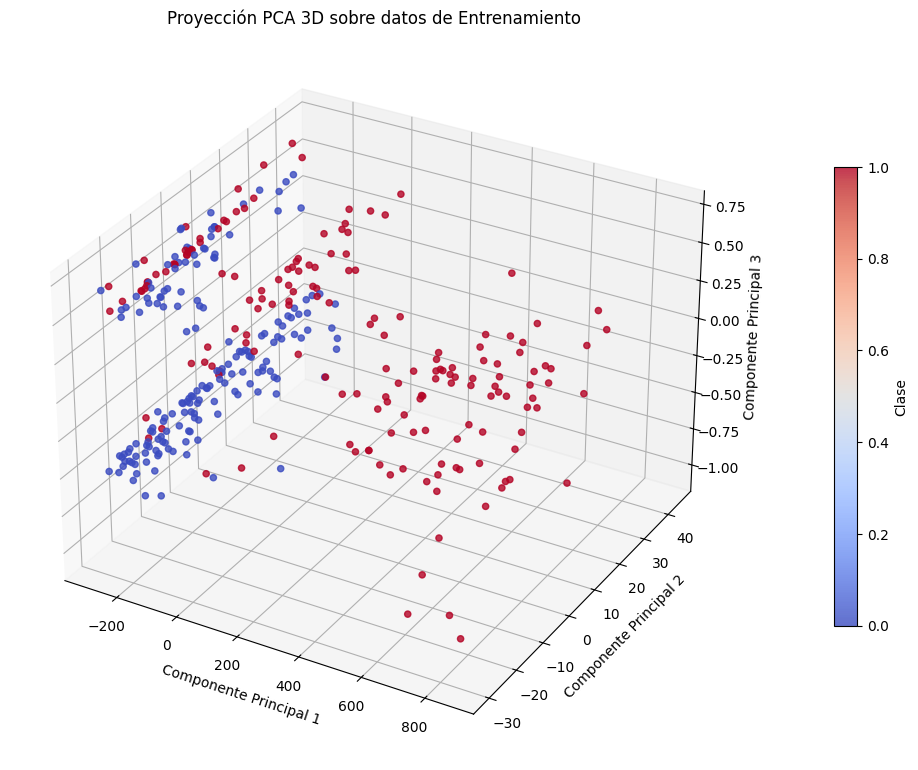

In [89]:
# Visualización de resultados.
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Gráfico de dispersión en 3D
scatter = ax.scatter(
    x_train_pca_1[:, 0],
    x_train_pca_1[:, 1],
    x_train_pca_1[:, 2],
    c=y_train_1,
    cmap='coolwarm',
    alpha=0.8
)

# Etiquetas de ejes
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
ax.set_title("Proyección PCA 3D sobre datos de Entrenamiento")

# Barra de color
cbar = plt.colorbar(scatter, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label("Clase")

plt.grid(True)
plt.tight_layout()
plt.show()

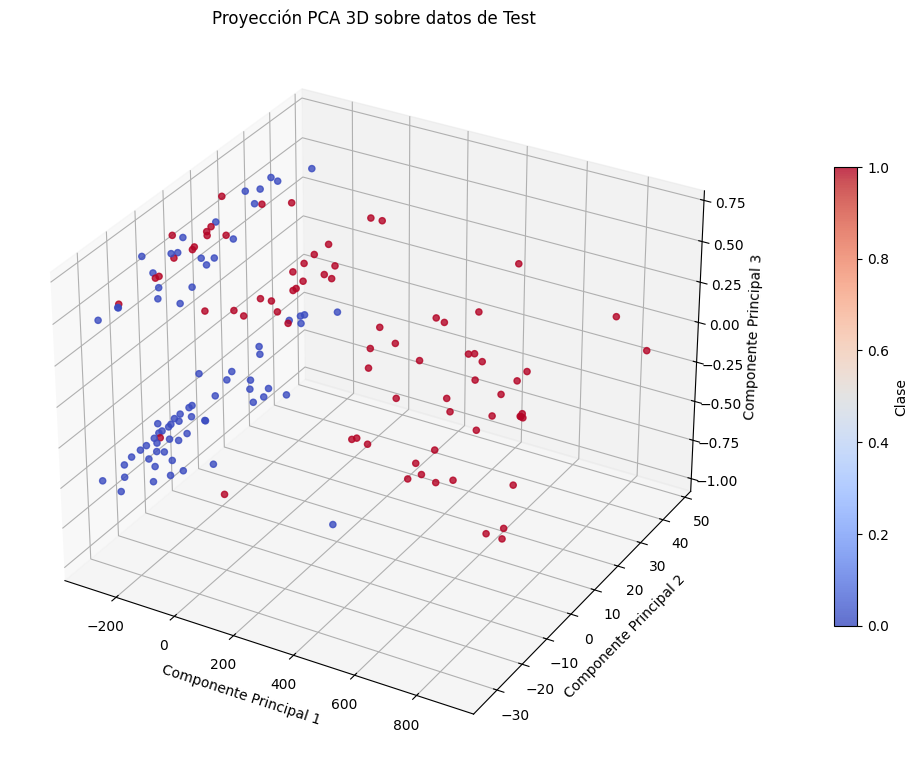

In [90]:
# Visualización de resultados.
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Gráfico de dispersión en 3D
scatter = ax.scatter(
    x_test_pca_1[:, 0],
    x_test_pca_1[:, 1],
    x_test_pca_1[:, 2],
    c=y_test_1,
    cmap='coolwarm',
    alpha=0.8
)

# Etiquetas de ejes
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
ax.set_title("Proyección PCA 3D sobre datos de Test")

# Barra de color
cbar = plt.colorbar(scatter, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label("Clase")

plt.grid(True)
plt.tight_layout()
plt.show()

#### QPCA

In [91]:
# Elegimos 3 qubits -> necesitamos vectores de dimensión 2^3 = 8
n_qubits = 3
state_dim = 2**n_qubits

# Padding de los datos de entrenamiento y test
x_train_1_padded = np.array([pad_vector(x, state_dim) for x in x_train_1])
x_test_1_padded = np.array([pad_vector(x, state_dim) for x in x_test_1])

# Creamos un dispositivo simulado de 3 qubits
dev = qml.device("default.qubit", wires=n_qubits, shots=5000)

# Definimos el circuito cuántico que mide PauliZ en cada qubit
@qml.qnode(dev)
def density_matrix_measurement(x):
    state_preparation(x)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Obtenemos la "proyección" de cada dato en el espacio cuántico
# Cada vector viene de una medida de 3 dimensiones (una por qubit)
train_meas = np.array([density_matrix_measurement(x) for x in x_train_1])
test_meas = np.array([density_matrix_measurement(x) for x in x_test_1])

# Calculamos la matriz de covarianza de las medidas cuánticas
cov_qpca = np.cov(train_meas.T)

# Obtenemos autovalores y autovectores (componentes principales)
eigenvalues, eigenvectors = np.linalg.eigh(cov_qpca)

# Ordenamos los vectores propios en orden descendente de autovalor
idx = np.argsort(-eigenvalues)
principal_components = eigenvectors[:, idx[:3]]

# Proyectamos las medidas cuánticas en las dos componentes principales
projections_train = train_meas @ principal_components
projections_test = test_meas @ principal_components

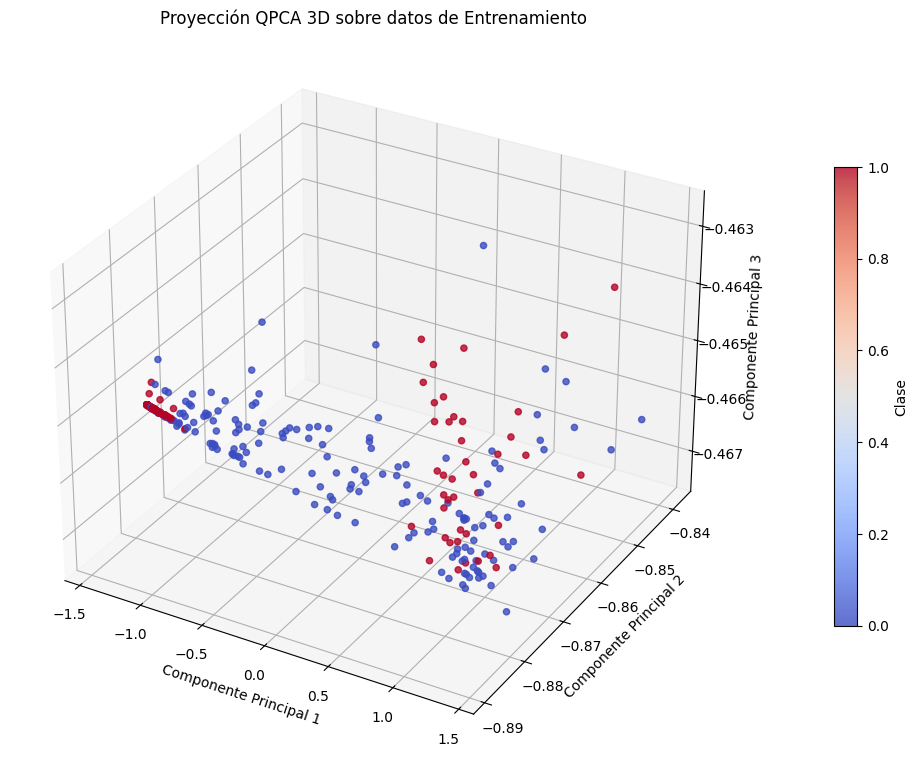

In [92]:
# Visualización de resultados.
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Gráfico de dispersión en 3D
scatter = ax.scatter(
    projections_train[:, 0],
    projections_train[:, 1],
    projections_train[:, 2],
    c=y_train_1,
    cmap='coolwarm',
    alpha=0.8
)

# Etiquetas de ejes
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
ax.set_title("Proyección QPCA 3D sobre datos de Entrenamiento")

# Barra de color
cbar = plt.colorbar(scatter, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label("Clase")

plt.grid(True)
plt.tight_layout()
plt.show()

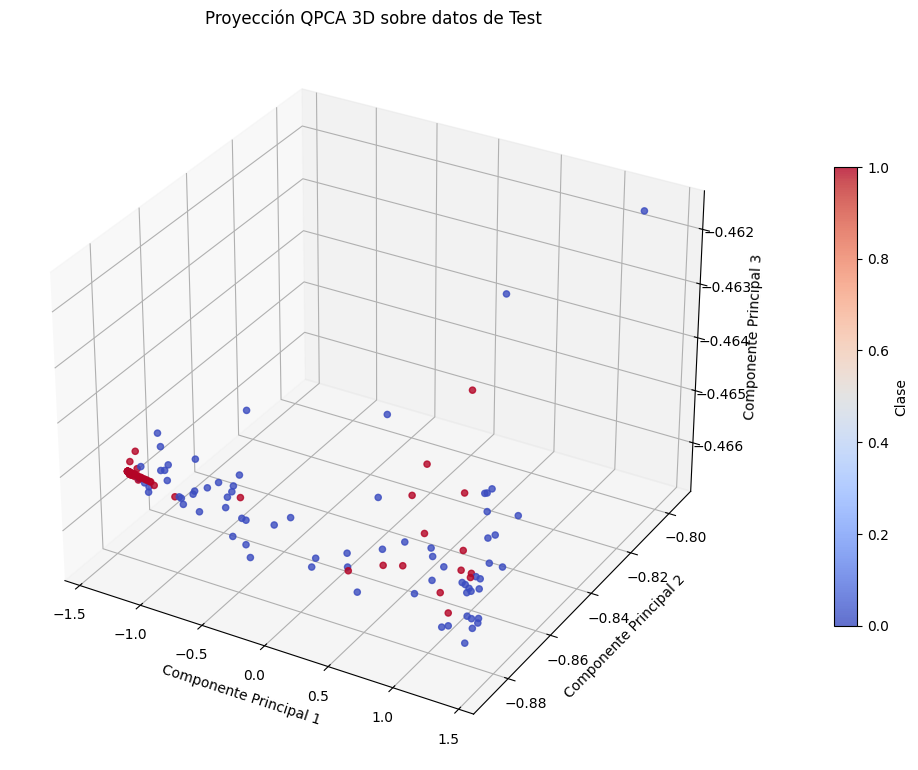

In [93]:
# Visualización de resultados.
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Gráfico de dispersión en 3D
scatter = ax.scatter(
    projections_test[:, 0],
    projections_test[:, 1],
    projections_test[:, 2],
    c=y_test_1,
    cmap='coolwarm',
    alpha=0.8
)

# Etiquetas de ejes
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
ax.set_title("Proyección QPCA 3D sobre datos de Test")

# Barra de color
cbar = plt.colorbar(scatter, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label("Clase")

plt.grid(True)
plt.tight_layout()
plt.show()

#### Decision Tree (PCA)

In [94]:
# Entrenamos y evaluamos datos con PCA.
dt = DecisionTreeClassifier(random_state=17, max_depth=3)
dt.fit(x_train_pca_1, y_train_1)

y_pred_dtpca_1 = dt.predict(x_test_pca_1)

accuracy_dtpca_500_3 = accuracy_score(y_test_1, y_pred_dtpca_1)
precision_dtpca_500_3 = precision_score(y_test_1, y_pred_dtpca_1)
recall_dtpca_500_3 = recall_score(y_test_1, y_pred_dtpca_1)
f1_dtpca_500_3 = f1_score(y_test_1, y_pred_dtpca_1)

print(f"Accuracy Decision Tree con PCA: {accuracy_dtpca_500_3}")
print(f"Precisión Decision Tree con PCA: {precision_dtpca_500_3}")
print(f"Recall Decision Tree con PCA: {recall_dtpca_500_3}")
print(f"F1 Score Decision Tree con PCA: {f1_dtpca_500_3}")
print(classification_report(y_test_1, y_pred_dtpca_1))

Accuracy Decision Tree con PCA: 0.9133333333333333
Precisión Decision Tree con PCA: 0.918918918918919
Recall Decision Tree con PCA: 0.9066666666666666
F1 Score Decision Tree con PCA: 0.912751677852349
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.91        75
         1.0       0.92      0.91      0.91        75

    accuracy                           0.91       150
   macro avg       0.91      0.91      0.91       150
weighted avg       0.91      0.91      0.91       150



#### Decision Tree (QPCA)

In [95]:
# Ahora lo mismo para la versión con QPCA.
qdt = DecisionTreeClassifier(random_state=17, max_depth=3)
qdt.fit(projections_train, y_train_1)

y_pred_qdtpca_1 = qdt.predict(projections_test)

accuracy_qdtpca_500_3 = accuracy_score(y_test_1, y_pred_qdtpca_1)
precision_qdtpca_500_3 = precision_score(y_test_1, y_pred_qdtpca_1)
recall_qdtpca_500_3 = recall_score(y_test_1, y_pred_qdtpca_1)
f1_qdtpca_500_3 = f1_score(y_test_1, y_pred_qdtpca_1)

print(f"Accuracy Decision Tree con QPCA: {accuracy_qdtpca_500_3}")
print(f"Precisión Decision Tree con QPCA: {precision_qdtpca_500_3}")
print(f"Recall Decision Tree con QPCA: {recall_qdtpca_500_3}")
print(f"F1 Score Decision Tree con QPCA: {f1_qdtpca_500_3}")
print(classification_report(y_test_1, y_pred_qdtpca_1))

Accuracy Decision Tree con QPCA: 0.8066666666666666
Precisión Decision Tree con QPCA: 0.859375
Recall Decision Tree con QPCA: 0.7333333333333333
F1 Score Decision Tree con QPCA: 0.7913669064748201
              precision    recall  f1-score   support

         0.0       0.77      0.88      0.82        75
         1.0       0.86      0.73      0.79        75

    accuracy                           0.81       150
   macro avg       0.81      0.81      0.81       150
weighted avg       0.81      0.81      0.81       150



#### VQC con COBYLA (PCA)

In [96]:
# Escalamos los datos entre 0 y 2 * pi por estar utilizando ángulos.
scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))
x_train_scaled = scaler.fit_transform(x_train_pca_1)
x_test_scaled = scaler.transform(x_test_pca_1)

# Definimos el mapa de características.
feature_map = ZZFeatureMap(feature_dimension=x_train_scaled.shape[1], reps=3)

# Y el ansatz.
ansatz = TwoLocal(num_qubits=x_train_scaled.shape[1], reps=3, rotation_blocks='ry', entanglement_blocks='cz')

# Usamos un sampler para el backend.
sampler = AerSampler()

losses = []

# Creamos el modelo VQC con COBYLA.
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=500),
    sampler=sampler,
    initial_point=np.random.rand(ansatz.num_parameters),
    callback=callback,
)

# Y entrenamos.
vqc.fit(x_train_scaled, y_train_1)

Loss: 1.0854
Loss: 1.0825
Loss: 1.1640
Loss: 1.1691
Loss: 1.0048
Loss: 1.0001
Loss: 0.9760
Loss: 1.1130
Loss: 0.9794
Loss: 0.9754
Loss: 1.1048
Loss: 0.9763
Loss: 0.9788
Loss: 0.9778
Loss: 0.9836
Loss: 1.0143
Loss: 1.0309
Loss: 1.0128
Loss: 0.9709
Loss: 0.9823
Loss: 0.9602
Loss: 0.9534
Loss: 0.9495
Loss: 0.9728
Loss: 0.9596
Loss: 0.9788
Loss: 0.9551
Loss: 0.9624
Loss: 0.9521
Loss: 0.9610
Loss: 0.9491
Loss: 0.9743
Loss: 0.9519
Loss: 0.9574
Loss: 0.9489
Loss: 0.9542
Loss: 0.9504
Loss: 0.9524
Loss: 0.9534
Loss: 0.9462
Loss: 0.9530
Loss: 0.9505
Loss: 0.9435
Loss: 0.9486
Loss: 0.9450
Loss: 0.9489
Loss: 0.9403
Loss: 0.9436
Loss: 0.9482
Loss: 0.9457
Loss: 0.9456
Loss: 0.9488
Loss: 0.9484
Loss: 0.9445
Loss: 0.9456
Loss: 0.9390
Loss: 0.9417
Loss: 0.9471
Loss: 0.9471
Loss: 0.9431
Loss: 0.9433
Loss: 0.9484
Loss: 0.9458
Loss: 0.9455
Loss: 0.9418
Loss: 0.9427
Loss: 0.9483
Loss: 0.9463
Loss: 0.9467
Loss: 0.9422
Loss: 0.9442
Loss: 0.9461
Loss: 0.9401
Loss: 0.9408
Loss: 0.9414
Loss: 0.9452
Loss: 0.9472

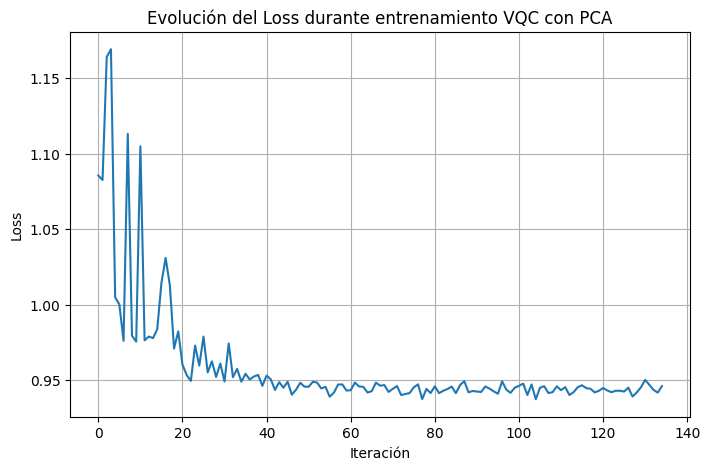

In [97]:
# Graficamos la evolución del loss
plt.figure(figsize=(8,5))
plt.plot(losses, linestyle='-')
plt.title('Evolución del Loss durante entrenamiento VQC con PCA')
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [98]:
# Mostramos ahora los resultados.
y_pred = vqc.predict(x_test_scaled)

accuracy_vqc_pca_500_3 = accuracy_score(y_test_1, y_pred)
precision_vqc_pca_500_3 = precision_score(y_test_1, y_pred)
recall_vqc_pca_500_3 = recall_score(y_test_1, y_pred)
f1_vqc_pca_500_3 = f1_score(y_test_1, y_pred)

print("Accuracy:", accuracy_vqc_pca_500_3)
print("Precisión:", precision_vqc_pca_500_3)
print("Recall:", recall_vqc_pca_500_3)
print("F1 score:", f1_vqc_pca_500_3)
print(classification_report(y_test_1, y_pred))

Accuracy: 0.5733333333333334
Precisión: 0.5662650602409639
Recall: 0.6266666666666667
F1 score: 0.5949367088607594
              precision    recall  f1-score   support

         0.0       0.58      0.52      0.55        75
         1.0       0.57      0.63      0.59        75

    accuracy                           0.57       150
   macro avg       0.57      0.57      0.57       150
weighted avg       0.57      0.57      0.57       150



#### VQC con COBYLA (QPCA)

In [99]:
# Escalamos los datos entre 0 y 2 * pi por estar utilizando ángulos.
scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))
x_train_scaled = scaler.fit_transform(projections_train)
x_test_scaled = scaler.transform(projections_test)

# Definimos el mapa de características.
feature_map = ZZFeatureMap(feature_dimension=x_train_scaled.shape[1], reps=3)

# Y el ansatz.
ansatz = TwoLocal(num_qubits=x_train_scaled.shape[1], reps=3, rotation_blocks='ry', entanglement_blocks='cz')

# Usamos un sampler para el backend.
sampler = AerSampler()

losses = []

# Creamos el modelo VQC con COBYLA.
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=500),
    sampler=sampler,
    initial_point=np.random.rand(ansatz.num_parameters),
    callback=callback,
)

# Y entrenamos.
vqc.fit(x_train_scaled, y_train_1)

Loss: 1.0650
Loss: 1.4474
Loss: 0.9415
Loss: 0.9722
Loss: 1.1481
Loss: 0.9014
Loss: 0.9238
Loss: 1.0519
Loss: 0.8408
Loss: 0.8736
Loss: 0.8233
Loss: 0.8236
Loss: 0.8232
Loss: 1.1400
Loss: 0.8281
Loss: 0.9097
Loss: 0.8143
Loss: 0.8222
Loss: 0.8081
Loss: 1.0479
Loss: 0.8497
Loss: 0.8289
Loss: 0.8688
Loss: 0.9227
Loss: 0.7822
Loss: 0.7764
Loss: 0.7879
Loss: 0.7714
Loss: 0.8297
Loss: 0.7708
Loss: 0.7920
Loss: 0.7738
Loss: 0.8096
Loss: 0.8013
Loss: 0.7409
Loss: 0.7643
Loss: 0.7369
Loss: 0.7589
Loss: 0.7655
Loss: 0.7471
Loss: 0.7186
Loss: 0.7138
Loss: 0.7078
Loss: 0.7084
Loss: 0.7107
Loss: 0.7094
Loss: 0.7112
Loss: 0.7220
Loss: 0.7138
Loss: 0.7033
Loss: 0.7067
Loss: 0.7086
Loss: 0.7039
Loss: 0.7059
Loss: 0.7121
Loss: 0.7090
Loss: 0.7074
Loss: 0.7093
Loss: 0.7126
Loss: 0.7092
Loss: 0.7057
Loss: 0.7064
Loss: 0.7081
Loss: 0.7092
Loss: 0.7052
Loss: 0.7066
Loss: 0.7033
Loss: 0.7116
Loss: 0.7059
Loss: 0.7070
Loss: 0.7061
Loss: 0.7086
Loss: 0.7072
Loss: 0.7063
Loss: 0.7042
Loss: 0.7122
Loss: 0.7095

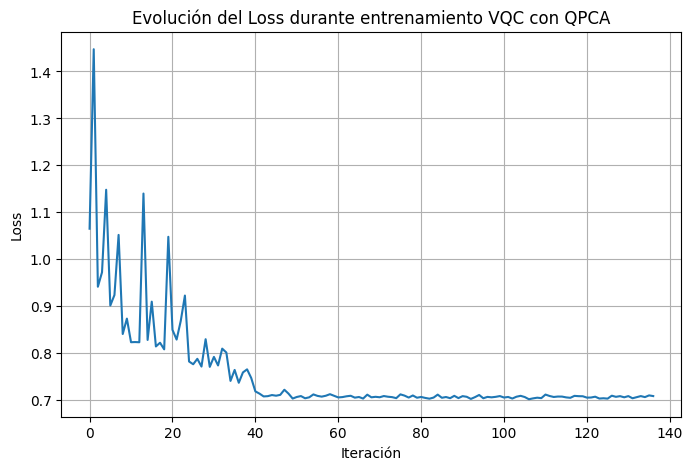

In [100]:
# Graficamos la evolución del loss
plt.figure(figsize=(8,5))
plt.plot(losses, linestyle='-')
plt.title('Evolución del Loss durante entrenamiento VQC con QPCA')
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [101]:
# Mostramos ahora los resultados.
y_pred = vqc.predict(x_test_scaled)

accuracy_vqc_qpca_500_3 = accuracy_score(y_test_1, y_pred)
precision_vqc_qpca_500_3 = precision_score(y_test_1, y_pred)
recall_vqc_qpca_500_3 = recall_score(y_test_1, y_pred)
f1_vqc_qpca_500_3 = f1_score(y_test_1, y_pred)

print("Accuracy:", accuracy_vqc_qpca_500_3)
print("Precisión:", precision_vqc_qpca_500_3)
print("Recall:", recall_vqc_qpca_500_3)
print("F1 score:", f1_vqc_qpca_500_3)
print(classification_report(y_test_1, y_pred))

Accuracy: 0.7066666666666667
Precisión: 0.6741573033707865
Recall: 0.8
F1 score: 0.7317073170731707
              precision    recall  f1-score   support

         0.0       0.75      0.61      0.68        75
         1.0       0.67      0.80      0.73        75

    accuracy                           0.71       150
   macro avg       0.71      0.71      0.70       150
weighted avg       0.71      0.71      0.70       150



## Estudio Comparativo (Sin Desbalanceo, 3D)

In [102]:
# Crear muestras
df1 = crear_submuestra_balanceada(data_2, label_col='label', total_muestra=200, proporcion_clase_mayor=0.5)
df2 = crear_submuestra_balanceada(data_2, label_col='label', total_muestra=500, proporcion_clase_mayor=0.5)

### 200 datos

In [103]:
x1 = df1.drop(columns='is_fraud')
y1 = df1['is_fraud']

x1 = np.array(x1, dtype=np.float32)
y1 = np.array(y1, dtype=np.float32)

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(
    x1, y1, test_size=0.3, stratify=y1, random_state=42
)

#### PCA

In [104]:
# Creamos instancia de PCA para reducir a 2D.
pca = PCA(n_components=3)

# Transformamos los datos.
x_train_pca_1 = pca.fit_transform(x_train_1)
x_test_pca_1 = pca.transform(x_test_1)

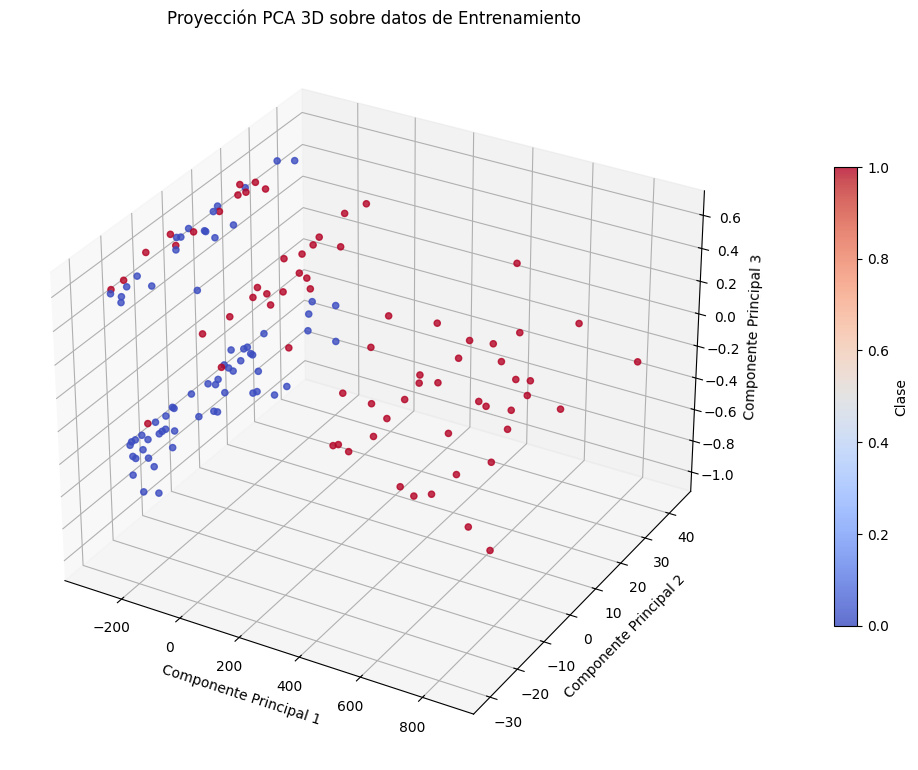

In [105]:
# Visualización de resultados.
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Gráfico de dispersión en 3D
scatter = ax.scatter(
    x_train_pca_1[:, 0],
    x_train_pca_1[:, 1],
    x_train_pca_1[:, 2],
    c=y_train_1,
    cmap='coolwarm',
    alpha=0.8
)

# Etiquetas de ejes
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
ax.set_title("Proyección PCA 3D sobre datos de Entrenamiento")

# Barra de color
cbar = plt.colorbar(scatter, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label("Clase")

plt.grid(True)
plt.tight_layout()
plt.show()

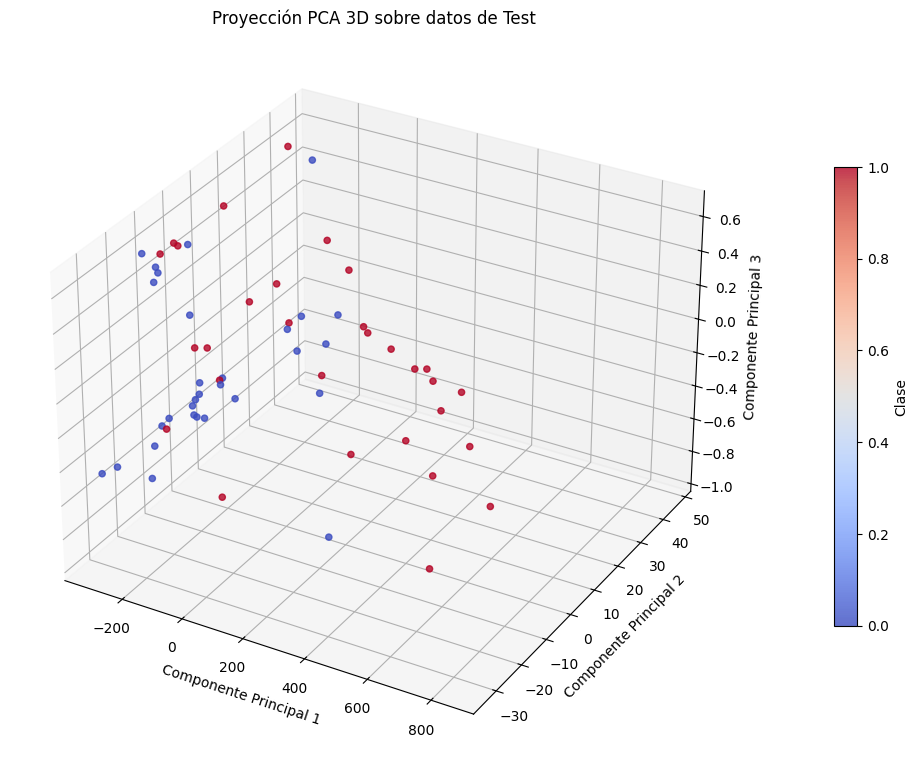

In [106]:
# Visualización de resultados.
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Gráfico de dispersión en 3D
scatter = ax.scatter(
    x_test_pca_1[:, 0],
    x_test_pca_1[:, 1],
    x_test_pca_1[:, 2],
    c=y_test_1,
    cmap='coolwarm',
    alpha=0.8
)

# Etiquetas de ejes
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
ax.set_title("Proyección PCA 3D sobre datos de Test")

# Barra de color
cbar = plt.colorbar(scatter, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label("Clase")

plt.grid(True)
plt.tight_layout()
plt.show()

#### QPCA

In [107]:
# Elegimos 3 qubits -> necesitamos vectores de dimensión 2^3 = 8
n_qubits = 3
state_dim = 2**n_qubits

# Padding de los datos de entrenamiento y test
x_train_1_padded = np.array([pad_vector(x, state_dim) for x in x_train_1])
x_test_1_padded = np.array([pad_vector(x, state_dim) for x in x_test_1])

# Creamos un dispositivo simulado de 3 qubits
dev = qml.device("default.qubit", wires=n_qubits, shots=5000)

# Definimos el circuito cuántico que mide PauliZ en cada qubit
@qml.qnode(dev)
def density_matrix_measurement(x):
    state_preparation(x)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Obtenemos la "proyección" de cada dato en el espacio cuántico
# Cada vector viene de una medida de 3 dimensiones (una por qubit)
train_meas = np.array([density_matrix_measurement(x) for x in x_train_1])
test_meas = np.array([density_matrix_measurement(x) for x in x_test_1])

# Calculamos la matriz de covarianza de las medidas cuánticas
cov_qpca = np.cov(train_meas.T)

# Obtenemos autovalores y autovectores (componentes principales)
eigenvalues, eigenvectors = np.linalg.eigh(cov_qpca)

# Ordenamos los vectores propios en orden descendente de autovalor
idx = np.argsort(-eigenvalues)
principal_components = eigenvectors[:, idx[:3]]

# Proyectamos las medidas cuánticas en las dos componentes principales
projections_train = train_meas @ principal_components
projections_test = test_meas @ principal_components

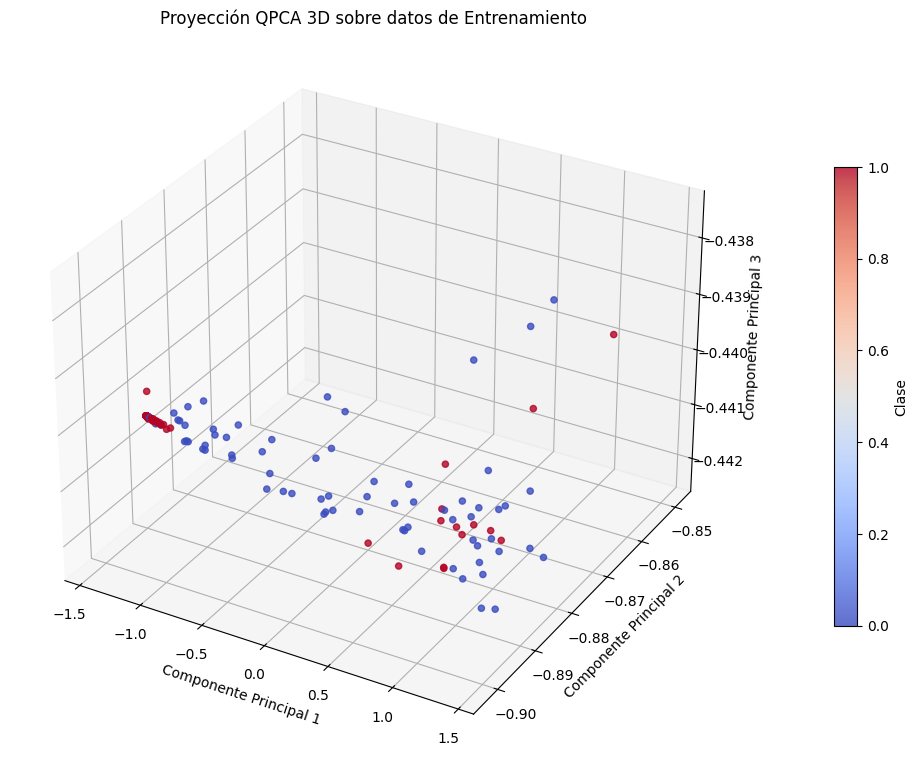

In [108]:
# Visualización de resultados.
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Gráfico de dispersión en 3D
scatter = ax.scatter(
    projections_train[:, 0],
    projections_train[:, 1],
    projections_train[:, 2],
    c=y_train_1,
    cmap='coolwarm',
    alpha=0.8
)

# Etiquetas de ejes
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
ax.set_title("Proyección QPCA 3D sobre datos de Entrenamiento")

# Barra de color
cbar = plt.colorbar(scatter, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label("Clase")

plt.grid(True)
plt.tight_layout()
plt.show()

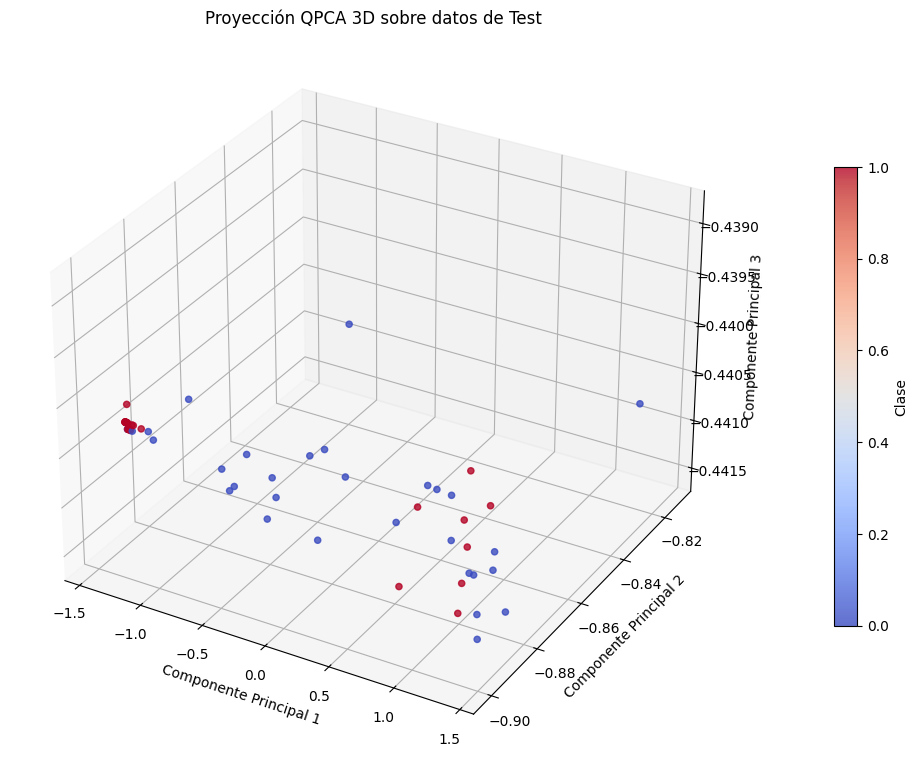

In [109]:
# Visualización de resultados.
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Gráfico de dispersión en 3D
scatter = ax.scatter(
    projections_test[:, 0],
    projections_test[:, 1],
    projections_test[:, 2],
    c=y_test_1,
    cmap='coolwarm',
    alpha=0.8
)

# Etiquetas de ejes
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
ax.set_title("Proyección QPCA 3D sobre datos de Test")

# Barra de color
cbar = plt.colorbar(scatter, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label("Clase")

plt.grid(True)
plt.tight_layout()
plt.show()

#### Decision Tree (PCA)

In [110]:
# Entrenamos y evaluamos datos con PCA.
dt = DecisionTreeClassifier(random_state=17, max_depth=3)
dt.fit(x_train_pca_1, y_train_1)

y_pred_dtpca_1 = dt.predict(x_test_pca_1)

accuracy_dtpca_200_4 = accuracy_score(y_test_1, y_pred_dtpca_1)
precision_dtpca_200_4 = precision_score(y_test_1, y_pred_dtpca_1)
recall_dtpca_200_4 = recall_score(y_test_1, y_pred_dtpca_1)
f1_dtpca_200_4 = f1_score(y_test_1, y_pred_dtpca_1)

print(f"Accuracy Decision Tree con PCA: {accuracy_dtpca_200_4}")
print(f"Precisión Decision Tree con PCA: {precision_dtpca_200_4}")
print(f"Recall Decision Tree con PCA: {recall_dtpca_200_4}")
print(f"F1 Score Decision Tree con PCA: {f1_dtpca_200_4}")
print(classification_report(y_test_1, y_pred_dtpca_1))

Accuracy Decision Tree con PCA: 0.9
Precisión Decision Tree con PCA: 0.9285714285714286
Recall Decision Tree con PCA: 0.8666666666666667
F1 Score Decision Tree con PCA: 0.896551724137931
              precision    recall  f1-score   support

         0.0       0.88      0.93      0.90        30
         1.0       0.93      0.87      0.90        30

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



#### Decision Tree (QPCA)

In [111]:
# Ahora lo mismo para la versión con QPCA.
qdt = DecisionTreeClassifier(random_state=17, max_depth=3)
qdt.fit(projections_train, y_train_1)

y_pred_qdtpca_1 = qdt.predict(projections_test)

accuracy_qdtpca_200_4 = accuracy_score(y_test_1, y_pred_qdtpca_1)
precision_qdtpca_200_4 = precision_score(y_test_1, y_pred_qdtpca_1)
recall_qdtpca_200_4 = recall_score(y_test_1, y_pred_qdtpca_1)
f1_qdtpca_200_4 = f1_score(y_test_1, y_pred_qdtpca_1)

print(f"Accuracy Decision Tree con QPCA: {accuracy_qdtpca_200_4}")
print(f"Precisión Decision Tree con QPCA: {precision_qdtpca_200_4}")
print(f"Recall Decision Tree con QPCA: {recall_qdtpca_200_4}")
print(f"F1 Score Decision Tree con QPCA: {f1_qdtpca_200_4}")
print(classification_report(y_test_1, y_pred_qdtpca_1))

Accuracy Decision Tree con QPCA: 0.8
Precisión Decision Tree con QPCA: 0.8214285714285714
Recall Decision Tree con QPCA: 0.7666666666666667
F1 Score Decision Tree con QPCA: 0.7931034482758621
              precision    recall  f1-score   support

         0.0       0.78      0.83      0.81        30
         1.0       0.82      0.77      0.79        30

    accuracy                           0.80        60
   macro avg       0.80      0.80      0.80        60
weighted avg       0.80      0.80      0.80        60



#### VQC con COBYLA (PCA)

In [112]:
# Escalamos los datos entre 0 y 2 * pi por estar utilizando ángulos.
scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))
x_train_scaled = scaler.fit_transform(x_train_pca_1)
x_test_scaled = scaler.transform(x_test_pca_1)

# Definimos el mapa de características.
feature_map = ZZFeatureMap(feature_dimension=x_train_scaled.shape[1], reps=3)

# Y el ansatz.
ansatz = TwoLocal(num_qubits=x_train_scaled.shape[1], reps=3, rotation_blocks='ry', entanglement_blocks='cz')

# Usamos un sampler para el backend.
sampler = AerSampler()

losses = []

# Creamos el modelo VQC con COBYLA.
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=500),
    sampler=sampler,
    initial_point=np.random.rand(ansatz.num_parameters),
    callback=callback,
)

# Y entrenamos.
vqc.fit(x_train_scaled, y_train_1)

Loss: 1.1606
Loss: 1.1362
Loss: 1.1378
Loss: 1.1852
Loss: 1.1424
Loss: 1.1548
Loss: 1.0856
Loss: 1.1614
Loss: 1.1372
Loss: 1.1346
Loss: 1.0929
Loss: 1.0689
Loss: 1.0732
Loss: 1.0772
Loss: 1.0701
Loss: 1.0884
Loss: 1.0783
Loss: 1.0892
Loss: 1.0534
Loss: 1.0517
Loss: 1.0478
Loss: 1.0555
Loss: 1.0649
Loss: 1.0458
Loss: 1.0574
Loss: 1.0641
Loss: 1.0360
Loss: 1.0360
Loss: 1.0789
Loss: 1.0500
Loss: 1.0329
Loss: 1.0148
Loss: 1.0033
Loss: 1.0138
Loss: 1.0062
Loss: 1.0036
Loss: 1.0117
Loss: 1.0035
Loss: 1.0181
Loss: 1.0018
Loss: 1.0126
Loss: 0.9974
Loss: 1.0005
Loss: 1.0022
Loss: 1.0110
Loss: 0.9929
Loss: 1.0072
Loss: 0.9965
Loss: 1.0005
Loss: 0.9887
Loss: 0.9931
Loss: 0.9975
Loss: 1.0078
Loss: 0.9965
Loss: 0.9980
Loss: 0.9963
Loss: 1.0000
Loss: 1.0017
Loss: 1.0003
Loss: 0.9939
Loss: 0.9987
Loss: 0.9952
Loss: 0.9987
Loss: 0.9950
Loss: 1.0019
Loss: 0.9986
Loss: 1.0000
Loss: 0.9941
Loss: 0.9914
Loss: 0.9948
Loss: 0.9941
Loss: 0.9959
Loss: 0.9952
Loss: 0.9953
Loss: 0.9943
Loss: 1.0014
Loss: 0.9941

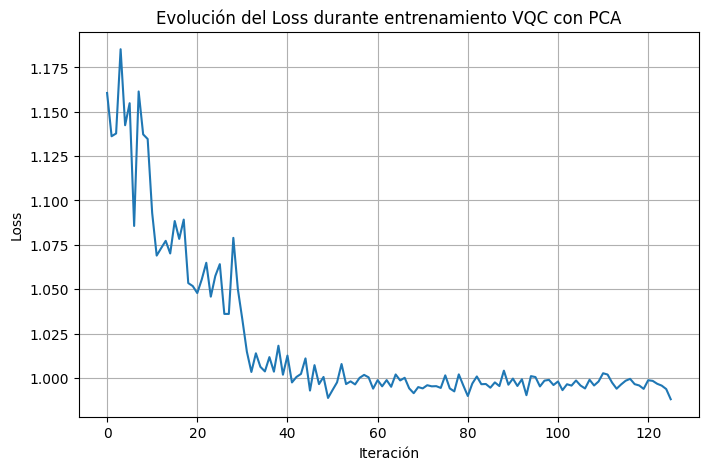

In [113]:
# Graficamos la evolución del loss
plt.figure(figsize=(8,5))
plt.plot(losses, linestyle='-')
plt.title('Evolución del Loss durante entrenamiento VQC con PCA')
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [114]:
# Mostramos ahora los resultados.
y_pred = vqc.predict(x_test_scaled)

accuracy_vqc_pca_200_4 = accuracy_score(y_test_1, y_pred)
precision_vqc_pca_200_4 = precision_score(y_test_1, y_pred)
recall_vqc_pca_200_4 = recall_score(y_test_1, y_pred)
f1_vqc_pca_200_4 = f1_score(y_test_1, y_pred)

print("Accuracy:", accuracy_vqc_pca_200_4)
print("Precisión:", precision_vqc_pca_200_4)
print("Recall:", recall_vqc_pca_200_4)
print("F1 score:", f1_vqc_pca_200_4)
print(classification_report(y_test_1, y_pred))

Accuracy: 0.5
Precisión: 0.5
Recall: 0.4
F1 score: 0.4444444444444444
              precision    recall  f1-score   support

         0.0       0.50      0.60      0.55        30
         1.0       0.50      0.40      0.44        30

    accuracy                           0.50        60
   macro avg       0.50      0.50      0.49        60
weighted avg       0.50      0.50      0.49        60



#### VQC con COBYLA (QPCA)

In [115]:
# Escalamos los datos entre 0 y 2 * pi por estar utilizando ángulos.
scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))
x_train_scaled = scaler.fit_transform(projections_train)
x_test_scaled = scaler.transform(projections_test)

# Definimos el mapa de características.
feature_map = ZZFeatureMap(feature_dimension=x_train_scaled.shape[1], reps=3)

# Y el ansatz.
ansatz = TwoLocal(num_qubits=x_train_scaled.shape[1], reps=3, rotation_blocks='ry', entanglement_blocks='cz')

# Usamos un sampler para el backend.
sampler = AerSampler()

losses = []

# Creamos el modelo VQC con COBYLA.
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=500),
    sampler=sampler,
    initial_point=np.random.rand(ansatz.num_parameters),
    callback=callback,
)

# Y entrenamos.
vqc.fit(x_train_scaled, y_train_1)

Loss: 1.2009
Loss: 1.2128
Loss: 1.2376
Loss: 1.3555
Loss: 1.4292
Loss: 0.9011
Loss: 1.0858
Loss: 0.8009
Loss: 0.7985
Loss: 0.7933
Loss: 0.9664
Loss: 0.8005
Loss: 0.7868
Loss: 0.7584
Loss: 0.8098
Loss: 0.7895
Loss: 0.7325
Loss: 0.7645
Loss: 0.7876
Loss: 0.8440
Loss: 0.7894
Loss: 0.8049
Loss: 0.7369
Loss: 0.7316
Loss: 0.7228
Loss: 0.7148
Loss: 0.7136
Loss: 0.7318
Loss: 0.7437
Loss: 0.7139
Loss: 0.7251
Loss: 0.7457
Loss: 0.7181
Loss: 0.7073
Loss: 0.7022
Loss: 0.7033
Loss: 0.7138
Loss: 0.7096
Loss: 0.7075
Loss: 0.6967
Loss: 0.6966
Loss: 0.6891
Loss: 0.6862
Loss: 0.6946
Loss: 0.6872
Loss: 0.6920
Loss: 0.6874
Loss: 0.6894
Loss: 0.6897
Loss: 0.6877
Loss: 0.6932
Loss: 0.6871
Loss: 0.6807
Loss: 0.6927
Loss: 0.6879
Loss: 0.6880
Loss: 0.6891
Loss: 0.6818
Loss: 0.6910
Loss: 0.6877
Loss: 0.6883
Loss: 0.6807
Loss: 0.6919
Loss: 0.6946
Loss: 0.6908
Loss: 0.6803
Loss: 0.6859
Loss: 0.6943
Loss: 0.6820
Loss: 0.6877
Loss: 0.6872
Loss: 0.6832
Loss: 0.6926
Loss: 0.6881
Loss: 0.6835
Loss: 0.6817
Loss: 0.6850

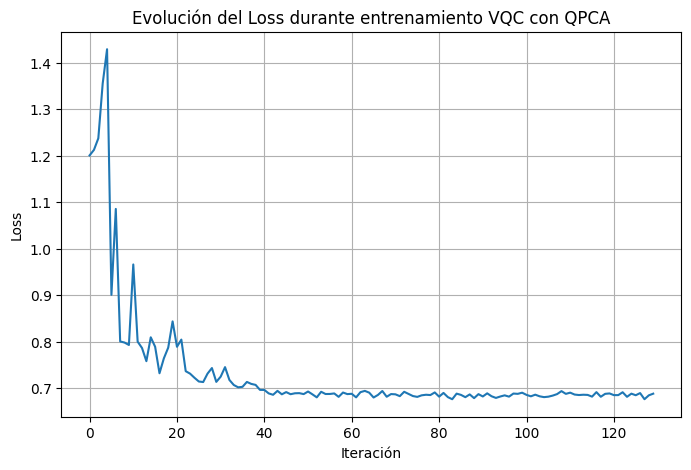

In [116]:
# Graficamos la evolución del loss
plt.figure(figsize=(8,5))
plt.plot(losses, linestyle='-')
plt.title('Evolución del Loss durante entrenamiento VQC con QPCA')
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [117]:
# Mostramos ahora los resultados.
y_pred = vqc.predict(x_test_scaled)

accuracy_vqc_qpca_200_4 = accuracy_score(y_test_1, y_pred)
precision_vqc_qpca_200_4 = precision_score(y_test_1, y_pred)
recall_vqc_qpca_200_4 = recall_score(y_test_1, y_pred)
f1_vqc_qpca_200_4 = f1_score(y_test_1, y_pred)

print("Accuracy:", accuracy_vqc_qpca_200_4)
print("Precisión:", precision_vqc_qpca_200_4)
print("Recall:", recall_vqc_qpca_200_4)
print("F1 score:", f1_vqc_qpca_200_4)
print(classification_report(y_test_1, y_pred))

Accuracy: 0.7166666666666667
Precisión: 0.6666666666666666
Recall: 0.8666666666666667
F1 score: 0.7536231884057971
              precision    recall  f1-score   support

         0.0       0.81      0.57      0.67        30
         1.0       0.67      0.87      0.75        30

    accuracy                           0.72        60
   macro avg       0.74      0.72      0.71        60
weighted avg       0.74      0.72      0.71        60



### 500 datos

In [118]:
x1 = df2.drop(columns='is_fraud')
y1 = df2['is_fraud']

x1 = np.array(x1, dtype=np.float32)
y1 = np.array(y1, dtype=np.float32)

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(
    x1, y1, test_size=0.3, stratify=y1, random_state=42
)

#### PCA

In [119]:
# Creamos instancia de PCA para reducir a 2D.
pca = PCA(n_components=3)

# Transformamos los datos.
x_train_pca_1 = pca.fit_transform(x_train_1)
x_test_pca_1 = pca.transform(x_test_1)

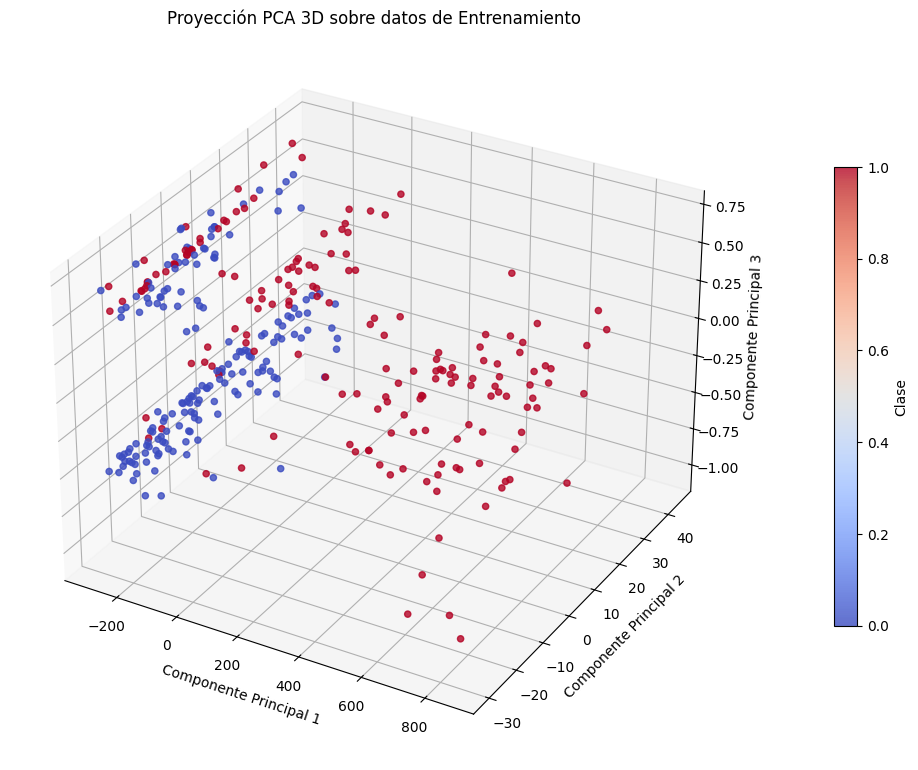

In [120]:
# Visualización de resultados.
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Gráfico de dispersión en 3D
scatter = ax.scatter(
    x_train_pca_1[:, 0],
    x_train_pca_1[:, 1],
    x_train_pca_1[:, 2],
    c=y_train_1,
    cmap='coolwarm',
    alpha=0.8
)

# Etiquetas de ejes
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
ax.set_title("Proyección PCA 3D sobre datos de Entrenamiento")

# Barra de color
cbar = plt.colorbar(scatter, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label("Clase")

plt.grid(True)
plt.tight_layout()
plt.show()

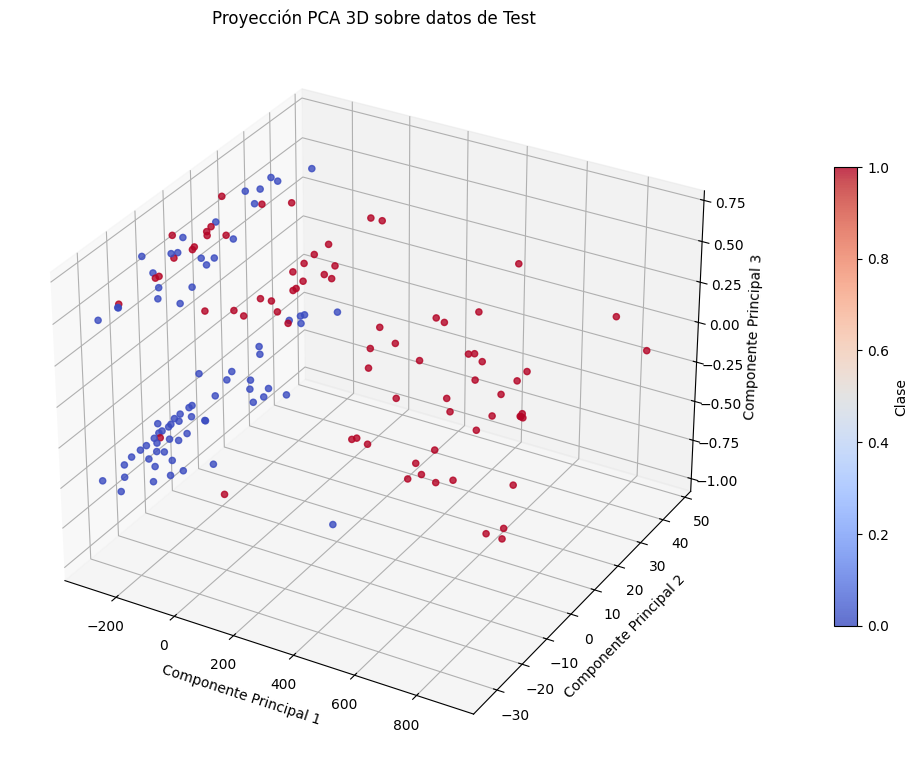

In [121]:
# Visualización de resultados.
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Gráfico de dispersión en 3D
scatter = ax.scatter(
    x_test_pca_1[:, 0],
    x_test_pca_1[:, 1],
    x_test_pca_1[:, 2],
    c=y_test_1,
    cmap='coolwarm',
    alpha=0.8
)

# Etiquetas de ejes
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
ax.set_title("Proyección PCA 3D sobre datos de Test")

# Barra de color
cbar = plt.colorbar(scatter, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label("Clase")

plt.grid(True)
plt.tight_layout()
plt.show()

#### QPCA

In [122]:
# Elegimos 3 qubits -> necesitamos vectores de dimensión 2^3 = 8
n_qubits = 3
state_dim = 2**n_qubits

# Padding de los datos de entrenamiento y test
x_train_1_padded = np.array([pad_vector(x, state_dim) for x in x_train_1])
x_test_1_padded = np.array([pad_vector(x, state_dim) for x in x_test_1])

# Creamos un dispositivo simulado de 3 qubits
dev = qml.device("default.qubit", wires=n_qubits, shots=5000)

# Definimos el circuito cuántico que mide PauliZ en cada qubit
@qml.qnode(dev)
def density_matrix_measurement(x):
    state_preparation(x)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Obtenemos la "proyección" de cada dato en el espacio cuántico
# Cada vector viene de una medida de 3 dimensiones (una por qubit)
train_meas = np.array([density_matrix_measurement(x) for x in x_train_1])
test_meas = np.array([density_matrix_measurement(x) for x in x_test_1])

# Calculamos la matriz de covarianza de las medidas cuánticas
cov_qpca = np.cov(train_meas.T)

# Obtenemos autovalores y autovectores (componentes principales)
eigenvalues, eigenvectors = np.linalg.eigh(cov_qpca)

# Ordenamos los vectores propios en orden descendente de autovalor
idx = np.argsort(-eigenvalues)
principal_components = eigenvectors[:, idx[:3]]

# Proyectamos las medidas cuánticas en las dos componentes principales
projections_train = train_meas @ principal_components
projections_test = test_meas @ principal_components

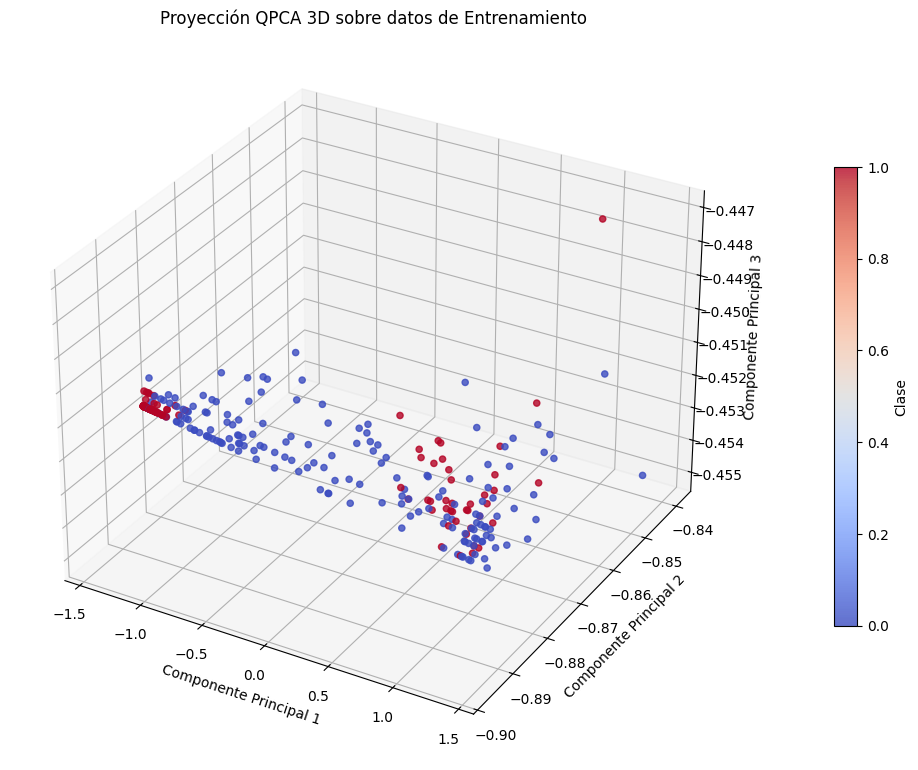

In [123]:
# Visualización de resultados.
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Gráfico de dispersión en 3D
scatter = ax.scatter(
    projections_train[:, 0],
    projections_train[:, 1],
    projections_train[:, 2],
    c=y_train_1,
    cmap='coolwarm',
    alpha=0.8
)

# Etiquetas de ejes
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
ax.set_title("Proyección QPCA 3D sobre datos de Entrenamiento")

# Barra de color
cbar = plt.colorbar(scatter, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label("Clase")

plt.grid(True)
plt.tight_layout()
plt.show()

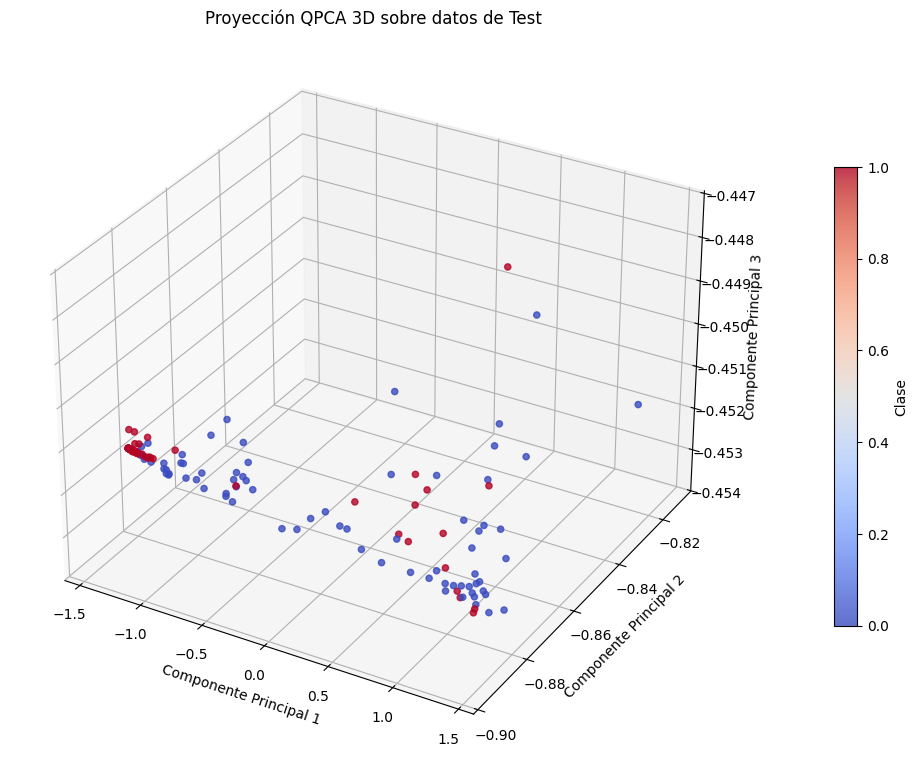

In [124]:
# Visualización de resultados.
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Gráfico de dispersión en 3D
scatter = ax.scatter(
    projections_test[:, 0],
    projections_test[:, 1],
    projections_test[:, 2],
    c=y_test_1,
    cmap='coolwarm',
    alpha=0.8
)

# Etiquetas de ejes
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
ax.set_title("Proyección QPCA 3D sobre datos de Test")

# Barra de color
cbar = plt.colorbar(scatter, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label("Clase")

plt.grid(True)
plt.tight_layout()
plt.show()

#### Decision Tree (PCA)

In [125]:
# Entrenamos y evaluamos datos con PCA.
dt = DecisionTreeClassifier(random_state=17, max_depth=3)
dt.fit(x_train_pca_1, y_train_1)

y_pred_dtpca_1 = dt.predict(x_test_pca_1)

accuracy_dtpca_500_4 = accuracy_score(y_test_1, y_pred_dtpca_1)
precision_dtpca_500_4 = precision_score(y_test_1, y_pred_dtpca_1)
recall_dtpca_500_4 = recall_score(y_test_1, y_pred_dtpca_1)
f1_dtpca_500_4 = f1_score(y_test_1, y_pred_dtpca_1)

print(f"Accuracy Decision Tree con PCA: {accuracy_dtpca_500_4}")
print(f"Precisión Decision Tree con PCA: {precision_dtpca_500_4}")
print(f"Recall Decision Tree con PCA: {recall_dtpca_500_4}")
print(f"F1 Score Decision Tree con PCA: {f1_dtpca_500_4}")
print(classification_report(y_test_1, y_pred_dtpca_1))

Accuracy Decision Tree con PCA: 0.9133333333333333
Precisión Decision Tree con PCA: 0.918918918918919
Recall Decision Tree con PCA: 0.9066666666666666
F1 Score Decision Tree con PCA: 0.912751677852349
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.91        75
         1.0       0.92      0.91      0.91        75

    accuracy                           0.91       150
   macro avg       0.91      0.91      0.91       150
weighted avg       0.91      0.91      0.91       150



#### Decision Tree (QPCA)

In [126]:
# Ahora lo mismo para la versión con QPCA.
qdt = DecisionTreeClassifier(random_state=17, max_depth=3)
qdt.fit(projections_train, y_train_1)

y_pred_qdtpca_1 = qdt.predict(projections_test)

accuracy_qdtpca_500_4 = accuracy_score(y_test_1, y_pred_qdtpca_1)
precision_qdtpca_500_4 = precision_score(y_test_1, y_pred_qdtpca_1)
recall_qdtpca_500_4 = recall_score(y_test_1, y_pred_qdtpca_1)
f1_qdtpca_500_4 = f1_score(y_test_1, y_pred_qdtpca_1)

print(f"Accuracy Decision Tree con QPCA: {accuracy_qdtpca_500_4}")
print(f"Precisión Decision Tree con QPCA: {precision_qdtpca_500_4}")
print(f"Recall Decision Tree con QPCA: {recall_qdtpca_500_4}")
print(f"F1 Score Decision Tree con QPCA: {f1_qdtpca_500_4}")
print(classification_report(y_test_1, y_pred_qdtpca_1))

Accuracy Decision Tree con QPCA: 0.8333333333333334
Precisión Decision Tree con QPCA: 0.9464285714285714
Recall Decision Tree con QPCA: 0.7066666666666667
F1 Score Decision Tree con QPCA: 0.8091603053435115
              precision    recall  f1-score   support

         0.0       0.77      0.96      0.85        75
         1.0       0.95      0.71      0.81        75

    accuracy                           0.83       150
   macro avg       0.86      0.83      0.83       150
weighted avg       0.86      0.83      0.83       150



#### VQC con COBYLA (PCA)

In [127]:
# Escalamos los datos entre 0 y 2 * pi por estar utilizando ángulos.
scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))
x_train_scaled = scaler.fit_transform(x_train_pca_1)
x_test_scaled = scaler.transform(x_test_pca_1)

# Definimos el mapa de características.
feature_map = ZZFeatureMap(feature_dimension=x_train_scaled.shape[1], reps=3)

# Y el ansatz.
ansatz = TwoLocal(num_qubits=x_train_scaled.shape[1], reps=3, rotation_blocks='ry', entanglement_blocks='cz')

# Usamos un sampler para el backend.
sampler = AerSampler()

losses = []

# Creamos el modelo VQC con COBYLA.
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=500),
    sampler=sampler,
    initial_point=np.random.rand(ansatz.num_parameters),
    callback=callback,
)

# Y entrenamos.
vqc.fit(x_train_scaled, y_train_1)

Loss: 1.0685
Loss: 1.0279
Loss: 1.0894
Loss: 1.0634
Loss: 0.9748
Loss: 0.9753
Loss: 0.9774
Loss: 1.1529
Loss: 0.9940
Loss: 0.9867
Loss: 1.1598
Loss: 0.9787
Loss: 0.9800
Loss: 0.9889
Loss: 0.9542
Loss: 0.9836
Loss: 0.9494
Loss: 0.9466
Loss: 0.9461
Loss: 0.9475
Loss: 0.9447
Loss: 1.0352
Loss: 0.9460
Loss: 0.9682
Loss: 0.9500
Loss: 0.9581
Loss: 0.9474
Loss: 0.9481
Loss: 0.9450
Loss: 0.9557
Loss: 0.9469
Loss: 0.9460
Loss: 0.9461
Loss: 0.9496
Loss: 0.9450
Loss: 0.9473
Loss: 0.9497
Loss: 0.9527
Loss: 0.9444
Loss: 0.9485
Loss: 0.9436
Loss: 0.9501
Loss: 0.9503
Loss: 0.9489
Loss: 0.9513
Loss: 0.9477
Loss: 0.9420
Loss: 0.9487
Loss: 0.9409
Loss: 0.9503
Loss: 0.9429
Loss: 0.9439
Loss: 0.9426
Loss: 0.9435
Loss: 0.9446
Loss: 0.9451
Loss: 0.9446
Loss: 0.9480
Loss: 0.9464
Loss: 0.9474
Loss: 0.9457
Loss: 0.9485
Loss: 0.9485
Loss: 0.9439
Loss: 0.9502
Loss: 0.9439
Loss: 0.9490
Loss: 0.9478
Loss: 0.9414
Loss: 0.9455
Loss: 0.9409
Loss: 0.9477
Loss: 0.9458
Loss: 0.9486
Loss: 0.9477
Loss: 0.9452
Loss: 0.9456

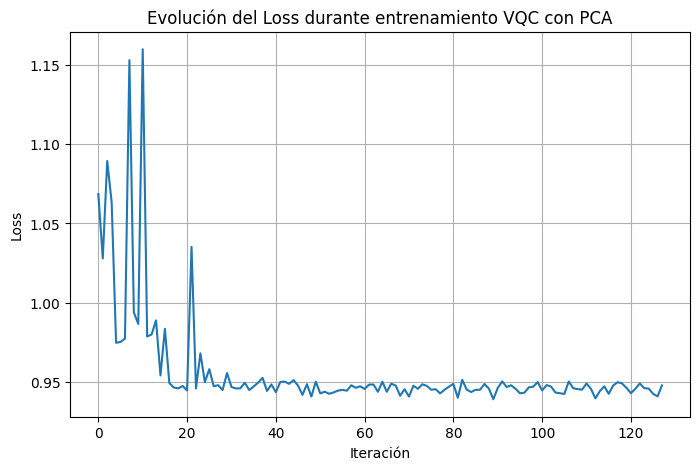

In [128]:
# Graficamos la evolución del loss
plt.figure(figsize=(8,5))
plt.plot(losses, linestyle='-')
plt.title('Evolución del Loss durante entrenamiento VQC con PCA')
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [129]:
# Mostramos ahora los resultados.
y_pred = vqc.predict(x_test_scaled)

accuracy_vqc_pca_500_4 = accuracy_score(y_test_1, y_pred)
precision_vqc_pca_500_4 = precision_score(y_test_1, y_pred)
recall_vqc_pca_500_4 = recall_score(y_test_1, y_pred)
f1_vqc_pca_500_4 = f1_score(y_test_1, y_pred)

print("Accuracy:", accuracy_vqc_pca_500_4)
print("Precisión:", precision_vqc_pca_500_4)
print("Recall:", recall_vqc_pca_500_4)
print("F1 score:", f1_vqc_pca_500_4)
print(classification_report(y_test_1, y_pred))

Accuracy: 0.52
Precisión: 0.5168539325842697
Recall: 0.6133333333333333
F1 score: 0.5609756097560976
              precision    recall  f1-score   support

         0.0       0.52      0.43      0.47        75
         1.0       0.52      0.61      0.56        75

    accuracy                           0.52       150
   macro avg       0.52      0.52      0.52       150
weighted avg       0.52      0.52      0.52       150



#### VQC con COBYLA (QPCA)

In [130]:
# Escalamos los datos entre 0 y 2 * pi por estar utilizando ángulos.
scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))
x_train_scaled = scaler.fit_transform(projections_train)
x_test_scaled = scaler.transform(projections_test)

# Definimos el mapa de características.
feature_map = ZZFeatureMap(feature_dimension=x_train_scaled.shape[1], reps=3)

# Y el ansatz.
ansatz = TwoLocal(num_qubits=x_train_scaled.shape[1], reps=3, rotation_blocks='ry', entanglement_blocks='cz')

# Usamos un sampler para el backend.
sampler = AerSampler()

losses = []

# Creamos el modelo VQC con COBYLA.
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=500),
    sampler=sampler,
    initial_point=np.random.rand(ansatz.num_parameters),
    callback=callback,
)

# Y entrenamos.
vqc.fit(x_train_scaled, y_train_1)

Loss: 1.1581
Loss: 1.3491
Loss: 1.2015
Loss: 1.2516
Loss: 1.3337
Loss: 1.0317
Loss: 1.0797
Loss: 1.1912
Loss: 1.0143
Loss: 0.9507
Loss: 0.8732
Loss: 0.8741
Loss: 0.8754
Loss: 0.8464
Loss: 0.9443
Loss: 0.8882
Loss: 0.9108
Loss: 0.8512
Loss: 0.8575
Loss: 0.8802
Loss: 0.8033
Loss: 0.9081
Loss: 0.8503
Loss: 0.8382
Loss: 0.7296
Loss: 0.7558
Loss: 0.7302
Loss: 0.7435
Loss: 0.7292
Loss: 0.7408
Loss: 0.7208
Loss: 0.7340
Loss: 0.7324
Loss: 0.7529
Loss: 0.7280
Loss: 0.7281
Loss: 0.7191
Loss: 0.7224
Loss: 0.7304
Loss: 0.7217
Loss: 0.7100
Loss: 0.7205
Loss: 0.7143
Loss: 0.7191
Loss: 0.7112
Loss: 0.7220
Loss: 0.7138
Loss: 0.7156
Loss: 0.7053
Loss: 0.7125
Loss: 0.7107
Loss: 0.7103
Loss: 0.7110
Loss: 0.7092
Loss: 0.7107
Loss: 0.7162
Loss: 0.7088
Loss: 0.7111
Loss: 0.7107
Loss: 0.7118
Loss: 0.7119
Loss: 0.7118
Loss: 0.7126
Loss: 0.7131
Loss: 0.7066
Loss: 0.7089
Loss: 0.7063
Loss: 0.7139
Loss: 0.7108
Loss: 0.7139
Loss: 0.7115
Loss: 0.7141
Loss: 0.7122
Loss: 0.7088
Loss: 0.7073
Loss: 0.7122
Loss: 0.7101

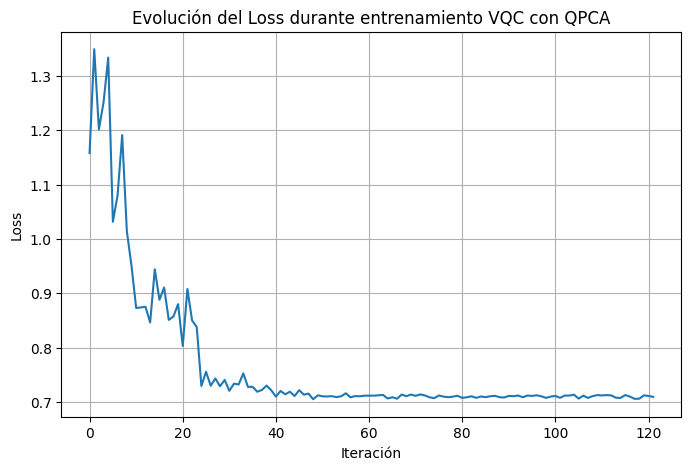

In [131]:
# Graficamos la evolución del loss
plt.figure(figsize=(8,5))
plt.plot(losses, linestyle='-')
plt.title('Evolución del Loss durante entrenamiento VQC con QPCA')
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [132]:
# Mostramos ahora los resultados.
y_pred = vqc.predict(x_test_scaled)

accuracy_vqc_qpca_500_4 = accuracy_score(y_test_1, y_pred)
precision_vqc_qpca_500_4 = precision_score(y_test_1, y_pred)
recall_vqc_qpca_500_4 = recall_score(y_test_1, y_pred)
f1_vqc_qpca_500_4 = f1_score(y_test_1, y_pred)

print("Accuracy:", accuracy_vqc_qpca_500_4)
print("Precisión:", precision_vqc_qpca_500_4)
print("Recall:", recall_vqc_qpca_500_4)
print("F1 score:", f1_vqc_qpca_500_4)
print(classification_report(y_test_1, y_pred))

Accuracy: 0.76
Precisión: 0.7096774193548387
Recall: 0.88
F1 score: 0.7857142857142857
              precision    recall  f1-score   support

         0.0       0.84      0.64      0.73        75
         1.0       0.71      0.88      0.79        75

    accuracy                           0.76       150
   macro avg       0.78      0.76      0.76       150
weighted avg       0.78      0.76      0.76       150



## Resultados

### Accuracy (Desbalance 75-25, 2D)

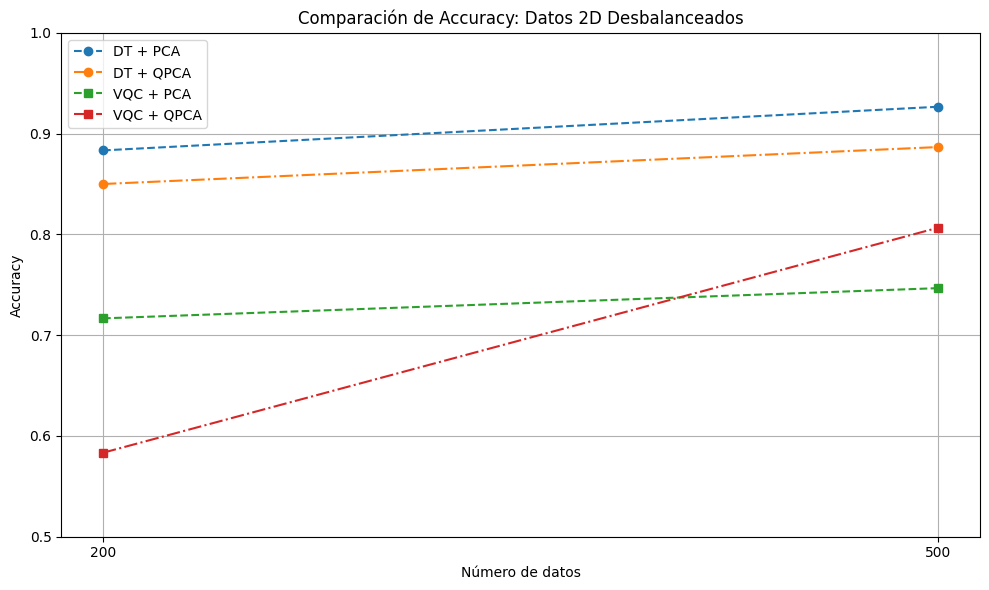

In [142]:
import matplotlib.pyplot as plt

# Eje X: número de datos
num_datos = [200, 500]

# Desbalanceado
acc_dt_pca = [accuracy_dtpca_200_1, accuracy_dtpca_500_1]
acc_dt_qpca = [accuracy_qdtpca_200_1, accuracy_qdtpca_500_1]
acc_vqc_pca = [accuracy_vqc_pca_200_1, accuracy_vqc_pca_500_1]
acc_vqc_qpca = [accuracy_vqc_qpca_200_1, accuracy_vqc_qpca_500_1]

plt.figure(figsize=(10, 6))

# Graficamos cada curva
plt.plot(num_datos, acc_dt_pca, marker='o', linestyle='--', label='DT + PCA')
plt.plot(num_datos, acc_dt_qpca, marker='o', linestyle='-.', label='DT + QPCA')
plt.plot(num_datos, acc_vqc_pca, marker='s', linestyle='--', label='VQC + PCA')
plt.plot(num_datos, acc_vqc_qpca, marker='s', linestyle='-.', label='VQC + QPCA')

# Etiquetas y leyenda
plt.xlabel('Número de datos')
plt.ylabel('Accuracy')
plt.title('Comparación de Accuracy: Datos 2D Desbalanceados')
plt.xticks([200, 500])
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Accuracy (Sin Desbalanceo, 2D)

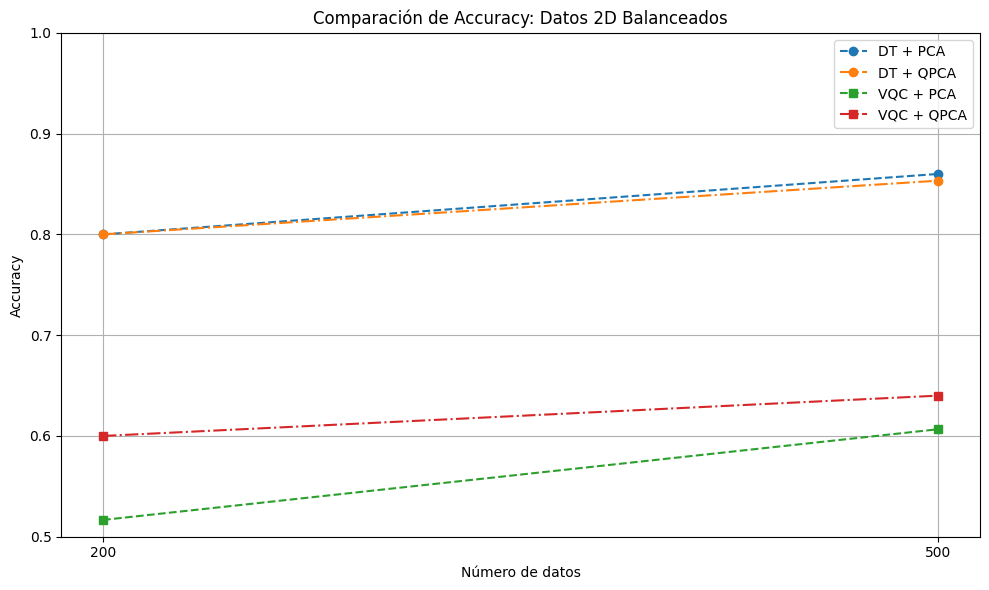

In [143]:
# Eje X: número de datos
num_datos = [200, 500]

# Desbalanceado
acc_dt_pca = [accuracy_dtpca_200_2, accuracy_dtpca_500_2]
acc_dt_qpca = [accuracy_qdtpca_200_2, accuracy_qdtpca_500_2]
acc_vqc_pca = [accuracy_vqc_pca_200_2, accuracy_vqc_pca_500_2]
acc_vqc_qpca = [accuracy_vqc_qpca_200_2, accuracy_vqc_qpca_500_2]

plt.figure(figsize=(10, 6))

# Graficamos cada curva
plt.plot(num_datos, acc_dt_pca, marker='o', linestyle='--', label='DT + PCA')
plt.plot(num_datos, acc_dt_qpca, marker='o', linestyle='-.', label='DT + QPCA')
plt.plot(num_datos, acc_vqc_pca, marker='s', linestyle='--', label='VQC + PCA')
plt.plot(num_datos, acc_vqc_qpca, marker='s', linestyle='-.', label='VQC + QPCA')

# Etiquetas y leyenda
plt.xlabel('Número de datos')
plt.ylabel('Accuracy')
plt.title('Comparación de Accuracy: Datos 2D Balanceados')
plt.xticks([200, 500])
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### F1 Score (Desbalanceo 75-25, 2D)

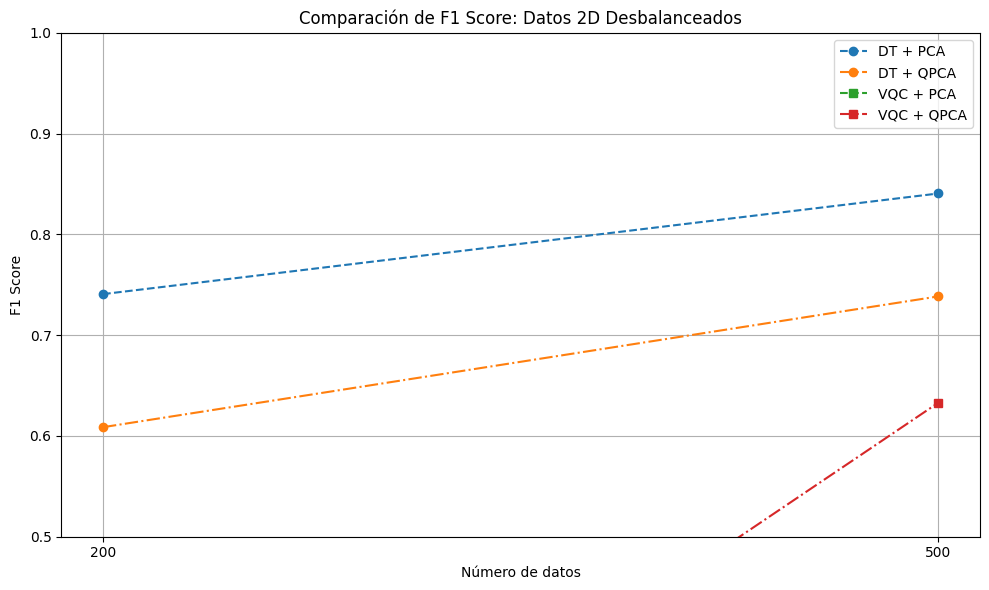

In [150]:
# Eje X: número de datos
num_datos = [200, 500]

# Desbalanceado
f1_dt_pca = [f1_dtpca_200_1, f1_dtpca_500_1]
f1_dt_qpca = [f1_qdtpca_200_1, f1_qdtpca_500_1]
f1_vqc_pca = [f1_vqc_pca_200_1, f1_vqc_pca_500_1]
f1_vqc_qpca = [f1_vqc_qpca_200_1, f1_vqc_qpca_500_1]

plt.figure(figsize=(10, 6))

# Graficamos cada curva
plt.plot(num_datos, f1_dt_pca, marker='o', linestyle='--', label='DT + PCA')
plt.plot(num_datos, f1_dt_qpca, marker='o', linestyle='-.', label='DT + QPCA')
plt.plot(num_datos, f1_vqc_pca, marker='s', linestyle='--', label='VQC + PCA')
plt.plot(num_datos, f1_vqc_qpca, marker='s', linestyle='-.', label='VQC + QPCA')

# Etiquetas y leyenda
plt.xlabel('Número de datos')
plt.ylabel('F1 Score')
plt.title('Comparación de F1 Score: Datos 2D Desbalanceados')
plt.xticks([200, 500])
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### F1 Score (Sin Desbalanceo, 2D)

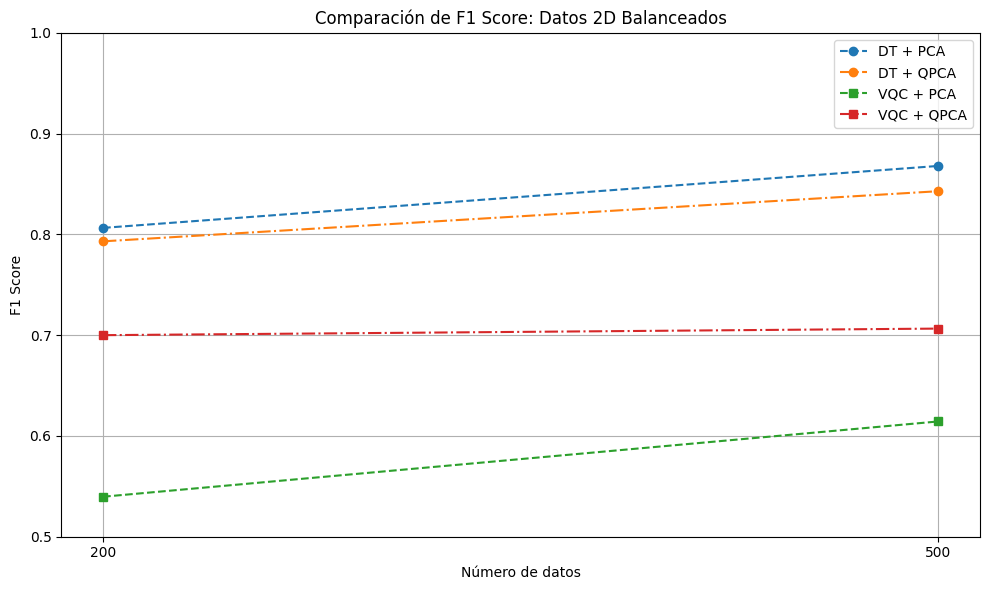

In [151]:
# Eje X: número de datos
num_datos = [200, 500]

# Desbalanceado
f1_dt_pca = [f1_dtpca_200_2, f1_dtpca_500_2]
f1_dt_qpca = [f1_qdtpca_200_2, f1_qdtpca_500_2]
f1_vqc_pca = [f1_vqc_pca_200_2, f1_vqc_pca_500_2]
f1_vqc_qpca = [f1_vqc_qpca_200_2, f1_vqc_qpca_500_2]

plt.figure(figsize=(10, 6))

# Graficamos cada curva
plt.plot(num_datos, f1_dt_pca, marker='o', linestyle='--', label='DT + PCA')
plt.plot(num_datos, f1_dt_qpca, marker='o', linestyle='-.', label='DT + QPCA')
plt.plot(num_datos, f1_vqc_pca, marker='s', linestyle='--', label='VQC + PCA')
plt.plot(num_datos, f1_vqc_qpca, marker='s', linestyle='-.', label='VQC + QPCA')

# Etiquetas y leyenda
plt.xlabel('Número de datos')
plt.ylabel('F1 Score')
plt.title('Comparación de F1 Score: Datos 2D Balanceados')
plt.xticks([200, 500])
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Accuracy (Desbalanceo 75-25, 3D)

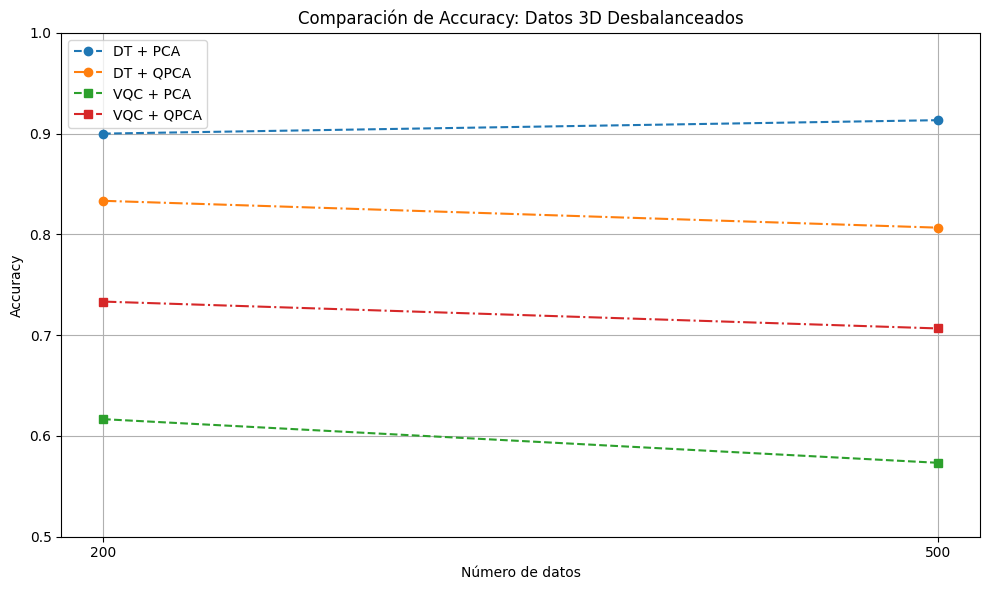

In [146]:
# Eje X: número de datos
num_datos = [200, 500]

# Desbalanceado
acc_dt_pca = [accuracy_dtpca_200_3, accuracy_dtpca_500_3]
acc_dt_qpca = [accuracy_qdtpca_200_3, accuracy_qdtpca_500_3]
acc_vqc_pca = [accuracy_vqc_pca_200_3, accuracy_vqc_pca_500_3]
acc_vqc_qpca = [accuracy_vqc_qpca_200_3, accuracy_vqc_qpca_500_3]

plt.figure(figsize=(10, 6))

# Graficamos cada curva
plt.plot(num_datos, acc_dt_pca, marker='o', linestyle='--', label='DT + PCA')
plt.plot(num_datos, acc_dt_qpca, marker='o', linestyle='-.', label='DT + QPCA')
plt.plot(num_datos, acc_vqc_pca, marker='s', linestyle='--', label='VQC + PCA')
plt.plot(num_datos, acc_vqc_qpca, marker='s', linestyle='-.', label='VQC + QPCA')

# Etiquetas y leyenda
plt.xlabel('Número de datos')
plt.ylabel('Accuracy')
plt.title('Comparación de Accuracy: Datos 3D Desbalanceados')
plt.xticks([200, 500])
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Accuracy (Sin Desbalanceo, 3D)

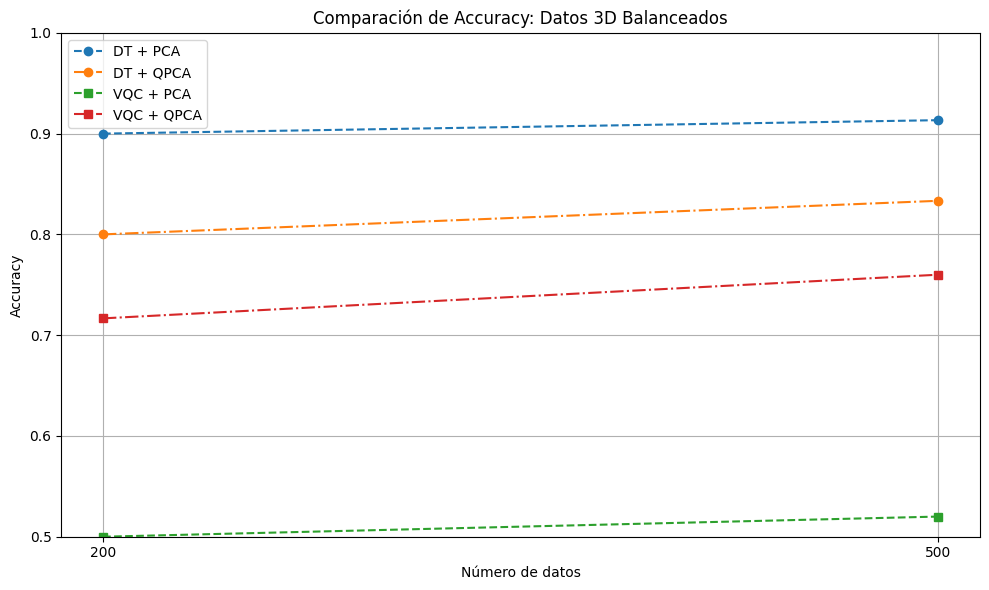

In [147]:
# Eje X: número de datos
num_datos = [200, 500]

# Desbalanceado
acc_dt_pca = [accuracy_dtpca_200_4, accuracy_dtpca_500_4]
acc_dt_qpca = [accuracy_qdtpca_200_4, accuracy_qdtpca_500_4]
acc_vqc_pca = [accuracy_vqc_pca_200_4, accuracy_vqc_pca_500_4]
acc_vqc_qpca = [accuracy_vqc_qpca_200_4, accuracy_vqc_qpca_500_4]

plt.figure(figsize=(10, 6))

# Graficamos cada curva
plt.plot(num_datos, acc_dt_pca, marker='o', linestyle='--', label='DT + PCA')
plt.plot(num_datos, acc_dt_qpca, marker='o', linestyle='-.', label='DT + QPCA')
plt.plot(num_datos, acc_vqc_pca, marker='s', linestyle='--', label='VQC + PCA')
plt.plot(num_datos, acc_vqc_qpca, marker='s', linestyle='-.', label='VQC + QPCA')

# Etiquetas y leyenda
plt.xlabel('Número de datos')
plt.ylabel('Accuracy')
plt.title('Comparación de Accuracy: Datos 3D Balanceados')
plt.xticks([200, 500])
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### F1 Score (Desbalanceo 75-25, 3D)

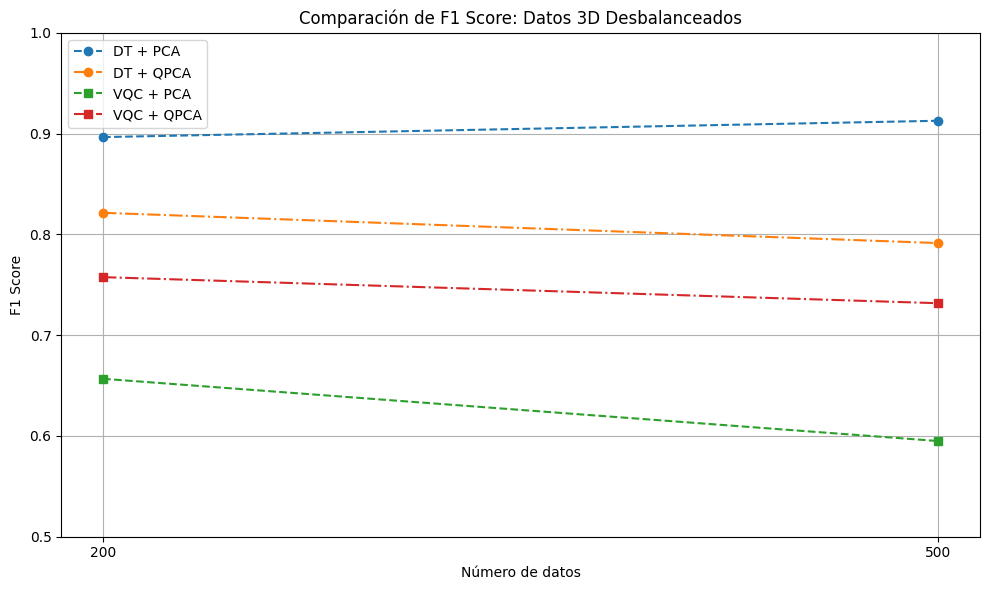

In [152]:
# Eje X: número de datos
num_datos = [200, 500]

# Desbalanceado
f1_dt_pca = [f1_dtpca_200_3, f1_dtpca_500_3]
f1_dt_qpca = [f1_qdtpca_200_3, f1_qdtpca_500_3]
f1_vqc_pca = [f1_vqc_pca_200_3, f1_vqc_pca_500_3]
f1_vqc_qpca = [f1_vqc_qpca_200_3, f1_vqc_qpca_500_3]

plt.figure(figsize=(10, 6))

# Graficamos cada curva
plt.plot(num_datos, f1_dt_pca, marker='o', linestyle='--', label='DT + PCA')
plt.plot(num_datos, f1_dt_qpca, marker='o', linestyle='-.', label='DT + QPCA')
plt.plot(num_datos, f1_vqc_pca, marker='s', linestyle='--', label='VQC + PCA')
plt.plot(num_datos, f1_vqc_qpca, marker='s', linestyle='-.', label='VQC + QPCA')

# Etiquetas y leyenda
plt.xlabel('Número de datos')
plt.ylabel('F1 Score')
plt.title('Comparación de F1 Score: Datos 3D Desbalanceados')
plt.xticks([200, 500])
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### F1 Score (Sin Desbalanceo, 3D)

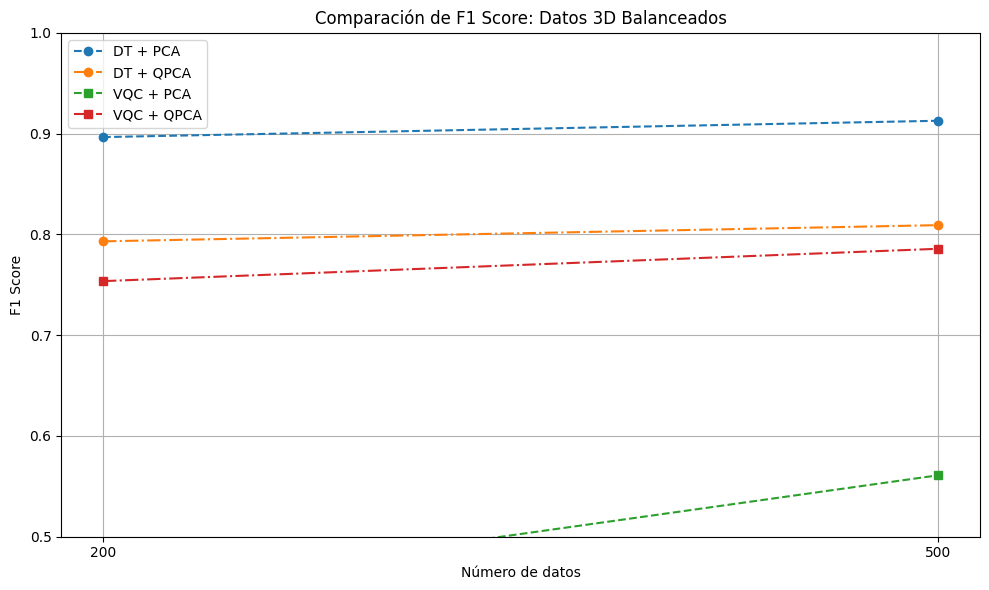

In [153]:
# Eje X: número de datos
num_datos = [200, 500]

# Desbalanceado
f1_dt_pca = [f1_dtpca_200_4, f1_dtpca_500_4]
f1_dt_qpca = [f1_qdtpca_200_4, f1_qdtpca_500_4]
f1_vqc_pca = [f1_vqc_pca_200_4, f1_vqc_pca_500_4]
f1_vqc_qpca = [f1_vqc_qpca_200_4, f1_vqc_qpca_500_4]

plt.figure(figsize=(10, 6))

# Graficamos cada curva
plt.plot(num_datos, f1_dt_pca, marker='o', linestyle='--', label='DT + PCA')
plt.plot(num_datos, f1_dt_qpca, marker='o', linestyle='-.', label='DT + QPCA')
plt.plot(num_datos, f1_vqc_pca, marker='s', linestyle='--', label='VQC + PCA')
plt.plot(num_datos, f1_vqc_qpca, marker='s', linestyle='-.', label='VQC + QPCA')

# Etiquetas y leyenda
plt.xlabel('Número de datos')
plt.ylabel('F1 Score')
plt.title('Comparación de F1 Score: Datos 3D Balanceados')
plt.xticks([200, 500])
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()